<a href="https://colab.research.google.com/github/anuragbantu/DL-Assignment-1/blob/main/Assignment-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import fashion_mnist

# **Question 1**

The fashion_MNIST dataset is loaded and 1 sample image for each classs is plotted below.

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

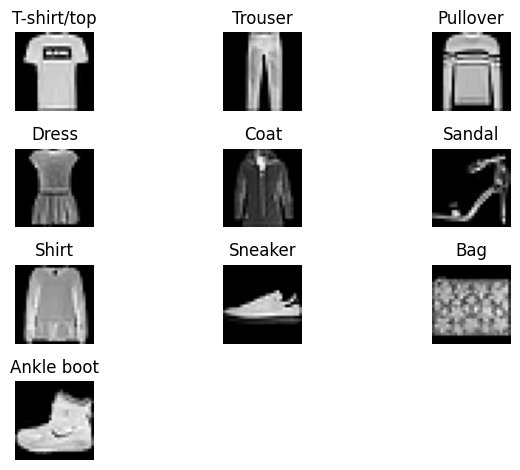

In [4]:
for i in range(10):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(4, 3, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(class_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Question 2 & 3**

preparing the dataset.

In [5]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.0

In [6]:
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = np.max(labels) + 1

    encoded = np.zeros((len(labels), num_classes))

    encoded[np.arange(len(labels)), labels] = 1

    return encoded

y_train = one_hot_encode(y_train)


In [7]:
y_test = one_hot_encode(y_test)

Define all the activation functions and the necessary loss functions. We will use cross entropy loss for the most part but in Question 8 we will use squared error loss as well.

In [8]:
def sigmoid(x):
  return 0.5 * (1 + np.tanh(0.5 * x))

def sigmoid_d(x):
  s= sigmoid(x)
  return s*(1-s)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True) + 1e-8)
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def softmax_d(x):
    diag_s = np.diag(x)

    outer_s = np.outer(x, x)
    return diag_s - outer_s

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    return 1 - np.square(np.tanh(x))

def relu(x):
    return np.maximum(0, x)

def relu_d(x):
    return np.where(x > 0, 1, 0)

#CCE loss function
def categorical_cross_entropy(y_true, y_pred, layers, weight_decay=0):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred), axis=-1)
    loss = np.mean(loss)

    l2_penalty = weight_decay * sum(np.sum(layer.weights ** 2) for layer in layers)

    return loss + l2_penalty

#MSE loss
def squared_error_loss(y_true, y_pred):
    return (np.mean(np.sum((y_true - y_pred) ** 2, axis=1))/2)

activations = {"sigmoid":sigmoid,"softmax":softmax,"tanh":tanh,"relu":relu}

derivatives = {"sigmoid":sigmoid_d}





Define a class for layers.

In [9]:
class layer:
  def __init__(self, input, neurons, activation, weight_init):
    if weight_init == "xavier":
        self.weights = np.random.randn(input, neurons) * np.sqrt(1 / input)
    else:
        self.weights = np.random.randn(input, neurons)
    self.bias = np.zeros((1, neurons))
    self.activation = activations[activation]
    self.activation_d = derivatives.get(activation, None)

  #define forward propagation
  def forward(self, a_prev):
    self.a_prev = a_prev
    self.z = np.dot(self.a_prev,self.weights) + self.bias
    self.a = self.activation(self.z)
    return self.a

  #define all the optimization techniques being used
  def sgd(self,w_d,b_d,lr):
    self.weights -= lr*w_d
    self.bias -= lr*b_d

  def momentum_gd(self, w_d, b_d, lr, momentum=0.9):
    if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
    if not hasattr(self, 'm_b'):
        self.m_b = np.zeros_like(self.bias)
    self.m_w = momentum * self.m_w + lr * w_d
    self.m_b = momentum * self.m_b + lr * b_d
    self.weights -= self.m_w
    self.bias -= self.m_b

  def nesterov_gd(self, w_d, b_d, lr, momentum=0.9):
      if not hasattr(self, 'm_w'):
          self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      m_w_prev, m_b_prev = self.m_w, self.m_b
      self.m_w = momentum * self.m_w + lr * w_d
      self.m_b = momentum * self.m_b + lr * b_d
      self.weights -= momentum * m_w_prev + (1 + momentum) * self.m_w
      self.bias -= momentum * m_b_prev + (1 + momentum) * self.m_b

  def rmsprop(self, w_d, b_d, lr, decay_rate=0.9, epsilon=1e-8):
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      self.v_w = decay_rate * self.v_w + (1 - decay_rate) * np.square(w_d)
      self.v_b = decay_rate * self.v_b + (1 - decay_rate) * np.square(b_d)
      self.weights -= lr * w_d / (np.sqrt(self.v_w) + epsilon)
      self.bias -= lr * b_d / (np.sqrt(self.v_b) + epsilon)

  def adam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):

      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0

      self.t += 1

      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      self.weights -= lr * m_w_hat / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

  def nadam(self, w_d, b_d, lr, beta1=0.9, beta2=0.999, epsilon=1e-8):
      if not hasattr(self, 'm_w'):
        self.m_w = np.zeros_like(self.weights)
      if not hasattr(self, 'm_b'):
          self.m_b = np.zeros_like(self.bias)
      if not hasattr(self, 'v_w'):
          self.v_w = np.zeros_like(self.weights)
      if not hasattr(self, 'v_b'):
          self.v_b = np.zeros_like(self.bias)
      if not hasattr(self, 't'):
          self.t = 0
      self.t += 1
      self.m_w = beta1 * self.m_w + (1 - beta1) * w_d
      self.m_b = beta1 * self.m_b + (1 - beta1) * b_d
      self.v_w = beta2 * self.v_w + (1 - beta2) * np.square(w_d)
      self.v_b = beta2 * self.v_b + (1 - beta2) * np.square(b_d)
      m_w_hat = self.m_w / (1 - beta1**self.t)
      m_b_hat = self.m_b / (1 - beta1**self.t)
      v_w_hat = self.v_w / (1 - beta2**self.t)
      v_b_hat = self.v_b / (1 - beta2**self.t)
      m_w_bar = beta1 * m_w_hat + ((1 - beta1) / (1 - beta1**self.t)) * w_d
      m_b_bar = beta1 * m_b_hat + ((1 - beta1) / (1 - beta1**self.t)) * b_d
      self.weights -= lr * m_w_bar / (np.sqrt(v_w_hat) + epsilon)
      self.bias -= lr * m_b_bar / (np.sqrt(v_b_hat) + epsilon)


  #define the backpropagation algorithm
  def backprop(self, a_d, lr, optimizer, weight_decay=0):
    if self.activation_d:
      z_d = np.multiply(self.activation_d(self.z),a_d)
    else:
      z_d = a_d

    w_d = np.dot(self.a_prev.T,z_d) + weight_decay * self.weights
    b_d = np.sum(z_d,axis=0,keepdims=True)
    a_prev_d = np.dot(z_d,self.weights.T)

    if optimizer == 'sgd':
            self.sgd(w_d, b_d, lr)
    elif optimizer == 'momentum':
        self.momentum_gd(w_d, b_d, lr)
    elif optimizer == 'nesterov':
        self.nesterov_gd(w_d, b_d, lr)
    elif optimizer == 'rmsprop':
        self.rmsprop(w_d, b_d, lr)
    elif optimizer == 'adam':
        self.adam(w_d, b_d, lr)
    elif optimizer == 'nadam':
        self.nadam(w_d, b_d, lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")

    return a_prev_d



# Question 3

Implement backpropagation algorithm

# Question 4,5,6


Training different neural entwrok models while using wandb for hyperparamter tuning to find the best performing combinations.

In [10]:
#installing wandb and then logging in
!pip install wandb -Uq

In [11]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma24m003 (ma24m003-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [12]:
#setting 10%of the training data aside for validation
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

Setting up the strategy and different parameter values to be analyzed by wandb sweep experiments. Here, we use Bayesian optimization with the goal of maximizing validation accuracy.

In [13]:
#setting the sweep configuration for wandb
import numpy as np

sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10, 15]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'fc_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005,0.005,0.05, 0.5]},
        'lr': {'values': [1e-3, 1e-4,1e-5]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="neural-network-hyperparam-tuning")

#defining accuracy metric to measure the model performance
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))





Create sweep with ID: r85c356q
Sweep URL: https://wandb.ai/ma24m003-iit-madras/neural-network-hyperparam-tuning/sweeps/r85c356q


Now, we train the neural networks with different hyperparameter values on the training set. After each epoch, we analyze the performance of the model on the validation set and at the end after all the epochs of training the model we look at the performance on the test dataset. This wandb sweep is run with count=100 which will evaluate 100 different combinations of hyperparameters.

In [14]:
#train the neural network with categorical cross entropy loss

def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config

        #set the model name using all the parameter values
        run_name = (f"hl_{config['num_hidden_layers']}_bs_{config['batch_size']}_ac_{config['activation']}_"
            f"fc_{config['fc_layer_size']}_lr_{config['lr']}_opt_{config['optimizer']}_"
            f"wd_{config['weight_decay']}_wi_{config['weight_init']}_ep_{config['epochs']}")
        wandb.run.name = run_name

        #initialize the 1st input layer
        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]


        #build the subsequent hidden layers and add the last outputlayer
        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        #iterate over epochs
        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            #iterate over batches
            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                #forward propagation
                a = x_batch
                for l in layers:
                    a = l.forward(a)

                #calculate loss and accuracy
                loss = categorical_cross_entropy(y_batch, a,layers, config.weight_decay)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                #backward propagation
                a_d = a - y_batch
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer, config.weight_decay)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            #calculate the validation loss and accuracy for the epoch
            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = categorical_cross_entropy(y_val, a_val, layers, config.weight_decay)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

        #After training, evaluate the model on the test dataset
        a_test = x_test
        for l in layers:
            a_test = l.forward(a_test)

        test_loss = categorical_cross_entropy(y_test, a_test,layers, config.weight_decay)
        test_acc = accuracy(y_test, a_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})


        #plot the confusion matrices
        y_pred = np.argmax(a_test, axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")

        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()



x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

wandb.agent(sweep_id, train_network, count=100)

wandb.finish()


wandb: Agent Starting Run: lko1px01 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 74996.23168829388, Accuracy: 0.6648333333333334, val_loss: 75016.18099209013, val_accuracy: 0.7356666666666667
Epoch 2, Loss: 75098.82745911578, Accuracy: 0.7459444444444444, val_loss: 75155.8625542738, val_accuracy: 0.7633333333333333
Epoch 3, Loss: 75182.83200559476, Accuracy: 0.7653703703703704, val_loss: 75166.4625784483, val_accuracy: 0.7696666666666667
Epoch 4, Loss: 75147.27559470598, Accuracy: 0.7755185185185185, val_loss: 75138.49582942133, val_accuracy: 0.7716666666666666
Epoch 5, Loss: 75121.1280349961, Accuracy: 0.7806111111111111, val_loss: 75105.12645787717, val_accuracy: 0.8016666666666666
Epoch 6, Loss: 75085.30353728861, Accuracy: 0.7869074074074074, val_loss: 74967.71832411, val_accuracy: 0.787
Epoch 7, Loss: 74859.4743606902, Accuracy: 0.7908148148148149, val_loss: 74782.82565147911, val_accuracy: 0.7898333333333334
Epoch 8, Loss: 74706.08377604409, Accuracy: 0.7903518518518519, val_loss: 74603.20460066825, val_accuracy: 0.8061666666666667
Epoch 9, Los

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,▇▇███▇▆▅▃▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▅█▆▆█▇▆
val_loss,▇████▇▆▅▃▁
accuracy,0.7965
epoch,10
loss,74036.03353
test_accuracy,0.768


wandb: Agent Starting Run: ta8agovj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 119.02433720156782, Accuracy: 0.7105, val_loss: 150.79290861986465, val_accuracy: 0.6953333333333334
Epoch 2, Loss: 187.6856695240967, Accuracy: 0.6997222222222222, val_loss: 220.99947842507734, val_accuracy: 0.7285
Epoch 3, Loss: 198.87348461265546, Accuracy: 0.6637407407407407, val_loss: 124.48090533417859, val_accuracy: 0.6558333333333334
Epoch 4, Loss: 176.72580767135528, Accuracy: 0.6625185185185185, val_loss: 223.52623770068197, val_accuracy: 0.6775
Epoch 5, Loss: 239.24538823943266, Accuracy: 0.6816851851851852, val_loss: 245.35331336892554, val_accuracy: 0.6508333333333334
Epoch 6, Loss: 205.22490324918053, Accuracy: 0.6443888888888889, val_loss: 168.9015140138891, val_accuracy: 0.5661666666666667
Epoch 7, Loss: 134.39885592884255, Accuracy: 0.6236666666666667, val_loss: 172.13900194848807, val_accuracy: 0.6348333333333334
Epoch 8, Loss: 183.0654578997796, Accuracy: 0.6293888888888889, val_loss: 166.7896552700496, val_accuracy: 0.626
Epoch 9, Loss: 210.9267925535

accuracy,█▇▄▄▆▃▁▁▁▂▃▁▂▂▂
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁▄▄▃▅▄▂▃▄▃▃▅▆▅█
test_accuracy,▁
test_loss,▁
val_accuracy,▇█▅▆▅▁▄▄▃▅▂▄▄▆▄
val_loss,▂▃▁▃▄▂▂▂▂▂▂▆▅▄█
accuracy,0.63961
epoch,15
loss,311.16714
test_accuracy,0.6087


wandb: Agent Starting Run: 8szozznh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 8.332261888628068, Accuracy: 0.6838980328192961, val_loss: 22.254167375981773, val_accuracy: 0.7606666666666667
Epoch 2, Loss: 59.69516294300037, Accuracy: 0.7568146994859628, val_loss: 112.42759174856461, val_accuracy: 0.754
Epoch 3, Loss: 246.53156618472113, Accuracy: 0.7518164294187426, val_loss: 465.1870331220201, val_accuracy: 0.7468333333333333
Epoch 4, Loss: 942.5370279743057, Accuracy: 0.7324844306049823, val_loss: 1546.6439240675286, val_accuracy: 0.7088333333333333
Epoch 5, Loss: 2450.7024280870187, Accuracy: 0.7267138691182286, val_loss: 3590.232473036376, val_accuracy: 0.6995
Epoch 6, Loss: 5278.169388859316, Accuracy: 0.7231675069197312, val_loss: 7222.010669296759, val_accuracy: 0.7316666666666667
Epoch 7, Loss: 9913.90397828295, Accuracy: 0.7403741597469355, val_loss: 12935.55796697475, val_accuracy: 0.7468333333333333
Epoch 8, Loss: 16476.892270184657, Accuracy: 0.7365868426255437, val_loss: 20725.902271303763, val_accuracy: 0.7073333333333334
Epoch 9, Lo

accuracy,▁██▆▅▅▆▆▄▄
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▁▁▁▁▂▂▃▅█
test_accuracy,▁
test_loss,▁
val_accuracy,█▇▇▃▂▅▇▃▅▁
val_loss,▁▁▁▁▁▂▃▃▅█
accuracy,0.7118
epoch,10
loss,46775.71176
test_accuracy,0.6654


wandb: Agent Starting Run: cun2sx4b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 114.23065893546419, Accuracy: 0.10254176551996837, val_loss: 73.42673853731866, val_accuracy: 0.09666666666666666
Epoch 2, Loss: 50.417925225990054, Accuracy: 0.10001482799525505, val_loss: 32.886214852877316, val_accuracy: 0.09716666666666667
Epoch 3, Loss: 22.996793106272644, Accuracy: 0.09990979636219849, val_loss: 15.46063476477711, val_accuracy: 0.09716666666666667
Epoch 4, Loss: 11.212818564521887, Accuracy: 0.10234405891656782, val_loss: 7.968670435923672, val_accuracy: 0.10533333333333333
Epoch 5, Loss: 6.149501239129679, Accuracy: 0.09970591142744167, val_loss: 4.753336274298211, val_accuracy: 0.09666666666666666
Epoch 6, Loss: 3.9737100248497215, Accuracy: 0.1007006227758007, val_loss: 3.374381618448054, val_accuracy: 0.09633333333333334
Epoch 7, Loss: 3.0390163765096028, Accuracy: 0.10155941083432186, val_loss: 2.7784622805473083, val_accuracy: 0.10316666666666667
Epoch 8, Loss: 2.637826914636858, Accuracy: 0.10171386911822855, val_loss: 2.524116994636185, val

accuracy,█▂▂█▁▃▆▆▂▅
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▂█▁▁▆▆▁▆
val_loss,█▄▂▂▁▁▁▁▁▁
accuracy,0.10143
epoch,10
loss,2.39205
test_accuracy,0.1


wandb: Agent Starting Run: l3trfbzl with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 31.68313440823024, Accuracy: 0.7035370370370371, val_loss: 30.002137858218024, val_accuracy: 0.7691666666666667
Epoch 2, Loss: 29.072362704873427, Accuracy: 0.8035, val_loss: 28.26383349974304, val_accuracy: 0.8238333333333333
Epoch 3, Loss: 27.638322686389515, Accuracy: 0.8259814814814814, val_loss: 26.99943132716961, val_accuracy: 0.8341666666666666
Epoch 4, Loss: 26.410499895594803, Accuracy: 0.8333518518518519, val_loss: 25.92557515936835, val_accuracy: 0.8365
Epoch 5, Loss: 25.384749495968762, Accuracy: 0.8396851851851852, val_loss: 24.88502964514469, val_accuracy: 0.8398333333333333
Epoch 6, Loss: 24.50179636041659, Accuracy: 0.8437037037037037, val_loss: 24.15093915492951, val_accuracy: 0.8391666666666666
Epoch 7, Loss: 23.746943046045534, Accuracy: 0.8475, val_loss: 23.454571236900552, val_accuracy: 0.8365
Epoch 8, Loss: 23.15875767829794, Accuracy: 0.8478518518518519, val_loss: 22.981952325752246, val_accuracy: 0.8416666666666667
Epoch 9, Loss: 22.66421776454014

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▃▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇▇▇▇▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
accuracy,0.85011
epoch,10
loss,22.2416
test_accuracy,0.7577


wandb: Agent Starting Run: uj82hr6r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 195.48020651694557, Accuracy: 0.6567871962062833, val_loss: 145.40909425430186, val_accuracy: 0.7616666666666667
Epoch 2, Loss: 117.49946627451462, Accuracy: 0.7895117071724955, val_loss: 97.14366332717488, val_accuracy: 0.7996666666666666
Epoch 3, Loss: 85.42654281251876, Accuracy: 0.8082765263781861, val_loss: 76.07429954917886, val_accuracy: 0.8175
Epoch 4, Loss: 70.29588085242861, Accuracy: 0.8147599288678127, val_loss: 65.37403928654327, val_accuracy: 0.8176666666666667
Epoch 5, Loss: 62.082288915894814, Accuracy: 0.8163715174866627, val_loss: 59.06446004940264, val_accuracy: 0.824
Epoch 6, Loss: 56.71582820737531, Accuracy: 0.8195761707172495, val_loss: 54.65405835835162, val_accuracy: 0.8261666666666667
Epoch 7, Loss: 53.28583297099068, Accuracy: 0.8196873147599288, val_loss: 52.04404531892085, val_accuracy: 0.8208333333333333
Epoch 8, Loss: 50.90798395076063, Accuracy: 0.8224288678126852, val_loss: 49.942448426991106, val_accuracy: 0.8213333333333334
Epoch 9, Los

accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇██▇▇██
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,0.82267
epoch,10
loss,47.85704
test_accuracy,0.6796


wandb: Agent Starting Run: pd2z3naj with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 33.34935184839641, Accuracy: 0.4556851851851852, val_loss: 33.00660839047716, val_accuracy: 0.587
Epoch 2, Loss: 32.68578349396028, Accuracy: 0.6123148148148149, val_loss: 32.35328189550197, val_accuracy: 0.6301666666666667
Epoch 3, Loss: 32.05479341431581, Accuracy: 0.6600925925925926, val_loss: 31.805696847133653, val_accuracy: 0.6771666666666667
Epoch 4, Loss: 31.592670139077324, Accuracy: 0.7007407407407408, val_loss: 31.397971447918056, val_accuracy: 0.7071666666666667
Epoch 5, Loss: 31.21780624686776, Accuracy: 0.7323333333333333, val_loss: 31.055491357478736, val_accuracy: 0.7393333333333333
Epoch 6, Loss: 30.880012163624745, Accuracy: 0.7581111111111111, val_loss: 30.702193579976598, val_accuracy: 0.7595
Epoch 7, Loss: 30.51013096989455, Accuracy: 0.773537037037037, val_loss: 30.321130598408672, val_accuracy: 0.7751666666666667
Epoch 8, Loss: 30.11401801730271, Accuracy: 0.785074074074074, val_loss: 29.8977924088857, val_accuracy: 0.7855
Epoch 9, Loss: 29.6817858

accuracy,▁▄▅▆▆▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▆▅▅▄▄▃▃▂▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▆▆▇▇▇▇█████
val_loss,█▇▆▆▅▅▅▄▃▃▃▂▂▁▁
accuracy,0.81741
epoch,15
loss,27.71321
test_accuracy,0.774


wandb: Agent Starting Run: des8tfu9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 174.89107607043087, Accuracy: 0.46944444444444444, val_loss: 157.9970428758278, val_accuracy: 0.5918333333333333
Epoch 2, Loss: 143.36803756148956, Accuracy: 0.6351111111111111, val_loss: 129.31900670087688, val_accuracy: 0.6576666666666666
Epoch 3, Loss: 116.94411528055238, Accuracy: 0.6902407407407407, val_loss: 105.48345662111879, val_accuracy: 0.697
Epoch 4, Loss: 95.7183991377569, Accuracy: 0.7221296296296297, val_loss: 86.71685180772812, val_accuracy: 0.7278333333333333
Epoch 5, Loss: 79.1973373234613, Accuracy: 0.7413888888888889, val_loss: 72.39761883857044, val_accuracy: 0.7408333333333333
Epoch 6, Loss: 66.8699910057679, Accuracy: 0.7540370370370371, val_loss: 61.95145190985364, val_accuracy: 0.7508333333333334
Epoch 7, Loss: 57.9033426663059, Accuracy: 0.7626296296296297, val_loss: 54.27131711508702, val_accuracy: 0.7603333333333333
Epoch 8, Loss: 51.331602247183554, Accuracy: 0.7690370370370371, val_loss: 48.639391137142965, val_accuracy: 0.7715
Epoch 9, Loss

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▆▅▄▃▂▂▁▁▁
accuracy,0.77765
epoch,10
loss,42.75609
test_accuracy,0.7378


wandb: Agent Starting Run: eqtc1si7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.7865574315098431, Accuracy: 0.4852037037037037, val_loss: 1.2737886109293437, val_accuracy: 0.6138333333333333
Epoch 2, Loss: 1.1550691513805333, Accuracy: 0.6650555555555555, val_loss: 1.081137242518066, val_accuracy: 0.6843333333333333
Epoch 3, Loss: 1.0325141102154802, Accuracy: 0.7240740740740741, val_loss: 0.9974291524308088, val_accuracy: 0.7406666666666667
Epoch 4, Loss: 0.9636658218533234, Accuracy: 0.7578518518518519, val_loss: 0.9426106907965179, val_accuracy: 0.766
Epoch 5, Loss: 0.9198652893775936, Accuracy: 0.7758888888888889, val_loss: 0.9064569887848235, val_accuracy: 0.782
Test Loss: 8.24174957452773, Test Accuracy: 0.758


accuracy,▁▅▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
accuracy,0.77589
epoch,5
loss,0.91987
test_accuracy,0.758


wandb: Agent Starting Run: 8in0zuy7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 27.344373267838606, Accuracy: 0.5278333333333334, val_loss: 26.99963845506087, val_accuracy: 0.6385
Epoch 2, Loss: 26.793098827391052, Accuracy: 0.6712777777777778, val_loss: 26.566996077888607, val_accuracy: 0.6821666666666667
Epoch 3, Loss: 26.3427615221979, Accuracy: 0.7113703703703703, val_loss: 26.132805324719925, val_accuracy: 0.7181666666666666
Epoch 4, Loss: 25.93584120354025, Accuracy: 0.7441296296296296, val_loss: 25.755052574011316, val_accuracy: 0.7468333333333333
Epoch 5, Loss: 25.57002642848544, Accuracy: 0.7701666666666667, val_loss: 25.385847090513227, val_accuracy: 0.7746666666666666
Epoch 6, Loss: 25.19709662489963, Accuracy: 0.786425925925926, val_loss: 25.006071821501063, val_accuracy: 0.7876666666666666
Epoch 7, Loss: 24.815359364411375, Accuracy: 0.7970185185185186, val_loss: 24.627408357539704, val_accuracy: 0.7983333333333333
Epoch 8, Loss: 24.447216043636782, Accuracy: 0.804537037037037, val_loss: 24.269334171226333, val_accuracy: 0.805
Epoch 9, 

accuracy,▁▄▅▆▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▇▆▅▅▄▄▃▃▃▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇█████
val_loss,█▇▇▆▆▅▄▄▃▃▃▂▂▁▁
accuracy,0.83226
epoch,15
loss,22.40394
test_accuracy,0.7882


wandb: Agent Starting Run: g24ttrj5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 60.14778945360943, Accuracy: 0.11526294978252274, val_loss: 57.93935149891817, val_accuracy: 0.17466666666666666
Epoch 2, Loss: 53.2403200631732, Accuracy: 0.31261120996441283, val_loss: 49.4430412537363, val_accuracy: 0.4191666666666667
Epoch 3, Loss: 47.999902923315396, Accuracy: 0.4656237643337287, val_loss: 46.38096702800331, val_accuracy: 0.5098333333333334
Epoch 4, Loss: 45.38835318758277, Accuracy: 0.5432483194938711, val_loss: 44.450416791683864, val_accuracy: 0.5685
Epoch 5, Loss: 43.748319733917164, Accuracy: 0.5922857354685647, val_loss: 43.33618638190399, val_accuracy: 0.6035
Epoch 6, Loss: 42.740227840090824, Accuracy: 0.6227449090549625, val_loss: 42.28519748916709, val_accuracy: 0.6341666666666667
Epoch 7, Loss: 41.99866858148642, Accuracy: 0.6452216785290629, val_loss: 41.612159407465526, val_accuracy: 0.6563333333333333
Epoch 8, Loss: 41.40943618518729, Accuracy: 0.6634786476868327, val_loss: 41.18174075655344, val_accuracy: 0.6688333333333333
Epoch 9, L

accuracy,▁▃▅▆▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇▇███████
val_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
accuracy,0.71427
epoch,15
loss,39.78946
test_accuracy,0.7087


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vpzzjkef with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.7097000835402727, Accuracy: 0.3842407407407407, val_loss: 1.1203055375242164, val_accuracy: 0.5725
Epoch 2, Loss: 0.9595650372263618, Accuracy: 0.6182407407407408, val_loss: 0.8662291977323675, val_accuracy: 0.6478333333333334
Epoch 3, Loss: 0.7990240619874103, Accuracy: 0.6931851851851852, val_loss: 0.7577973398000064, val_accuracy: 0.7051666666666667
Epoch 4, Loss: 0.7176079539422093, Accuracy: 0.729574074074074, val_loss: 0.6986769411002455, val_accuracy: 0.7298333333333333
Epoch 5, Loss: 0.6689144411382898, Accuracy: 0.7501666666666666, val_loss: 0.6595452920539575, val_accuracy: 0.7488333333333334
Epoch 6, Loss: 0.6338480015803585, Accuracy: 0.7660185185185185, val_loss: 0.6273437362541208, val_accuracy: 0.7666666666666667
Epoch 7, Loss: 0.6067346673498817, Accuracy: 0.7793703703703704, val_loss: 0.6045885560844313, val_accuracy: 0.7818333333333334
Epoch 8, Loss: 0.5851873037450269, Accuracy: 0.7890370370370371, val_loss: 0.5825932981536461, val_accuracy: 0.791
Ep

accuracy,▁▅▆▇▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▆▇▇▇██████
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
accuracy,0.82135
epoch,15
loss,0.50819
test_accuracy,0.7715


wandb: Agent Starting Run: eufix8ar with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 5.574276203058847, Accuracy: 0.8007407407407408, val_loss: 7.670272008031553, val_accuracy: 0.8325
Epoch 2, Loss: 9.808092992083376, Accuracy: 0.8359074074074074, val_loss: 11.692592504389596, val_accuracy: 0.8431666666666666
Epoch 3, Loss: 13.41263236057313, Accuracy: 0.8426666666666667, val_loss: 14.96871013274919, val_accuracy: 0.8368333333333333
Epoch 4, Loss: 16.501160518465813, Accuracy: 0.8458333333333333, val_loss: 17.83781739060356, val_accuracy: 0.8548333333333333
Epoch 5, Loss: 18.978720978344416, Accuracy: 0.8507407407407407, val_loss: 20.048467355373113, val_accuracy: 0.8551666666666666
Epoch 6, Loss: 21.237890387139828, Accuracy: 0.8524259259259259, val_loss: 22.255361927095723, val_accuracy: 0.8538333333333333
Epoch 7, Loss: 23.298663635774314, Accuracy: 0.8536481481481482, val_loss: 24.437860803028748, val_accuracy: 0.8433333333333334
Epoch 8, Loss: 25.42459755854284, Accuracy: 0.8542962962962963, val_loss: 26.503319698156737, val_accuracy: 0.834
Epoch 9,

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▂▃▄▅▆▆▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▂██▇▄▁▆█
val_loss,▁▂▃▄▅▅▆▇▇█
accuracy,0.85722
epoch,10
loss,29.70303
test_accuracy,0.7811


wandb: Agent Starting Run: wp1a806i with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.9680333338873571, Accuracy: 0.8077962962962963, val_loss: 1.0753476553671528, val_accuracy: 0.8375
Epoch 2, Loss: 1.2330853809843403, Accuracy: 0.8439444444444445, val_loss: 1.3979211103719822, val_accuracy: 0.8521666666666666
Epoch 3, Loss: 1.5231920710715303, Accuracy: 0.8523518518518518, val_loss: 1.6624685765282017, val_accuracy: 0.8576666666666667
Epoch 4, Loss: 1.7754950777474188, Accuracy: 0.8569629629629629, val_loss: 1.9061901389042843, val_accuracy: 0.851
Epoch 5, Loss: 2.003344954988388, Accuracy: 0.8581111111111112, val_loss: 2.1209707458482097, val_accuracy: 0.855
Epoch 6, Loss: 2.2246930819556523, Accuracy: 0.860537037037037, val_loss: 2.369212488068263, val_accuracy: 0.8488333333333333
Epoch 7, Loss: 2.4896029067928183, Accuracy: 0.8599259259259259, val_loss: 2.650038792231071, val_accuracy: 0.8566666666666667
Epoch 8, Loss: 2.7705519752068097, Accuracy: 0.8618703703703704, val_loss: 2.9387487952487126, val_accuracy: 0.8613333333333333
Epoch 9, Loss: 3.0

accuracy,▁▅▆▇▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁▁▂▂▃▃▄▄▅▅▆▇▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▅▆▄▇█▃▇▆█▅▇▇
val_loss,▁▂▂▃▃▃▄▄▅▆▆▇▇██
accuracy,0.8662
epoch,15
loss,4.7464
test_accuracy,0.7662


wandb: Agent Starting Run: i98rbwzt with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.5936888692907127, Accuracy: 0.7861851851851852, val_loss: 0.4784662614103675, val_accuracy: 0.8315
Epoch 2, Loss: 0.4512525622919235, Accuracy: 0.8416296296296296, val_loss: 0.42344581741059034, val_accuracy: 0.8508333333333333
Epoch 3, Loss: 0.4268999302490893, Accuracy: 0.8483518518518518, val_loss: 0.41055623026792015, val_accuracy: 0.8528333333333333
Epoch 4, Loss: 0.41799003785072814, Accuracy: 0.8507962962962963, val_loss: 0.4200223231616091, val_accuracy: 0.8486666666666667
Epoch 5, Loss: 0.41129953801898417, Accuracy: 0.8545555555555555, val_loss: 0.4262015754494122, val_accuracy: 0.8496666666666667
Epoch 6, Loss: 0.4047659920251247, Accuracy: 0.8565925925925926, val_loss: 0.41573048071898683, val_accuracy: 0.8533333333333334
Epoch 7, Loss: 0.40398249347308623, Accuracy: 0.8578888888888889, val_loss: 0.42766131575560623, val_accuracy: 0.8488333333333333
Epoch 8, Loss: 0.39910992750875846, Accuracy: 0.8591111111111112, val_loss: 0.41247372610356764, val_accuracy

accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇█▇▇█▇█▃█
val_loss,█▂▁▂▃▂▃▁▆▂
accuracy,0.85694
epoch,10
loss,0.40112
test_accuracy,0.779


wandb: Agent Starting Run: xtqqj89r with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.2338729824622494, Accuracy: 0.579962962962963, val_loss: 0.8869435010194434, val_accuracy: 0.683
Epoch 2, Loss: 0.8333756384969964, Accuracy: 0.7394259259259259, val_loss: 0.8037527856741747, val_accuracy: 0.7595
Epoch 3, Loss: 0.7676211293444292, Accuracy: 0.785074074074074, val_loss: 0.75283456362849, val_accuracy: 0.7925
Epoch 4, Loss: 0.7355977034986447, Accuracy: 0.8026666666666666, val_loss: 0.7313697307789335, val_accuracy: 0.8085
Epoch 5, Loss: 0.7216912149656322, Accuracy: 0.8148888888888889, val_loss: 0.7169423191442315, val_accuracy: 0.8231666666666667
Epoch 6, Loss: 0.7171993954555661, Accuracy: 0.8236296296296296, val_loss: 0.7271670765030952, val_accuracy: 0.8215
Epoch 7, Loss: 0.7194147368241675, Accuracy: 0.8272962962962963, val_loss: 0.7219072228048053, val_accuracy: 0.8335
Epoch 8, Loss: 0.7231445473626708, Accuracy: 0.831, val_loss: 0.7267939318573465, val_accuracy: 0.8366666666666667
Epoch 9, Loss: 0.727231365003539, Accuracy: 0.8328148148148148, va

accuracy,▁▅▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▂▂▁▁▁▁▂▂
accuracy,0.83546
epoch,10
loss,0.72721
test_accuracy,0.7794


wandb: Agent Starting Run: t1qqw3tp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.309319480826919, Accuracy: 0.5185555555555555, val_loss: 0.9604587279565208, val_accuracy: 0.6348333333333334
Epoch 2, Loss: 0.9112497715568371, Accuracy: 0.6796851851851852, val_loss: 0.8720433295807416, val_accuracy: 0.7148333333333333
Epoch 3, Loss: 0.8340838222738874, Accuracy: 0.7419814814814815, val_loss: 0.8073983432443964, val_accuracy: 0.7543333333333333
Epoch 4, Loss: 0.7819930611548008, Accuracy: 0.7770555555555556, val_loss: 0.7690450118937356, val_accuracy: 0.7881666666666667
Epoch 5, Loss: 0.7511840904252819, Accuracy: 0.7993888888888889, val_loss: 0.7397066876581628, val_accuracy: 0.8055
Test Loss: 8.087538164598842, Test Accuracy: 0.7606


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
accuracy,0.79939
epoch,5
loss,0.75118
test_accuracy,0.7606


wandb: Agent Starting Run: yuox8jhd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


<ipython-input-8-3fa72e0033b7>:37: RuntimeWarning: overflow encountered in square
  l2_penalty = weight_decay * sum(np.sum(layer.weights ** 2) for layer in layers)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-8-3fa72e0033b7>:37: RuntimeWarning: invalid value encountered in scalar multiply
  l2_penalty = weight_decay * sum(np.sum(layer.weights ** 2) for layer in layers)


Epoch 1, Loss: nan, Accuracy: 0.10898148148148148, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 2, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 3, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 4, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 5, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 6, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 7, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 8, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 9, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667
Epoch 10, Loss: nan, Accuracy: 0.10031481481481481, val_loss: nan, val_accuracy: 0.09716666666666667

accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.10031
epoch,15
loss,nan
test_accuracy,0.1
test_loss,nan
val_accuracy,0.09717
val_loss,nan


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v6yja915 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.9866599447123442, Accuracy: 0.6991296296296297, val_loss: 0.7481971157062577, val_accuracy: 0.776
Epoch 2, Loss: 0.7025023915202825, Accuracy: 0.8093148148148148, val_loss: 0.6729291666215313, val_accuracy: 0.8283333333333334
Epoch 3, Loss: 0.6646166491056579, Accuracy: 0.8318518518518518, val_loss: 0.651997497864697, val_accuracy: 0.8405
Epoch 4, Loss: 0.6483073157461301, Accuracy: 0.8419444444444445, val_loss: 0.6421356591227837, val_accuracy: 0.8476666666666667
Epoch 5, Loss: 0.6407099891591314, Accuracy: 0.8476851851851852, val_loss: 0.6350478250245435, val_accuracy: 0.8555
Epoch 6, Loss: 0.637138413141816, Accuracy: 0.850925925925926, val_loss: 0.6388992514580273, val_accuracy: 0.8473333333333334
Epoch 7, Loss: 0.6357372870328847, Accuracy: 0.8528888888888889, val_loss: 0.6384294908828012, val_accuracy: 0.8558333333333333
Epoch 8, Loss: 0.635302387923957, Accuracy: 0.8557037037037037, val_loss: 0.6400818901630694, val_accuracy: 0.8543333333333333
Epoch 9, Loss: 0.

accuracy,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇█▇▇█▇▇███
val_loss,█▃▂▁▁▁▁▁▂▂▂▂▃▃▃
accuracy,0.86456
epoch,15
loss,0.65063
test_accuracy,0.7898


wandb: Agent Starting Run: bli4f4fy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 12.460649985436055, Accuracy: 0.7725740740740741, val_loss: 13.80212271819643, val_accuracy: 0.832
Epoch 2, Loss: 13.74255005978478, Accuracy: 0.8312037037037037, val_loss: 13.604819462246617, val_accuracy: 0.8355
Epoch 3, Loss: 13.365227383492698, Accuracy: 0.8374259259259259, val_loss: 13.194501898440022, val_accuracy: 0.8415
Epoch 4, Loss: 12.848121332628095, Accuracy: 0.840925925925926, val_loss: 12.49358713518471, val_accuracy: 0.8401666666666666
Epoch 5, Loss: 12.499952900235503, Accuracy: 0.8431666666666666, val_loss: 12.354983823618838, val_accuracy: 0.8321666666666667
Epoch 6, Loss: 12.245394288514104, Accuracy: 0.8432962962962963, val_loss: 12.153384918593307, val_accuracy: 0.8476666666666667
Epoch 7, Loss: 12.060517740429386, Accuracy: 0.8426481481481481, val_loss: 12.042466309249226, val_accuracy: 0.8513333333333334
Epoch 8, Loss: 12.096141703363411, Accuracy: 0.8425370370370371, val_loss: 12.182696823285067, val_accuracy: 0.8436666666666667
Epoch 9, Loss: 12

accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,▃█▆▄▃▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▄▁▇█▅▆▄
val_loss,█▇▆▄▃▃▂▃▃▁
accuracy,0.84026
epoch,10
loss,12.04376
test_accuracy,0.699


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2lp685tq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.3057011286894604, Accuracy: 0.5768888888888889, val_loss: 1.1629165379457163, val_accuracy: 0.637
Epoch 2, Loss: 1.2183643305697005, Accuracy: 0.6599259259259259, val_loss: 1.280989663762033, val_accuracy: 0.6701666666666667
Epoch 3, Loss: 1.330922806949026, Accuracy: 0.6823518518518519, val_loss: 1.3970789521650935, val_accuracy: 0.689
Epoch 4, Loss: 1.4623723424868569, Accuracy: 0.7056296296296296, val_loss: 1.5396412293276758, val_accuracy: 0.7021666666666667
Epoch 5, Loss: 1.6124325121367389, Accuracy: 0.712, val_loss: 1.7078407522183046, val_accuracy: 0.6961666666666667
Epoch 6, Loss: 1.777866152403032, Accuracy: 0.7077407407407408, val_loss: 1.8633195244124012, val_accuracy: 0.7028333333333333
Epoch 7, Loss: 1.9363427779013926, Accuracy: 0.718462962962963, val_loss: 2.014952092137592, val_accuracy: 0.7205
Epoch 8, Loss: 2.0827785142443895, Accuracy: 0.7298333333333333, val_loss: 2.156105800226479, val_accuracy: 0.727
Epoch 9, Loss: 2.2219409672783947, Accuracy: 0

accuracy,▁▄▅▆▇▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,▂▁▂▃▃▄▅▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▅▅▇▇▇█
val_loss,▁▂▂▃▄▅▆▆▇█
accuracy,0.7448
epoch,10
loss,2.35186
test_accuracy,0.7278


wandb: Agent Starting Run: yykvq6oz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 78.46803212380287, Accuracy: 0.7195655397390273, val_loss: 80.70724780846491, val_accuracy: 0.7988333333333333
Epoch 2, Loss: 76.8152110667651, Accuracy: 0.8149466192170819, val_loss: 72.0905142410125, val_accuracy: 0.8248333333333333
Epoch 3, Loss: 69.21458443970286, Accuracy: 0.8246033511269276, val_loss: 65.5587245241858, val_accuracy: 0.8303333333333334
Epoch 4, Loss: 63.365417527174934, Accuracy: 0.8300773527085805, val_loss: 61.17186914075183, val_accuracy: 0.8321666666666667
Epoch 5, Loss: 59.571954148214566, Accuracy: 0.8338028865164097, val_loss: 58.18677505335372, val_accuracy: 0.8305
Epoch 6, Loss: 57.0311088476155, Accuracy: 0.8352362593910636, val_loss: 55.52787785302058, val_accuracy: 0.8288333333333333
Epoch 7, Loss: 54.636041032351365, Accuracy: 0.8356996342427837, val_loss: 53.47965705059877, val_accuracy: 0.837
Epoch 8, Loss: 52.77127172189288, Accuracy: 0.8375407769869514, val_loss: 51.58629526552548, val_accuracy: 0.8355
Epoch 9, Loss: 50.810189620872

accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,██▆▄▃▃▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▆▆▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
accuracy,0.8385
epoch,10
loss,49.27666
test_accuracy,0.7188


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 85a5ekkb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 69.15338989480546, Accuracy: 0.7854179016004742, val_loss: 41.55453475678173, val_accuracy: 0.788
Epoch 2, Loss: 37.12409426605809, Accuracy: 0.8122406639004149, val_loss: 35.00946924714422, val_accuracy: 0.81
Epoch 3, Loss: 33.74223813952971, Accuracy: 0.8096287788974511, val_loss: 33.48828348014879, val_accuracy: 0.8081666666666667
Epoch 4, Loss: 33.324100307342235, Accuracy: 0.8105364552459988, val_loss: 33.393479596397576, val_accuracy: 0.8205
Epoch 5, Loss: 33.50208942092595, Accuracy: 0.8097213989330172, val_loss: 33.797035668784794, val_accuracy: 0.813
Epoch 6, Loss: 33.65529509419646, Accuracy: 0.8110551274451689, val_loss: 33.55257446850173, val_accuracy: 0.809
Epoch 7, Loss: 33.78070973076025, Accuracy: 0.8113700355660937, val_loss: 34.042267587970855, val_accuracy: 0.816
Epoch 8, Loss: 35.16805821232103, Accuracy: 0.8089804386484885, val_loss: 35.9921561379435, val_accuracy: 0.8088333333333333
Epoch 9, Loss: 35.72446957658442, Accuracy: 0.8052571132187315, val

accuracy,▁█▇█▇██▇▆▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▅█▆▆▇▅▇▂
val_loss,█▂▁▁▁▁▂▃▃▂
accuracy,0.80679
epoch,10
loss,35.50745
test_accuracy,0.689


wandb: Agent Starting Run: 7c2g17or with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 13726.46881609837, Accuracy: 0.07096547125074096, val_loss: 13714.034154719082, val_accuracy: 0.06183333333333333
Epoch 2, Loss: 13718.601117585866, Accuracy: 0.06405601659751037, val_loss: 13706.712131398894, val_accuracy: 0.0705
Epoch 3, Loss: 13711.346645304635, Accuracy: 0.07570761707172495, val_loss: 13699.7486875745, val_accuracy: 0.09116666666666666
Epoch 4, Loss: 13705.684895372047, Accuracy: 0.09462062833432128, val_loss: 13695.274713840448, val_accuracy: 0.11616666666666667
Epoch 5, Loss: 13702.843308596886, Accuracy: 0.11760892116182572, val_loss: 13694.02423857344, val_accuracy: 0.1315
Epoch 6, Loss: 13702.849492438634, Accuracy: 0.13770746887966806, val_loss: 13695.237784830471, val_accuracy: 0.15316666666666667
Epoch 7, Loss: 13705.01186194534, Accuracy: 0.15680572021339656, val_loss: 13698.019711750925, val_accuracy: 0.18016666666666667
Epoch 8, Loss: 13708.23157404055, Accuracy: 0.18588841138114998, val_loss: 13701.779883031386, val_accuracy: 0.2093333333

accuracy,▁▁▁▂▃▄▄▅▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▂▁▁▂▃▄▅
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▂▃▃▄▅▆▇█
val_loss,█▅▃▁▁▁▂▄▅▆
accuracy,0.2623
epoch,10
loss,13715.37322
test_accuracy,0.2807


wandb: Agent Starting Run: srktspty with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.8998237354745122, Accuracy: 0.8097584469472436, val_loss: 0.9657443791633928, val_accuracy: 0.8198333333333333
Epoch 2, Loss: 1.018375554116306, Accuracy: 0.8475844694724363, val_loss: 1.0945191317654408, val_accuracy: 0.8518333333333333
Epoch 3, Loss: 1.198575033718397, Accuracy: 0.8537344398340249, val_loss: 1.2818816415672307, val_accuracy: 0.8545
Epoch 4, Loss: 1.3650956662805145, Accuracy: 0.8584765856550088, val_loss: 1.4771733650398193, val_accuracy: 0.8476666666666667
Epoch 5, Loss: 1.5178602094077167, Accuracy: 0.8628112033195021, val_loss: 1.6514396636635555, val_accuracy: 0.8501666666666666
Epoch 6, Loss: 1.6776111897733272, Accuracy: 0.862125815056313, val_loss: 1.7966695961635573, val_accuracy: 0.8448333333333333
Epoch 7, Loss: 1.826511658304283, Accuracy: 0.8647932720806165, val_loss: 1.9238570828674455, val_accuracy: 0.8588333333333333
Epoch 8, Loss: 1.9838940838696328, Accuracy: 0.8650711321873148, val_loss: 2.069349732484473, val_accuracy: 0.8588333333

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▂▂▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇▇▆▆▅███▇
val_loss,▁▂▃▃▄▅▆▆▇█
accuracy,0.86498
epoch,10
loss,2.30775
test_accuracy,0.773


wandb: Agent Starting Run: fv51clpd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 12.538639474932689, Accuracy: 0.6980555555555555, val_loss: 12.940896308002099, val_accuracy: 0.783
Epoch 2, Loss: 12.859437460764212, Accuracy: 0.8088148148148148, val_loss: 12.677467850497916, val_accuracy: 0.8206666666666667
Epoch 3, Loss: 12.5184901227072, Accuracy: 0.8292037037037037, val_loss: 12.300887281833898, val_accuracy: 0.8408333333333333
Epoch 4, Loss: 12.138763499318166, Accuracy: 0.8382407407407407, val_loss: 11.937041392725972, val_accuracy: 0.8453333333333334
Epoch 5, Loss: 11.770400492587635, Accuracy: 0.8447407407407408, val_loss: 11.569668554445817, val_accuracy: 0.8473333333333334
Test Loss: 19.07147972236887, Test Accuracy: 0.7631


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,▆█▆▃▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇██
val_loss,█▇▅▃▁
accuracy,0.84474
epoch,5
loss,11.7704
test_accuracy,0.7631


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rrfwtojq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 4.7908387319606875, Accuracy: 0.8049422050978068, val_loss: 5.977149455362536, val_accuracy: 0.813
Epoch 2, Loss: 7.130122256450212, Accuracy: 0.8425274155305276, val_loss: 8.367990615221848, val_accuracy: 0.847
Epoch 3, Loss: 9.51380119344828, Accuracy: 0.8482328097213989, val_loss: 10.569492524203195, val_accuracy: 0.8493333333333334
Epoch 4, Loss: 11.576861660913998, Accuracy: 0.8500481624184943, val_loss: 12.559721331547353, val_accuracy: 0.8455
Epoch 5, Loss: 13.425766875332641, Accuracy: 0.854086395969176, val_loss: 14.29788612619652, val_accuracy: 0.8483333333333334
Test Loss: 21.301827647702076, Test Accuracy: 0.7756


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,▁▃▅▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁██▇█
val_loss,▁▃▅▇█
accuracy,0.85409
epoch,5
loss,13.42577
test_accuracy,0.7756


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pgt8d9ps with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 37.26535326026927, Accuracy: 0.7364074074074074, val_loss: 28.305136995983716, val_accuracy: 0.7555
Epoch 2, Loss: 26.298386654452287, Accuracy: 0.7591666666666667, val_loss: 25.297005116649903, val_accuracy: 0.7268333333333333
Epoch 3, Loss: 24.957892154627665, Accuracy: 0.7617407407407407, val_loss: 24.80604556943572, val_accuracy: 0.7458333333333333
Epoch 4, Loss: 24.173021899773808, Accuracy: 0.7693148148148148, val_loss: 24.00857038761624, val_accuracy: 0.7678333333333334
Epoch 5, Loss: 24.653690338233446, Accuracy: 0.7652592592592593, val_loss: 26.050861066764863, val_accuracy: 0.7618333333333334
Epoch 6, Loss: 26.343702650604122, Accuracy: 0.7583148148148148, val_loss: 26.13286632949876, val_accuracy: 0.7618333333333334
Epoch 7, Loss: 25.604724806296456, Accuracy: 0.7495, val_loss: 25.11275811093388, val_accuracy: 0.746
Epoch 8, Loss: 25.45273581540311, Accuracy: 0.7406481481481482, val_loss: 25.395722360540436, val_accuracy: 0.7276666666666667
Epoch 9, Loss: 26.7

accuracy,▁▆▆█▇▆▄▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▂▂▂▂▃
test_accuracy,▁
test_loss,▁
val_accuracy,▆▁▄█▇▇▄▁▃▂
val_loss,█▃▂▁▄▄▃▃▆▆
accuracy,0.73865
epoch,10
loss,27.23986
test_accuracy,0.5405


wandb: Agent Starting Run: npvv6bh0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.8450065588662284, Accuracy: 0.7433582937920126, val_loss: 0.7073267538014363, val_accuracy: 0.8088333333333333
Epoch 2, Loss: 0.7015562921453008, Accuracy: 0.8265124555160143, val_loss: 0.7063755883462075, val_accuracy: 0.8386666666666667
Epoch 3, Loss: 0.729326087827388, Accuracy: 0.8411303875049426, val_loss: 0.759225318060819, val_accuracy: 0.8391666666666666
Epoch 4, Loss: 0.7755628642482201, Accuracy: 0.8462522241992882, val_loss: 0.8058261036470318, val_accuracy: 0.8415
Epoch 5, Loss: 0.8180761499165735, Accuracy: 0.851262850929221, val_loss: 0.8622805840690542, val_accuracy: 0.8418333333333333
Test Loss: 8.313811681780976, Test Accuracy: 0.7652


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▁▂▅▇
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇▇██
val_loss,▁▁▃▅█
accuracy,0.85126
epoch,5
loss,0.81808
test_accuracy,0.7652


wandb: Agent Starting Run: w6if0awe with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.9629249145791299, Accuracy: 0.7103103993673389, val_loss: 0.8223228669663221, val_accuracy: 0.7936666666666666
Epoch 2, Loss: 0.8001806257600625, Accuracy: 0.8179307532621589, val_loss: 0.7975195082148775, val_accuracy: 0.8265
Epoch 3, Loss: 0.8040530513018225, Accuracy: 0.8352609727164887, val_loss: 0.8258730026500369, val_accuracy: 0.8403333333333334
Epoch 4, Loss: 0.826005011660829, Accuracy: 0.8424834420719651, val_loss: 0.8644419263093015, val_accuracy: 0.8368333333333333
Epoch 5, Loss: 0.8594983152009481, Accuracy: 0.8435770067220245, val_loss: 0.8870819645877466, val_accuracy: 0.8411666666666666
Test Loss: 7.83652704418288, Test Accuracy: 0.7802


accuracy,▁▇███
epoch,▁▃▅▆█
loss,█▁▁▂▄
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆█▇█
val_loss,▃▁▃▆█
accuracy,0.84358
epoch,5
loss,0.8595
test_accuracy,0.7802


wandb: Agent Starting Run: pvi4ufw1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.9419583643211178, Accuracy: 0.7501112099644128, val_loss: 2.133255036641943, val_accuracy: 0.829
Epoch 2, Loss: 2.382558899418475, Accuracy: 0.8295892645314353, val_loss: 2.608913912514052, val_accuracy: 0.8395
Epoch 3, Loss: 2.843908847194801, Accuracy: 0.8408338275998418, val_loss: 3.0545127858133054, val_accuracy: 0.846
Epoch 4, Loss: 3.272741728037131, Accuracy: 0.8458135626729933, val_loss: 3.465204275268626, val_accuracy: 0.8485
Epoch 5, Loss: 3.672460128899503, Accuracy: 0.8496503064452353, val_loss: 3.870609568331361, val_accuracy: 0.8445
Test Loss: 10.432855359036907, Test Accuracy: 0.7898


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,▁▃▅▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇█▇
val_loss,▁▃▅▆█
accuracy,0.84965
epoch,5
loss,3.67246
test_accuracy,0.7898


wandb: Agent Starting Run: yu0fjr83 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.6118413353385596, Accuracy: 0.7813148148148148, val_loss: 0.4919556953027267, val_accuracy: 0.8275
Epoch 2, Loss: 0.47914791245071414, Accuracy: 0.8280925925925926, val_loss: 0.4722765390998898, val_accuracy: 0.8315
Epoch 3, Loss: 0.4496030552263151, Accuracy: 0.8391481481481482, val_loss: 0.4498457475868213, val_accuracy: 0.8375
Epoch 4, Loss: 0.43669443663291974, Accuracy: 0.8438888888888889, val_loss: 0.44286648505885834, val_accuracy: 0.844
Epoch 5, Loss: 0.43004903437184316, Accuracy: 0.8463888888888889, val_loss: 0.4349991155383835, val_accuracy: 0.8416666666666667
Test Loss: 8.982723301575849, Test Accuracy: 0.7334


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅█▇
val_loss,█▆▃▂▁
accuracy,0.84639
epoch,5
loss,0.43005
test_accuracy,0.7334


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3vlgyotb with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 15.76850308718225, Accuracy: 0.7975925925925926, val_loss: 15.839654170727089, val_accuracy: 0.83
Epoch 2, Loss: 15.116667854323508, Accuracy: 0.8333333333333334, val_loss: 14.222805916900889, val_accuracy: 0.8418333333333333
Epoch 3, Loss: 13.768819029832274, Accuracy: 0.8401666666666666, val_loss: 13.390378759708815, val_accuracy: 0.8443333333333334
Epoch 4, Loss: 13.209275954939022, Accuracy: 0.8425185185185186, val_loss: 13.017516066814492, val_accuracy: 0.8418333333333333
Epoch 5, Loss: 13.046402531143592, Accuracy: 0.8437592592592592, val_loss: 13.001550236085778, val_accuracy: 0.8425
Test Loss: 23.339624590265423, Test Accuracy: 0.6808


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▆▃▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇█▇▇
val_loss,█▄▂▁▁
accuracy,0.84376
epoch,5
loss,13.0464
test_accuracy,0.6808


wandb: Agent Starting Run: yjjz3zh6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 2.170552590634202, Accuracy: 0.22206776393831554, val_loss: 2.0007208318279517, val_accuracy: 0.37466666666666665
Epoch 2, Loss: 1.770297172383813, Accuracy: 0.4536130881771451, val_loss: 1.5500425504998403, val_accuracy: 0.5105
Epoch 3, Loss: 1.373032794455809, Accuracy: 0.5687833629893239, val_loss: 1.230004187512593, val_accuracy: 0.6101666666666666
Epoch 4, Loss: 1.1261386637541626, Accuracy: 0.6321359727164887, val_loss: 1.0453310633766089, val_accuracy: 0.6501666666666667
Epoch 5, Loss: 0.9824261624393836, Accuracy: 0.6658634835903519, val_loss: 0.9344810255368289, val_accuracy: 0.6755
Epoch 6, Loss: 0.8914926673345268, Accuracy: 0.6914541320680111, val_loss: 0.8599430413467659, val_accuracy: 0.6933333333333334
Epoch 7, Loss: 0.8284100356956773, Accuracy: 0.7108602708580467, val_loss: 0.8056900651609005, val_accuracy: 0.7131666666666666
Epoch 8, Loss: 0.7816179658521937, Accuracy: 0.7258056544088572, val_loss: 0.7664364552407309, val_accuracy: 0.725
Epoch 9, Loss: 

accuracy,▁▄▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁
accuracy,0.74416
epoch,10
loss,0.71727
test_accuracy,0.73


wandb: Agent Starting Run: c83qiay7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.848733286184144, Accuracy: 0.6947799347954949, val_loss: 0.7110388539895448, val_accuracy: 0.7415
Epoch 2, Loss: 0.6799773642482314, Accuracy: 0.7595028156490812, val_loss: 0.6748516873311268, val_accuracy: 0.7598333333333334
Epoch 3, Loss: 0.6768148101691311, Accuracy: 0.7626333728512151, val_loss: 0.6568122523056898, val_accuracy: 0.7751666666666667
Epoch 4, Loss: 0.6586365642171066, Accuracy: 0.7702096917605217, val_loss: 0.6739144796506332, val_accuracy: 0.7603333333333333
Epoch 5, Loss: 0.6676726818944219, Accuracy: 0.7602993479549496, val_loss: 0.7039455262322044, val_accuracy: 0.7361666666666666
Test Loss: 0.7639239175716326, Test Accuracy: 0.7155


accuracy,▁▇▇█▇
epoch,▁▃▅▆█
loss,█▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▂▅█▅▁
val_loss,█▃▁▃▇
accuracy,0.7603
epoch,5
loss,0.66767
test_accuracy,0.7155


wandb: Agent Starting Run: 9rum9kp2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 4.5602828544817156, Accuracy: 0.809037037037037, val_loss: 5.8219719180244, val_accuracy: 0.8286666666666667
Epoch 2, Loss: 6.738375201621504, Accuracy: 0.8440185185185185, val_loss: 7.465007906061086, val_accuracy: 0.8533333333333334
Epoch 3, Loss: 8.25572632334761, Accuracy: 0.8490925925925926, val_loss: 8.863910715231295, val_accuracy: 0.8548333333333333
Epoch 4, Loss: 9.41422788368128, Accuracy: 0.8548888888888889, val_loss: 9.879252374732248, val_accuracy: 0.8561666666666666
Epoch 5, Loss: 10.288500228596918, Accuracy: 0.856574074074074, val_loss: 10.711044823539721, val_accuracy: 0.8556666666666667
Test Loss: 18.59870686705468, Test Accuracy: 0.7534


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,▁▄▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇███
val_loss,▁▃▅▇█
accuracy,0.85657
epoch,5
loss,10.2885
test_accuracy,0.7534


wandb: Agent Starting Run: rddy4kxw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.8396676204355882, Accuracy: 0.4047680794309425, val_loss: 1.3174353768708982, val_accuracy: 0.5785
Epoch 2, Loss: 1.08571987433265, Accuracy: 0.6200540901007706, val_loss: 0.9541169695520478, val_accuracy: 0.6421666666666667
Epoch 3, Loss: 0.8732671594344107, Accuracy: 0.680386781268524, val_loss: 0.8192528109606035, val_accuracy: 0.6943333333333334
Epoch 4, Loss: 0.769716906501553, Accuracy: 0.7200837285121517, val_loss: 0.7393318490946349, val_accuracy: 0.728
Epoch 5, Loss: 0.7042622238238222, Accuracy: 0.7446465619442798, val_loss: 0.6855004095519522, val_accuracy: 0.7476666666666667
Epoch 6, Loss: 0.6597405046660607, Accuracy: 0.759910343805572, val_loss: 0.6477259745221667, val_accuracy: 0.7628333333333334
Epoch 7, Loss: 0.6268144848923625, Accuracy: 0.7734884410195614, val_loss: 0.6182981072211676, val_accuracy: 0.775
Epoch 8, Loss: 0.60125390282002, Accuracy: 0.7835655008891523, val_loss: 0.5936903063493428, val_accuracy: 0.7816666666666666
Epoch 9, Loss: 0.5802

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▅▃▃▂▂▂▁▁▁
accuracy,0.79994
epoch,10
loss,0.56298
test_accuracy,0.775


wandb: Agent Starting Run: c840loy8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 14.074716096846391, Accuracy: 0.7622628927089508, val_loss: 17.833959437526993, val_accuracy: 0.82
Epoch 2, Loss: 19.1964335388004, Accuracy: 0.8312277711914642, val_loss: 19.932549971327223, val_accuracy: 0.8355
Epoch 3, Loss: 20.43951142499256, Accuracy: 0.8397488144635448, val_loss: 20.68543837883779, val_accuracy: 0.8376666666666667
Epoch 4, Loss: 20.99666281052845, Accuracy: 0.8446021043272081, val_loss: 21.20437591187015, val_accuracy: 0.8475
Epoch 5, Loss: 21.44533801069531, Accuracy: 0.8484365737996443, val_loss: 21.492568425800606, val_accuracy: 0.845
Test Loss: 29.8078427695078, Test Accuracy: 0.7413


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,▁▆▇██
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅█▇
val_loss,▁▅▆▇█
accuracy,0.84844
epoch,5
loss,21.44534
test_accuracy,0.7413


wandb: Agent Starting Run: 7f684doc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 14.4098057891465, Accuracy: 0.5806581158560696, val_loss: 10.253177127124468, val_accuracy: 0.7006666666666667
Epoch 2, Loss: 9.421362897409791, Accuracy: 0.7252804962435746, val_loss: 8.839779182845533, val_accuracy: 0.7411666666666666
Epoch 3, Loss: 8.402319556608264, Accuracy: 0.7539355970739423, val_loss: 8.212233491145193, val_accuracy: 0.7573333333333333
Epoch 4, Loss: 7.955462652943575, Accuracy: 0.766459074733096, val_loss: 7.777753212321257, val_accuracy: 0.7698333333333334
Epoch 5, Loss: 7.712362475924288, Accuracy: 0.7731440292605772, val_loss: 7.985125448094132, val_accuracy: 0.7635
Test Loss: 8.413654163421773, Test Accuracy: 0.7564


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇█▇
val_loss,█▄▂▁▂
accuracy,0.77314
epoch,5
loss,7.71236
test_accuracy,0.7564


wandb: Agent Starting Run: okd2pn1y with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.8031580468781989, Accuracy: 0.7798660537761962, val_loss: 0.6947303041562909, val_accuracy: 0.843
Epoch 2, Loss: 0.717688765487531, Accuracy: 0.8469750889679716, val_loss: 0.736521264683559, val_accuracy: 0.853
Epoch 3, Loss: 0.769297320077804, Accuracy: 0.8537897884539343, val_loss: 0.7954047507817431, val_accuracy: 0.8606666666666667
Epoch 4, Loss: 0.8335803702082963, Accuracy: 0.8578551304863582, val_loss: 0.8928900005440531, val_accuracy: 0.8543333333333333
Epoch 5, Loss: 0.9133916761579071, Accuracy: 0.8598198398576512, val_loss: 0.943704670724739, val_accuracy: 0.866
Test Loss: 8.240997567409938, Test Accuracy: 0.7718


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,▄▁▃▅█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▄█
val_loss,▁▂▄▇█
accuracy,0.85982
epoch,5
loss,0.91339
test_accuracy,0.7718


wandb: Agent Starting Run: 4rphnyw8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.225798183740333, Accuracy: 0.5455875815056312, val_loss: 0.7992408737598795, val_accuracy: 0.6985
Epoch 2, Loss: 0.7128630961749239, Accuracy: 0.7424977771191464, val_loss: 0.6532645967574223, val_accuracy: 0.7641666666666667
Epoch 3, Loss: 0.6183195037985351, Accuracy: 0.7808609958506224, val_loss: 0.5890365333127028, val_accuracy: 0.7893333333333333
Epoch 4, Loss: 0.5696978676941146, Accuracy: 0.7989404267931239, val_loss: 0.5526119025066043, val_accuracy: 0.7993333333333333
Epoch 5, Loss: 0.5359140379637841, Accuracy: 0.8117219917012448, val_loss: 0.522828001595596, val_accuracy: 0.8105
Epoch 6, Loss: 0.5130034761671532, Accuracy: 0.8190945465323058, val_loss: 0.501408236149952, val_accuracy: 0.8196666666666667
Epoch 7, Loss: 0.4965742314079421, Accuracy: 0.8254297569650266, val_loss: 0.49079189293112296, val_accuracy: 0.8301666666666667
Epoch 8, Loss: 0.48344280524759986, Accuracy: 0.8311166271487849, val_loss: 0.4784222201948902, val_accuracy: 0.8295
Epoch 9, Loss

accuracy,▁▆▆▇▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇▇▇██████
val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
accuracy,0.8492
epoch,15
loss,0.43319
test_accuracy,0.7875


wandb: Agent Starting Run: 7ph5jx6q with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 2.1744477058814513, Accuracy: 0.7347456998813761, val_loss: 2.5437898778826096, val_accuracy: 0.8116666666666666
Epoch 2, Loss: 3.0005006107350747, Accuracy: 0.8265742388295769, val_loss: 3.3882535191770655, val_accuracy: 0.8353333333333334
Epoch 3, Loss: 3.6610802971043137, Accuracy: 0.8379114768683275, val_loss: 3.8962768351283534, val_accuracy: 0.8421666666666666
Epoch 4, Loss: 4.091974498235455, Accuracy: 0.8458629893238434, val_loss: 4.296629814222244, val_accuracy: 0.8453333333333334
Epoch 5, Loss: 4.468584548067554, Accuracy: 0.8522452056148676, val_loss: 4.651425699481141, val_accuracy: 0.8428333333333333
Test Loss: 12.60440369692564, Test Accuracy: 0.7509


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,▁▄▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇█▇
val_loss,▁▄▅▇█
accuracy,0.85225
epoch,5
loss,4.46858
test_accuracy,0.7509


wandb: Agent Starting Run: io13b2jl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 13.079214915028821, Accuracy: 0.6896111111111111, val_loss: 11.615116262404392, val_accuracy: 0.7863333333333333
Epoch 2, Loss: 10.791317503932282, Accuracy: 0.8050185185185185, val_loss: 10.109308263141312, val_accuracy: 0.8095
Epoch 3, Loss: 9.560431820062472, Accuracy: 0.8265185185185185, val_loss: 9.097399784011863, val_accuracy: 0.8261666666666667
Epoch 4, Loss: 8.696114989505094, Accuracy: 0.8382037037037037, val_loss: 8.362070408673521, val_accuracy: 0.8406666666666667
Epoch 5, Loss: 8.044877502834787, Accuracy: 0.8474074074074074, val_loss: 7.791106311089387, val_accuracy: 0.8448333333333333
Test Loss: 7.867850884809812, Test Accuracy: 0.8152


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▅▃▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆██
val_loss,█▅▃▂▁
accuracy,0.84741
epoch,5
loss,8.04488
test_accuracy,0.8152


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6oysff8j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 13.306312855523043, Accuracy: 0.679962962962963, val_loss: 11.884786649583937, val_accuracy: 0.7803333333333333
Epoch 2, Loss: 10.984560989800897, Accuracy: 0.8037407407407408, val_loss: 10.197905147084342, val_accuracy: 0.819
Epoch 3, Loss: 9.59097621363647, Accuracy: 0.8264074074074074, val_loss: 9.059938471290641, val_accuracy: 0.8333333333333334
Epoch 4, Loss: 8.654647616798943, Accuracy: 0.8385185185185186, val_loss: 8.291987245039538, val_accuracy: 0.8393333333333334
Epoch 5, Loss: 7.973131856733074, Accuracy: 0.8478333333333333, val_loss: 7.707690544251091, val_accuracy: 0.8438333333333333
Test Loss: 7.812490056589868, Test Accuracy: 0.8093


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▅▃▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇██
val_loss,█▅▃▂▁
accuracy,0.84783
epoch,5
loss,7.97313
test_accuracy,0.8093


wandb: Agent Starting Run: g006ewav with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 26.962486969529117, Accuracy: 0.5757222222222222, val_loss: 24.71491626975012, val_accuracy: 0.6303333333333333
Epoch 2, Loss: 23.210862018325198, Accuracy: 0.6814444444444444, val_loss: 22.754750070101185, val_accuracy: 0.6891666666666667
Epoch 3, Loss: 21.898555177407808, Accuracy: 0.7138148148148148, val_loss: 21.59234800153549, val_accuracy: 0.7126666666666667
Epoch 4, Loss: 21.14592837923536, Accuracy: 0.7297962962962963, val_loss: 20.95300511725858, val_accuracy: 0.7105
Epoch 5, Loss: 20.646110072173453, Accuracy: 0.7357777777777778, val_loss: 20.554621711516738, val_accuracy: 0.7368333333333333
Test Loss: 25.528757688091297, Test Accuracy: 0.7138


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆█
val_loss,█▅▃▂▁
accuracy,0.73578
epoch,5
loss,20.64611
test_accuracy,0.7138


wandb: Agent Starting Run: upm5avor with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 31.712317199343254, Accuracy: 0.4456111111111111, val_loss: 30.00604903325731, val_accuracy: 0.6233333333333333
Epoch 2, Loss: 29.516765051021334, Accuracy: 0.6802407407407407, val_loss: 29.0888285577085, val_accuracy: 0.6961666666666667
Epoch 3, Loss: 28.650991676868863, Accuracy: 0.7265185185185186, val_loss: 28.236785605906324, val_accuracy: 0.7316666666666667
Epoch 4, Loss: 27.81344301335342, Accuracy: 0.7489259259259259, val_loss: 27.417855029266708, val_accuracy: 0.7535
Epoch 5, Loss: 27.025736855475486, Accuracy: 0.7667037037037037, val_loss: 26.67414401530832, val_accuracy: 0.7676666666666667
Test Loss: 26.782954636291556, Test Accuracy: 0.7322


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▅▃▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇█
val_loss,█▆▄▃▁
accuracy,0.7667
epoch,5
loss,27.02574
test_accuracy,0.7322


wandb: Agent Starting Run: g53od784 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 0.8014682913608329, Accuracy: 0.7234074074074074, val_loss: 0.555265307211634, val_accuracy: 0.7971666666666667
Epoch 2, Loss: 0.5108635232115044, Accuracy: 0.8140185185185185, val_loss: 0.4976189289253779, val_accuracy: 0.8196666666666667
Epoch 3, Loss: 0.44974312846274567, Accuracy: 0.8384814814814815, val_loss: 0.45094890584989417, val_accuracy: 0.8386666666666667
Epoch 4, Loss: 0.4134232941874141, Accuracy: 0.8497407407407407, val_loss: 0.445455403114042, val_accuracy: 0.8398333333333333
Epoch 5, Loss: 0.3892992098410845, Accuracy: 0.8576851851851852, val_loss: 0.438441058481537, val_accuracy: 0.8385
Test Loss: 0.5059525312997988, Test Accuracy: 0.82


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅███
val_loss,█▅▂▁▁
accuracy,0.85769
epoch,5
loss,0.3893
test_accuracy,0.82


wandb: Agent Starting Run: xxqr47m2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 1.0548740967267058, Accuracy: 0.66383081257414, val_loss: 0.6116461902158201, val_accuracy: 0.7831666666666667
Epoch 2, Loss: 0.568617814365186, Accuracy: 0.7966340450771056, val_loss: 0.5398473622471532, val_accuracy: 0.8083333333333333
Epoch 3, Loss: 0.5010212248432282, Accuracy: 0.8206306840648477, val_loss: 0.5095984426899086, val_accuracy: 0.8135
Epoch 4, Loss: 0.4642334303537312, Accuracy: 0.832863780150257, val_loss: 0.47665362231715186, val_accuracy: 0.8288333333333333
Epoch 5, Loss: 0.4370366116573461, Accuracy: 0.8421621688414394, val_loss: 0.45068178537054443, val_accuracy: 0.8365
Test Loss: 0.5349201652185955, Test Accuracy: 0.8104


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇█
val_loss,█▅▄▂▁
accuracy,0.84216
epoch,5
loss,0.43704
test_accuracy,0.8104


wandb: Agent Starting Run: rk7kx5qk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 259.57377903783544, Accuracy: 0.7116923532898637, val_loss: 213.0315529563657, val_accuracy: 0.7866666666666666
Epoch 2, Loss: 180.34864739227908, Accuracy: 0.8102400711321873, val_loss: 152.76428068008224, val_accuracy: 0.8208333333333333
Epoch 3, Loss: 133.31473718075992, Accuracy: 0.8342842323651453, val_loss: 116.64585131116512, val_accuracy: 0.831
Epoch 4, Loss: 104.33838970032659, Accuracy: 0.847306609365738, val_loss: 93.50892973484154, val_accuracy: 0.8505
Epoch 5, Loss: 85.10826965014508, Accuracy: 0.8586247777119146, val_loss: 77.4639828683012, val_accuracy: 0.8553333333333333
Test Loss: 77.57281306802172, Test Accuracy: 0.8191


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆██
val_loss,█▅▃▂▁
accuracy,0.85862
epoch,5
loss,85.10827
test_accuracy,0.8191


wandb: Agent Starting Run: fmmph0n6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 16.952284489802935, Accuracy: 0.46850918790752816, val_loss: 17.048424164678124, val_accuracy: 0.5518333333333333
Epoch 2, Loss: 18.346817820337595, Accuracy: 0.5874703615886189, val_loss: 19.63856907419463, val_accuracy: 0.6506666666666666
Epoch 3, Loss: 21.190193688952917, Accuracy: 0.6361144042679312, val_loss: 22.76927908963437, val_accuracy: 0.6261666666666666
Epoch 4, Loss: 24.624108428985004, Accuracy: 0.6492108772969769, val_loss: 26.675057249806017, val_accuracy: 0.6441666666666667
Epoch 5, Loss: 29.280975268548012, Accuracy: 0.6501556016597511, val_loss: 31.631046623676372, val_accuracy: 0.6501666666666667
Test Loss: 31.666860790228924, Test Accuracy: 0.6379


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,▁▂▃▅█
test_accuracy,▁
test_loss,▁
val_accuracy,▁█▆██
val_loss,▁▂▄▆█
accuracy,0.65016
epoch,5
loss,29.28098
test_accuracy,0.6379


wandb: Agent Starting Run: glypxzfv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 5.819008466809287, Accuracy: 0.6799051570835803, val_loss: 6.387879160994656, val_accuracy: 0.801
Epoch 2, Loss: 6.464138068183304, Accuracy: 0.8268005334914048, val_loss: 6.521609187076161, val_accuracy: 0.85
Epoch 3, Loss: 6.592481711495736, Accuracy: 0.8536418197984588, val_loss: 6.6374290988398075, val_accuracy: 0.8526666666666667
Epoch 4, Loss: 6.684759167731447, Accuracy: 0.8639596917605217, val_loss: 6.684633075803572, val_accuracy: 0.8591666666666666
Epoch 5, Loss: 6.719997451255315, Accuracy: 0.869405749851808, val_loss: 6.787410200135483, val_accuracy: 0.8575
Test Loss: 7.007133484407472, Test Accuracy: 0.8073


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,▁▆▇██
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇▇██
val_loss,▁▃▅▆█
accuracy,0.86941
epoch,5
loss,6.72
test_accuracy,0.8073


wandb: Agent Starting Run: 9etirctf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.7085188633307562, Accuracy: 0.5700190292605773, val_loss: 1.5334519059151857, val_accuracy: 0.7773333333333333
Epoch 2, Loss: 1.565871711256545, Accuracy: 0.8254003558718861, val_loss: 1.60827984084476, val_accuracy: 0.845
Epoch 3, Loss: 1.6498324248189202, Accuracy: 0.8582814353499407, val_loss: 1.7118826303588703, val_accuracy: 0.8583333333333333
Epoch 4, Loss: 1.7262785313783768, Accuracy: 0.8717687327006721, val_loss: 1.794091276572389, val_accuracy: 0.862
Epoch 5, Loss: 1.7977741443253534, Accuracy: 0.8783486555950968, val_loss: 1.906319478401182, val_accuracy: 0.8496666666666667
Test Loss: 2.050907405406575, Test Accuracy: 0.8187


accuracy,▁▇███
epoch,▁▃▅▆█
loss,▅▁▄▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇██▇
val_loss,▁▂▄▆█
accuracy,0.87835
epoch,5
loss,1.79777
test_accuracy,0.8187


wandb: Agent Starting Run: wptzmeb8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 2378.6170045633, Accuracy: 0.751537037037037, val_loss: 325.83286474978024, val_accuracy: 0.816
Epoch 2, Loss: 140.9191219562918, Accuracy: 0.8047777777777778, val_loss: 58.94564002921678, val_accuracy: 0.7966666666666666
Epoch 3, Loss: 40.56535927307703, Accuracy: 0.7956111111111112, val_loss: 30.643218905805124, val_accuracy: 0.8063333333333333
Epoch 4, Loss: 27.531456690730373, Accuracy: 0.7962407407407407, val_loss: 25.699796936154623, val_accuracy: 0.8036666666666666
Epoch 5, Loss: 24.894699949327865, Accuracy: 0.7949259259259259, val_loss: 24.374691536812474, val_accuracy: 0.8005
Test Loss: 24.746091713893605, Test Accuracy: 0.7028


accuracy,▁█▇▇▇
epoch,▁▃▅▆█
loss,█▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,█▁▅▄▂
val_loss,█▂▁▁▁
accuracy,0.79493
epoch,5
loss,24.8947
test_accuracy,0.7028


wandb: Agent Starting Run: dhxrpm7s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 5.206779825303786, Accuracy: 0.7444427978660344, val_loss: 5.66176422727318, val_accuracy: 0.8476666666666667
Epoch 2, Loss: 5.776007942569856, Accuracy: 0.8483069057498518, val_loss: 5.782136210099587, val_accuracy: 0.8541666666666666
Epoch 3, Loss: 5.851168526170512, Accuracy: 0.8623110551274452, val_loss: 5.925229187628071, val_accuracy: 0.8425
Epoch 4, Loss: 5.911533605503876, Accuracy: 0.8678682572614108, val_loss: 5.939810004597485, val_accuracy: 0.872
Epoch 5, Loss: 6.013136693272672, Accuracy: 0.8724066390041494, val_loss: 6.050214393137374, val_accuracy: 0.8565
Test Loss: 6.252831082389658, Test Accuracy: 0.8087


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,▁▆▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▄▁█▄
val_loss,▁▃▆▆█
accuracy,0.87241
epoch,5
loss,6.01314
test_accuracy,0.8087


wandb: Agent Starting Run: cz661f69 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 677.8149685623498, Accuracy: 0.6237407407407407, val_loss: 681.558012790126, val_accuracy: 0.6853333333333333
Epoch 2, Loss: 685.6328305783477, Accuracy: 0.7087777777777777, val_loss: 689.3638677927743, val_accuracy: 0.7205
Epoch 3, Loss: 693.3156998317944, Accuracy: 0.7404444444444445, val_loss: 696.874766205267, val_accuracy: 0.7455
Epoch 4, Loss: 700.8840722136008, Accuracy: 0.7518518518518519, val_loss: 704.8081285338549, val_accuracy: 0.7621666666666667
Epoch 5, Loss: 709.7521578796243, Accuracy: 0.7664444444444445, val_loss: 715.065285477662, val_accuracy: 0.7643333333333333
Test Loss: 715.1552714927222, Test Accuracy: 0.7444


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,▁▃▄▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆██
val_loss,▁▃▄▆█
accuracy,0.76644
epoch,5
loss,709.75216
test_accuracy,0.7444


wandb: Agent Starting Run: sx67a111 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 31.196790542856995, Accuracy: 0.7178237996443391, val_loss: 29.659989225469012, val_accuracy: 0.8
Epoch 2, Loss: 28.590230974652755, Accuracy: 0.8114441315945465, val_loss: 27.566833543165018, val_accuracy: 0.8175
Epoch 3, Loss: 26.62685065248956, Accuracy: 0.8322836395969176, val_loss: 25.733662470471113, val_accuracy: 0.8356666666666667
Epoch 4, Loss: 24.919445930368607, Accuracy: 0.8441390041493776, val_loss: 24.189233808954786, val_accuracy: 0.8328333333333333
Epoch 5, Loss: 23.490326499076286, Accuracy: 0.8524192353289863, val_loss: 22.874407081893757, val_accuracy: 0.8486666666666667
Test Loss: 22.954730565878126, Test Accuracy: 0.8239


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▆▄▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆█
val_loss,█▆▄▂▁
accuracy,0.85242
epoch,5
loss,23.49033
test_accuracy,0.8239


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t81qux3j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 30.04425493230802, Accuracy: 0.6577513345195729, val_loss: 28.903784119430586, val_accuracy: 0.7615
Epoch 2, Loss: 28.398802664689168, Accuracy: 0.7823064946619217, val_loss: 27.87727502353023, val_accuracy: 0.7923333333333333
Epoch 3, Loss: 27.44245193664637, Accuracy: 0.8092934460260973, val_loss: 26.978725783787613, val_accuracy: 0.8085
Epoch 4, Loss: 26.553284021066226, Accuracy: 0.8244180011862396, val_loss: 26.11444303419266, val_accuracy: 0.8246666666666667
Epoch 5, Loss: 25.69760192608825, Accuracy: 0.8359591241597469, val_loss: 25.28469193926785, val_accuracy: 0.8308333333333333
Test Loss: 25.359270362013987, Test Accuracy: 0.8033


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▅▄▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▆▄▃▁
accuracy,0.83596
epoch,5
loss,25.6976
test_accuracy,0.8033


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j9uvo7xu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 2.0751709505976055, Accuracy: 0.38959691760521636, val_loss: 1.6176676584989251, val_accuracy: 0.6128333333333333
Epoch 2, Loss: 1.5011468008984765, Accuracy: 0.6363366923532898, val_loss: 1.4447727957520282, val_accuracy: 0.6598333333333334
Epoch 3, Loss: 1.4092451935460368, Accuracy: 0.6782750444576171, val_loss: 1.3790077031738077, val_accuracy: 0.6991666666666667
Epoch 4, Loss: 1.349167299061737, Accuracy: 0.7244183461766449, val_loss: 1.3336393237229487, val_accuracy: 0.736
Epoch 5, Loss: 1.33085749671983, Accuracy: 0.7541679016004742, val_loss: 1.3255952187157414, val_accuracy: 0.7636666666666667
Test Loss: 1.474872987284204, Test Accuracy: 0.7161


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▇█
val_loss,█▄▂▁▁
accuracy,0.75417
epoch,5
loss,1.33086
test_accuracy,0.7161


wandb: Agent Starting Run: 83k7p0ki with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 67.02325733419895, Accuracy: 0.6804381672597865, val_loss: 65.30865289031317, val_accuracy: 0.7765
Epoch 2, Loss: 64.341485756073, Accuracy: 0.800180407275603, val_loss: 63.25650844130277, val_accuracy: 0.8143333333333334
Epoch 3, Loss: 62.32331967090451, Accuracy: 0.8279087584025306, val_loss: 61.263588541585555, val_accuracy: 0.8276666666666667
Epoch 4, Loss: 60.27601543203612, Accuracy: 0.8420262455516014, val_loss: 59.19797069238633, val_accuracy: 0.8371666666666666
Epoch 5, Loss: 58.17758789207989, Accuracy: 0.8533573052589957, val_loss: 57.10496473406087, val_accuracy: 0.8443333333333334
Test Loss: 57.19597784863448, Test Accuracy: 0.8089


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▆▄▃▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇█
val_loss,█▆▅▃▁
accuracy,0.85336
epoch,5
loss,58.17759
test_accuracy,0.8089


wandb: Agent Starting Run: o2bba5mv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 831.0423371587667, Accuracy: 0.3744377718465797, val_loss: 820.5144411070017, val_accuracy: 0.5516666666666666
Epoch 2, Loss: 813.1572779182505, Accuracy: 0.6184695037564254, val_loss: 803.7607824284578, val_accuracy: 0.6605
Epoch 3, Loss: 796.058360581308, Accuracy: 0.6840154211150652, val_loss: 786.3529198812614, val_accuracy: 0.6991666666666667
Epoch 4, Loss: 778.3122779424946, Accuracy: 0.7173536971134835, val_loss: 768.3548695498612, val_accuracy: 0.719
Epoch 5, Loss: 760.0560014181036, Accuracy: 0.7383847370502176, val_loss: 749.9381503769166, val_accuracy: 0.7346666666666667
Test Loss: 750.047025004816, Test Accuracy: 0.6992


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▆▅▃▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇█
val_loss,█▆▅▃▁
accuracy,0.73838
epoch,5
loss,760.056
test_accuracy,0.6992


wandb: Agent Starting Run: 93v6bv9u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 17.627909340547607, Accuracy: 0.6816649377593361, val_loss: 17.13111307902242, val_accuracy: 0.7851666666666667
Epoch 2, Loss: 17.17107892916388, Accuracy: 0.7938648488441019, val_loss: 17.279708397930314, val_accuracy: 0.8023333333333333
Epoch 3, Loss: 17.322544033125553, Accuracy: 0.8086655305275637, val_loss: 17.345705361927624, val_accuracy: 0.7951666666666667
Epoch 4, Loss: 17.473486654198734, Accuracy: 0.8136670124481328, val_loss: 17.728993580498813, val_accuracy: 0.807
Epoch 5, Loss: 17.745404293312568, Accuracy: 0.8166308535862478, val_loss: 17.681697479024816, val_accuracy: 0.815
Test Loss: 18.122709285451073, Test Accuracy: 0.7373


accuracy,▁▇███
epoch,▁▃▅▆█
loss,▇▁▃▅█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▃▆█
val_loss,▁▃▄█▇
accuracy,0.81663
epoch,5
loss,17.7454
test_accuracy,0.7373


wandb: Agent Starting Run: l6reumcy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 65.398570796625, Accuracy: 0.7165826911677534, val_loss: 62.758053144645274, val_accuracy: 0.7965
Epoch 2, Loss: 60.52989024572224, Accuracy: 0.8089989626556017, val_loss: 58.237827514430926, val_accuracy: 0.82
Epoch 3, Loss: 55.99347826331803, Accuracy: 0.8322836395969176, val_loss: 53.734845357532194, val_accuracy: 0.834
Epoch 4, Loss: 51.576600322736155, Accuracy: 0.8476770895080024, val_loss: 49.494942116314135, val_accuracy: 0.8426666666666667
Epoch 5, Loss: 47.57255714828956, Accuracy: 0.8599399822169532, val_loss: 45.78750191797983, val_accuracy: 0.8521666666666666
Epoch 6, Loss: 44.20821561796274, Accuracy: 0.8677941612329579, val_loss: 42.752203060409265, val_accuracy: 0.8573333333333333
Epoch 7, Loss: 41.406342161259474, Accuracy: 0.8747962359217546, val_loss: 40.19876649803474, val_accuracy: 0.8593333333333333
Epoch 8, Loss: 39.02532469613056, Accuracy: 0.8822243627741553, val_loss: 38.00237276680458, val_accuracy: 0.8593333333333333
Epoch 9, Loss: 36.96214547

accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▇▆▅▄▃▂▂▁▁
accuracy,0.89197
epoch,10
loss,35.1579
test_accuracy,0.8407


wandb: Agent Starting Run: hg3dor89 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 182.75386614843626, Accuracy: 0.7192962962962963, val_loss: 110.60247359781715, val_accuracy: 0.8145
Epoch 2, Loss: 80.47523625529871, Accuracy: 0.827962962962963, val_loss: 58.89080222618255, val_accuracy: 0.8416666666666667
Epoch 3, Loss: 46.73219294105342, Accuracy: 0.8488518518518519, val_loss: 37.23975470285863, val_accuracy: 0.8495
Epoch 4, Loss: 31.10491101656708, Accuracy: 0.8614814814814815, val_loss: 26.10731646118292, val_accuracy: 0.8585
Epoch 5, Loss: 22.62240156851611, Accuracy: 0.8657037037037038, val_loss: 19.713483427289994, val_accuracy: 0.8498333333333333
Test Loss: 19.81935407596743, Test Accuracy: 0.82


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇█▇
val_loss,█▄▂▁▁
accuracy,0.8657
epoch,5
loss,22.6224
test_accuracy,0.82


wandb: Agent Starting Run: tfdugvje with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.392734366240863, Accuracy: 0.717915925266904, val_loss: 1.2902649536074082, val_accuracy: 0.8231666666666667
Epoch 2, Loss: 1.3349734626389604, Accuracy: 0.85179418742586, val_loss: 1.4040866326871173, val_accuracy: 0.8555
Epoch 3, Loss: 1.4467094998881027, Accuracy: 0.8680988038750493, val_loss: 1.5113124149746813, val_accuracy: 0.8686666666666667
Epoch 4, Loss: 1.5489271554223325, Accuracy: 0.8782189106366152, val_loss: 1.6028432786639262, val_accuracy: 0.8768333333333334
Epoch 5, Loss: 1.634610652142322, Accuracy: 0.8836125939106366, val_loss: 1.6988941069442998, val_accuracy: 0.8781666666666667
Epoch 6, Loss: 1.7173676824438395, Accuracy: 0.8896982502965599, val_loss: 1.7904143022733114, val_accuracy: 0.8775
Epoch 7, Loss: 1.7947559451704267, Accuracy: 0.893745057334915, val_loss: 1.8650601684389176, val_accuracy: 0.8816666666666667
Epoch 8, Loss: 1.8672091788212883, Accuracy: 0.8982490608936339, val_loss: 1.942034126463435, val_accuracy: 0.8851666666666667
Epoch 9

accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,▂▁▂▃▄▅▆▇▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,▁▂▃▄▅▅▆▇▇█
accuracy,0.90343
epoch,10
loss,2.01017
test_accuracy,0.8497


wandb: Agent Starting Run: 5es0h2ta with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 30.386769197412885, Accuracy: 0.701393005334914, val_loss: 28.80116514823438, val_accuracy: 0.7775
Epoch 2, Loss: 27.718169787393922, Accuracy: 0.8013300237107291, val_loss: 26.7053053906275, val_accuracy: 0.8105
Epoch 3, Loss: 25.80599463548862, Accuracy: 0.8268375815056312, val_loss: 24.950127431434876, val_accuracy: 0.8335
Epoch 4, Loss: 24.202811805381614, Accuracy: 0.8405082987551867, val_loss: 23.488058972994548, val_accuracy: 0.8471666666666666
Epoch 5, Loss: 22.860924591423554, Accuracy: 0.8506779786603438, val_loss: 22.29315411562869, val_accuracy: 0.848
Test Loss: 22.38571570418057, Test Accuracy: 0.8147


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▆▄▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▇██
val_loss,█▆▄▂▁
accuracy,0.85068
epoch,5
loss,22.86092
test_accuracy,0.8147


wandb: Agent Starting Run: 6adb6kur with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 633.5450782948407, Accuracy: 0.6849051008303677, val_loss: 590.2397851816753, val_accuracy: 0.7671666666666667
Epoch 2, Loss: 551.0990014206444, Accuracy: 0.7967885033610123, val_loss: 512.0809233732945, val_accuracy: 0.7975
Epoch 3, Loss: 477.0907574216986, Accuracy: 0.8226818900751286, val_loss: 442.4445234022032, val_accuracy: 0.817
Epoch 4, Loss: 411.959076216205, Accuracy: 0.8402530644523527, val_loss: 382.04933838090574, val_accuracy: 0.8275
Epoch 5, Loss: 355.9600340150405, Accuracy: 0.8530360320284698, val_loss: 330.66544829342433, val_accuracy: 0.8371666666666666
Epoch 6, Loss: 308.9700781485219, Accuracy: 0.8616918742586003, val_loss: 287.9676215158657, val_accuracy: 0.849
Epoch 7, Loss: 270.25976579533864, Accuracy: 0.8700635132463423, val_loss: 253.1740627978443, val_accuracy: 0.852
Epoch 8, Loss: 238.78262518699347, Accuracy: 0.8768164294187426, val_loss: 224.8349543350988, val_accuracy: 0.8555
Epoch 9, Loss: 212.93560478043838, Accuracy: 0.8815613879003559,

accuracy,▁▅▅▆▆▇▇▇▇██████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▅▄▄▃▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▅▆▆▇▇▇▇█▇██
val_loss,█▇▆▅▄▄▃▃▂▂▂▁▁▁▁
accuracy,0.9028
epoch,15
loss,124.57337
test_accuracy,0.8369


wandb: Agent Starting Run: rd6ph1xp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 28.9692125659466, Accuracy: 0.703245406046236, val_loss: 27.466685731728568, val_accuracy: 0.7885
Epoch 2, Loss: 26.398440928848988, Accuracy: 0.8079430942501482, val_loss: 25.356628530236975, val_accuracy: 0.8173333333333334
Epoch 3, Loss: 24.40203398093396, Accuracy: 0.8304868109069354, val_loss: 23.500178507601042, val_accuracy: 0.8323333333333334
Epoch 4, Loss: 22.68025276452036, Accuracy: 0.8436944279786603, val_loss: 21.938969719747202, val_accuracy: 0.8403333333333334
Epoch 5, Loss: 21.263073909983625, Accuracy: 0.8529564315352697, val_loss: 20.660970723640574, val_accuracy: 0.8448333333333333
Epoch 6, Loss: 20.09152229971455, Accuracy: 0.8589211618257261, val_loss: 19.600108582615988, val_accuracy: 0.8525
Epoch 7, Loss: 19.108329983931615, Accuracy: 0.8651267042086545, val_loss: 18.69728519247311, val_accuracy: 0.8568333333333333
Epoch 8, Loss: 18.258984694309884, Accuracy: 0.8715730586840545, val_loss: 17.915276194107953, val_accuracy: 0.8558333333333333
Epoch 9

accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▄▃▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▇▅▄▄▃▂▂▁▁
accuracy,0.87909
epoch,10
loss,16.84595
test_accuracy,0.8302


wandb: Agent Starting Run: 7usm5swg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 0.8956248802827135, Accuracy: 0.7186296296296296, val_loss: 0.5771106882427709, val_accuracy: 0.7961666666666667
Epoch 2, Loss: 0.5173106866030847, Accuracy: 0.8153148148148148, val_loss: 0.48698150288279607, val_accuracy: 0.8253333333333334
Epoch 3, Loss: 0.45655499044601533, Accuracy: 0.8359629629629629, val_loss: 0.45278937698773053, val_accuracy: 0.8371666666666666
Epoch 4, Loss: 0.41882708183506, Accuracy: 0.8483888888888889, val_loss: 0.4399956844692127, val_accuracy: 0.8433333333333334
Epoch 5, Loss: 0.39321174820851895, Accuracy: 0.8558703703703704, val_loss: 0.42000523008169055, val_accuracy: 0.848
Test Loss: 0.510645690940473, Test Accuracy: 0.8196


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
accuracy,0.85587
epoch,5
loss,0.39321
test_accuracy,0.8196


wandb: Agent Starting Run: ybaejol5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 0.8889900968263754, Accuracy: 0.6949836988737403, val_loss: 0.5815441404469077, val_accuracy: 0.7906666666666666
Epoch 2, Loss: 0.5425346302311688, Accuracy: 0.8031639004149378, val_loss: 0.5060245454150702, val_accuracy: 0.8173333333333334
Epoch 3, Loss: 0.4816081308796042, Accuracy: 0.8265782454060462, val_loss: 0.46683938148787735, val_accuracy: 0.8355
Epoch 4, Loss: 0.44161609437308624, Accuracy: 0.8393968583283936, val_loss: 0.4358195668088437, val_accuracy: 0.8455
Epoch 5, Loss: 0.41459009443006345, Accuracy: 0.8496591582691168, val_loss: 0.4202080039419761, val_accuracy: 0.8463333333333334
Epoch 6, Loss: 0.3930594572248987, Accuracy: 0.8572725251926496, val_loss: 0.4048010071401353, val_accuracy: 0.8556666666666667
Epoch 7, Loss: 0.3759228305206164, Accuracy: 0.8640152637818613, val_loss: 0.39997539822670236, val_accuracy: 0.855
Epoch 8, Loss: 0.3585510588163151, Accuracy: 0.8696095139300534, val_loss: 0.3951264174494745, val_accuracy: 0.8583333333333333
Epoch 9, 

accuracy,▁▅▆▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▇▇▇▇█▇████
val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
accuracy,0.89434
epoch,15
loss,0.29068
test_accuracy,0.8391


wandb: Agent Starting Run: rbecvbv6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 30.444756311300896, Accuracy: 0.7169346473029046, val_loss: 28.879977379262332, val_accuracy: 0.7928333333333333
Epoch 2, Loss: 27.716736623566693, Accuracy: 0.811907231772377, val_loss: 26.632745196648944, val_accuracy: 0.8108333333333333
Epoch 3, Loss: 25.63329133574747, Accuracy: 0.8333209839952579, val_loss: 24.729726528781338, val_accuracy: 0.8265
Epoch 4, Loss: 23.91413276659242, Accuracy: 0.8438981920569057, val_loss: 23.195148562565016, val_accuracy: 0.8355
Epoch 5, Loss: 22.494245821812182, Accuracy: 0.8536232957913455, val_loss: 21.87919869832202, val_accuracy: 0.846
Epoch 6, Loss: 21.280855900668328, Accuracy: 0.8601066982809722, val_loss: 20.784004571716647, val_accuracy: 0.8456666666666667
Epoch 7, Loss: 20.26330475645245, Accuracy: 0.8656453764078246, val_loss: 19.849186732329954, val_accuracy: 0.8511666666666666
Epoch 8, Loss: 19.38865344546836, Accuracy: 0.871443390634262, val_loss: 19.04404112448631, val_accuracy: 0.8561666666666666
Epoch 9, Loss: 18.633

accuracy,▁▅▆▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▆▇▇█▇██▇██
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▁▁▁
accuracy,0.89525
epoch,15
loss,15.45185
test_accuracy,0.8352


wandb: Agent Starting Run: tzilxds4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.0625006672379143, Accuracy: 0.5650640075128509, val_loss: 0.589076319387304, val_accuracy: 0.78
Epoch 2, Loss: 0.501901767417067, Accuracy: 0.818808076314749, val_loss: 0.45990415533550066, val_accuracy: 0.834
Epoch 3, Loss: 0.4064311313088764, Accuracy: 0.8588745551601423, val_loss: 0.40593220919528966, val_accuracy: 0.8596666666666667
Epoch 4, Loss: 0.36390591923304555, Accuracy: 0.8722938908659549, val_loss: 0.3631946366768366, val_accuracy: 0.8741666666666666
Epoch 5, Loss: 0.33951215957484693, Accuracy: 0.881147439699486, val_loss: 0.3595209841273151, val_accuracy: 0.8705
Epoch 6, Loss: 0.32035106912038314, Accuracy: 0.8866708679319889, val_loss: 0.3534463859653755, val_accuracy: 0.8748333333333334
Epoch 7, Loss: 0.30681900253153016, Accuracy: 0.8918730229339661, val_loss: 0.34147492492680975, val_accuracy: 0.8765
Epoch 8, Loss: 0.29471559153750404, Accuracy: 0.8940107255832345, val_loss: 0.3408270935545139, val_accuracy: 0.882
Epoch 9, Loss: 0.2841160412486795, A

accuracy,▁▆▇▇▇▇█████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇▇█▇██████
val_loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,0.91644
epoch,15
loss,0.23372
test_accuracy,0.8452


wandb: Agent Starting Run: cnu6yaib with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 82.15942939725271, Accuracy: 0.6778988730723606, val_loss: 79.55232720598589, val_accuracy: 0.7678333333333334
Epoch 2, Loss: 77.91626175041608, Accuracy: 0.7897081356267299, val_loss: 76.25889640663158, val_accuracy: 0.7971666666666667
Epoch 3, Loss: 74.87922657974246, Accuracy: 0.8184003064452353, val_loss: 73.42236583350297, val_accuracy: 0.8093333333333333
Epoch 4, Loss: 72.13110718796986, Accuracy: 0.8351435844207196, val_loss: 70.78844445820316, val_accuracy: 0.8225
Epoch 5, Loss: 69.55836910680077, Accuracy: 0.8479327303281929, val_loss: 68.31959679386071, val_accuracy: 0.8226666666666667
Epoch 6, Loss: 67.16335766927149, Accuracy: 0.8581207987346778, val_loss: 66.01305285773061, val_accuracy: 0.8381666666666666
Epoch 7, Loss: 64.94500284544156, Accuracy: 0.8660043495452747, val_loss: 63.90847860941558, val_accuracy: 0.8375
Epoch 8, Loss: 62.91897373104121, Accuracy: 0.872503954132068, val_loss: 62.00160444653914, val_accuracy: 0.8416666666666667
Epoch 9, Loss: 61

accuracy,▁▄▅▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▆▅▄▄▃▃▃▂▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▅▆▆▇▇▇▇██▇█
val_loss,█▇▆▆▅▄▄▃▃▃▂▂▂▁▁
accuracy,0.90522
epoch,15
loss,53.12023
test_accuracy,0.8309


wandb: Agent Starting Run: 8d5bfblj with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.8035212519113561, Accuracy: 0.6907417012448133, val_loss: 0.4867001163752602, val_accuracy: 0.829
Epoch 2, Loss: 0.4476924790554172, Accuracy: 0.8446762003556609, val_loss: 0.4076241895996202, val_accuracy: 0.8615
Epoch 3, Loss: 0.3905057847453755, Accuracy: 0.8633298755186722, val_loss: 0.38111985961442457, val_accuracy: 0.8636666666666667
Epoch 4, Loss: 0.3560473194555376, Accuracy: 0.8742219917012448, val_loss: 0.35033843414808447, val_accuracy: 0.8733333333333333
Epoch 5, Loss: 0.3343351137268763, Accuracy: 0.8800200059276823, val_loss: 0.34243590306673694, val_accuracy: 0.8771666666666667
Test Loss: 0.4569832219850975, Test Accuracy: 0.837


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▆▇█
val_loss,█▄▃▁▁
accuracy,0.88002
epoch,5
loss,0.33434
test_accuracy,0.837


wandb: Agent Starting Run: 741iahv3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.5928490883099835, Accuracy: 0.6999481327800829, val_loss: 1.52045480089709, val_accuracy: 0.8246666666666667
Epoch 2, Loss: 1.5761763023121849, Accuracy: 0.8458246887966805, val_loss: 1.6480665530107514, val_accuracy: 0.8463333333333334
Epoch 3, Loss: 1.6664791076311913, Accuracy: 0.8634965915826912, val_loss: 1.7171219947134524, val_accuracy: 0.8638333333333333
Epoch 4, Loss: 1.7544910725119989, Accuracy: 0.8728512151748666, val_loss: 1.8291261953705864, val_accuracy: 0.8628333333333333
Epoch 5, Loss: 1.8343239650455032, Accuracy: 0.8796865737996443, val_loss: 1.9081822874362375, val_accuracy: 0.8726666666666667
Test Loss: 2.038883482195361, Test Accuracy: 0.8385


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,▁▁▃▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▇▇█
val_loss,▁▃▅▇█
accuracy,0.87969
epoch,5
loss,1.83432
test_accuracy,0.8385


wandb: Agent Starting Run: 4s3jvmez with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.8150832982401589, Accuracy: 0.6901859810314167, val_loss: 0.4842513871289102, val_accuracy: 0.8185
Epoch 2, Loss: 0.44122785557587324, Accuracy: 0.844176052163604, val_loss: 0.38950579719503936, val_accuracy: 0.8623333333333333
Epoch 3, Loss: 0.3789746131164111, Accuracy: 0.8652378482513338, val_loss: 0.36456461751420555, val_accuracy: 0.8666666666666667
Epoch 4, Loss: 0.3480333890787677, Accuracy: 0.8767968286899822, val_loss: 0.3919946377705674, val_accuracy: 0.8578333333333333
Epoch 5, Loss: 0.328219140445814, Accuracy: 0.8809647302904564, val_loss: 0.34236805766657064, val_accuracy: 0.8741666666666666
Epoch 6, Loss: 0.3120383601101353, Accuracy: 0.8863181683461766, val_loss: 0.33690547252817404, val_accuracy: 0.879
Epoch 7, Loss: 0.2973558731393176, Accuracy: 0.8925051867219918, val_loss: 0.33547215886030285, val_accuracy: 0.8815
Epoch 8, Loss: 0.2861421594532694, Accuracy: 0.8961544161232958, val_loss: 0.31252707367032834, val_accuracy: 0.8878333333333334
Epoch 9,

accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▅▇▇▇█▇▇
val_loss,█▄▃▄▂▂▂▁▂▂
accuracy,0.90308
epoch,10
loss,0.26535
test_accuracy,0.8548


wandb: Agent Starting Run: nqvlizpm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 87.37954083995294, Accuracy: 0.6693888888888889, val_loss: 55.51791023043767, val_accuracy: 0.7865
Epoch 2, Loss: 43.63228590632111, Accuracy: 0.8138333333333333, val_loss: 34.98746204748401, val_accuracy: 0.8353333333333334
Epoch 3, Loss: 29.666203555071814, Accuracy: 0.8420925925925926, val_loss: 25.293175746814352, val_accuracy: 0.838
Epoch 4, Loss: 22.162626203727537, Accuracy: 0.8544074074074074, val_loss: 19.550760027369677, val_accuracy: 0.8466666666666667
Epoch 5, Loss: 17.548626370369572, Accuracy: 0.8626111111111111, val_loss: 15.878317652193822, val_accuracy: 0.8511666666666666
Test Loss: 16.002687509784867, Test Accuracy: 0.8181


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇██
val_loss,█▄▃▂▁
accuracy,0.86261
epoch,5
loss,17.54863
test_accuracy,0.8181


wandb: Agent Starting Run: 95u3j1uo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.3769807068494004, Accuracy: 0.7219441973111902, val_loss: 1.2440276217516335, val_accuracy: 0.8411666666666666
Epoch 2, Loss: 1.318278458903714, Accuracy: 0.850521451166469, val_loss: 1.3715460431275248, val_accuracy: 0.862
Epoch 3, Loss: 1.422180392288564, Accuracy: 0.8667086793198893, val_loss: 1.47851815013863, val_accuracy: 0.8698333333333333
Epoch 4, Loss: 1.5208461505575623, Accuracy: 0.8753830565440885, val_loss: 1.573783563106415, val_accuracy: 0.8753333333333333
Epoch 5, Loss: 1.607352419902657, Accuracy: 0.8837238038750493, val_loss: 1.7117385508290597, val_accuracy: 0.8628333333333333
Epoch 6, Loss: 1.6906625860909894, Accuracy: 0.8892286971134835, val_loss: 1.7584321115587507, val_accuracy: 0.881
Epoch 7, Loss: 1.7655896425990965, Accuracy: 0.8929913009094503, val_loss: 1.8319205105702434, val_accuracy: 0.8816666666666667
Epoch 8, Loss: 1.8348763837030466, Accuracy: 0.8957962633451957, val_loss: 1.93460571416583, val_accuracy: 0.8733333333333333
Epoch 9, Lo

accuracy,▁▆▆▇▇▇▇▇▇██████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁▁▂▃▃▄▄▅▅▆▆▇▇██
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▄▇▇▆▆███▇▇█
val_loss,▁▂▂▃▄▄▅▅▆▆▆▇▇██
accuracy,0.9166
epoch,15
loss,2.26143
test_accuracy,0.8398


wandb: Agent Starting Run: mk1a8j7s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 430.5301314036509, Accuracy: 0.7517962962962963, val_loss: 256.3262825641852, val_accuracy: 0.809
Epoch 2, Loss: 173.0880533401519, Accuracy: 0.8298148148148148, val_loss: 116.45849624390827, val_accuracy: 0.8371666666666666
Epoch 3, Loss: 87.39420968681009, Accuracy: 0.8521666666666666, val_loss: 65.72569315199777, val_accuracy: 0.8603333333333333
Epoch 4, Loss: 52.82565406713065, Accuracy: 0.8596481481481482, val_loss: 42.536392294985234, val_accuracy: 0.856
Epoch 5, Loss: 35.70461122417988, Accuracy: 0.8659074074074075, val_loss: 30.059169434991922, val_accuracy: 0.8705
Test Loss: 30.20406459388494, Test Accuracy: 0.8214


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▇▆█
val_loss,█▄▂▁▁
accuracy,0.86591
epoch,5
loss,35.70461
test_accuracy,0.8214


wandb: Agent Starting Run: 91766nmo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 71.60564717656713, Accuracy: 0.7166197391819799, val_loss: 67.94257449193833, val_accuracy: 0.78
Epoch 2, Loss: 65.23946461712984, Accuracy: 0.8110366034380557, val_loss: 62.58262190577621, val_accuracy: 0.8216666666666667
Epoch 3, Loss: 60.075727041335014, Accuracy: 0.8316167753408418, val_loss: 57.57220477903683, val_accuracy: 0.8346666666666667
Epoch 4, Loss: 55.29591355215952, Accuracy: 0.8457505927682276, val_loss: 53.09162039752574, val_accuracy: 0.842
Epoch 5, Loss: 51.06145696928835, Accuracy: 0.8560684647302904, val_loss: 49.15409505669314, val_accuracy: 0.8526666666666667
Epoch 6, Loss: 47.41899556278645, Accuracy: 0.8647932720806165, val_loss: 45.8330929511215, val_accuracy: 0.8566666666666667
Epoch 7, Loss: 44.39613715394518, Accuracy: 0.8729067871962063, val_loss: 43.11491518562965, val_accuracy: 0.8543333333333333
Epoch 8, Loss: 41.87049912603712, Accuracy: 0.8791864256075874, val_loss: 40.78533050415198, val_accuracy: 0.8658333333333333
Epoch 9, Loss: 39.7

accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▇▆▅▄▃▂▂▁▁
accuracy,0.88789
epoch,10
loss,37.90983
test_accuracy,0.8312


wandb: Agent Starting Run: vzrvxouw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 3723.099841401671, Accuracy: 0.722473325429757, val_loss: 1636.9297772736547, val_accuracy: 0.7831666666666667
Epoch 2, Loss: 851.8292520922208, Accuracy: 0.8241701244813278, val_loss: 392.6922691244869, val_accuracy: 0.8473333333333334
Epoch 3, Loss: 240.8177384628225, Accuracy: 0.842397747480735, val_loss: 146.78098812351823, val_accuracy: 0.8446666666666667
Epoch 4, Loss: 105.99424777754245, Accuracy: 0.84375, val_loss: 76.9051831844728, val_accuracy: 0.8316666666666667
Epoch 5, Loss: 61.095364059101016, Accuracy: 0.8430831357439241, val_loss: 48.943213333558106, val_accuracy: 0.847
Epoch 6, Loss: 41.86701345414081, Accuracy: 0.8405638707765264, val_loss: 36.14978331611317, val_accuracy: 0.8471666666666666
Epoch 7, Loss: 32.74971527310935, Accuracy: 0.8402674866627149, val_loss: 29.982630830187496, val_accuracy: 0.8443333333333334
Epoch 8, Loss: 28.112987211344873, Accuracy: 0.8407305868405454, val_loss: 26.45089142426188, val_accuracy: 0.8465
Epoch 9, Loss: 25.495287

accuracy,▁▇█████████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁██▆████▇█▇▇▇▇▆
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.84017
epoch,15
loss,21.50358
test_accuracy,0.7467


wandb: Agent Starting Run: fu2drrgk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 699.34686828232, Accuracy: 0.6974903618030842, val_loss: 642.2498389538547, val_accuracy: 0.7775
Epoch 2, Loss: 594.2628363445403, Accuracy: 0.802719701463029, val_loss: 548.1174622265822, val_accuracy: 0.8061666666666667
Epoch 3, Loss: 508.9870173662256, Accuracy: 0.8280076117042309, val_loss: 470.98648320763016, val_accuracy: 0.8231666666666667
Epoch 4, Loss: 438.5130509808212, Accuracy: 0.8445964313958085, val_loss: 406.9977955791102, val_accuracy: 0.8406666666666667
Epoch 5, Loss: 380.02514173638116, Accuracy: 0.8554641162514828, val_loss: 353.9489938315723, val_accuracy: 0.8413333333333334
Test Loss: 354.04253430258643, Test Accuracy: 0.8113


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▆▄▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆██
val_loss,█▆▄▂▁
accuracy,0.85546
epoch,5
loss,380.02514
test_accuracy,0.8113


wandb: Agent Starting Run: ygcyc62v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 3961.634415412175, Accuracy: 0.7292901600474214, val_loss: 1650.8796774034429, val_accuracy: 0.8145
Epoch 2, Loss: 870.0743384715179, Accuracy: 0.8271154416123295, val_loss: 420.05573386578106, val_accuracy: 0.8406666666666667
Epoch 3, Loss: 268.9044076964019, Accuracy: 0.8379705097806758, val_loss: 171.85949917904867, val_accuracy: 0.8415
Epoch 4, Loss: 126.0111957871465, Accuracy: 0.8413418790752816, val_loss: 92.2236405847401, val_accuracy: 0.8408333333333333
Epoch 5, Loss: 73.06692401719354, Accuracy: 0.8385632780082988, val_loss: 58.28808284209942, val_accuracy: 0.837
Test Loss: 58.52669846839753, Test Accuracy: 0.7812


accuracy,▁▇███
epoch,▁▃▅▆█
loss,█▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁███▇
val_loss,█▃▁▁▁
accuracy,0.83856
epoch,5
loss,73.06692
test_accuracy,0.7812


wandb: Agent Starting Run: 25jp7z29 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


Epoch 1, Loss: 11613.465380318945, Accuracy: 0.6303904860699466, val_loss: 2497.2446903832256, val_accuracy: 0.7403333333333333
Epoch 2, Loss: 881.786440878132, Accuracy: 0.6453764078245406, val_loss: 192.35567780444148, val_accuracy: 0.5761666666666667
Epoch 3, Loss: 95.48678439232292, Accuracy: 0.4853845583876704, val_loss: 60.13286506340575, val_accuracy: 0.49516666666666664
Epoch 4, Loss: 56.63287574133853, Accuracy: 0.4855883224659158, val_loss: 55.33905672577769, val_accuracy: 0.5158333333333334
Epoch 5, Loss: 55.0661318547938, Accuracy: 0.48014226437462953, val_loss: 55.37960182674812, val_accuracy: 0.44016666666666665
Test Loss: 55.40164218608818, Test Accuracy: 0.3816


accuracy,▇█▁▁▁
epoch,▁▃▅▆█
loss,█▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,█▄▂▃▁
val_loss,█▁▁▁▁
accuracy,0.48014
epoch,5
loss,55.06613
test_accuracy,0.3816


wandb: Agent Starting Run: 3ospv703 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 32.68386268896525, Accuracy: 0.6932053941908713, val_loss: 30.980705858068486, val_accuracy: 0.7896666666666666
Epoch 2, Loss: 29.91034436158237, Accuracy: 0.8058128334321281, val_loss: 28.86698848175556, val_accuracy: 0.8188333333333333
Epoch 3, Loss: 27.92923317213113, Accuracy: 0.8301348547717843, val_loss: 27.030896424343617, val_accuracy: 0.8313333333333334
Epoch 4, Loss: 26.182643393282323, Accuracy: 0.8419531713100178, val_loss: 25.392912618218315, val_accuracy: 0.8426666666666667
Epoch 5, Loss: 24.687791788942484, Accuracy: 0.8509187907528156, val_loss: 24.04824508615605, val_accuracy: 0.8448333333333333
Test Loss: 24.12293722266631, Test Accuracy: 0.8168


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▆▄▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆██
val_loss,█▆▄▂▁
accuracy,0.85092
epoch,5
loss,24.68779
test_accuracy,0.8168


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p0h19uel with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 32.99107710649465, Accuracy: 0.7172495554238293, val_loss: 31.42345486393765, val_accuracy: 0.783
Epoch 2, Loss: 30.330264634661773, Accuracy: 0.8084617664493183, val_loss: 29.27455802406422, val_accuracy: 0.8171666666666667
Epoch 3, Loss: 28.303939024463393, Accuracy: 0.8274673977474807, val_loss: 27.380881032452034, val_accuracy: 0.828
Epoch 4, Loss: 26.547896869038087, Accuracy: 0.8395265263781861, val_loss: 25.77889932840212, val_accuracy: 0.8373333333333334
Epoch 5, Loss: 25.081030969294748, Accuracy: 0.8488441019561351, val_loss: 24.46057950111157, val_accuracy: 0.8443333333333334
Test Loss: 24.561908360881322, Test Accuracy: 0.811


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▆▄▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇█
val_loss,█▆▄▂▁
accuracy,0.84884
epoch,5
loss,25.08103
test_accuracy,0.811


wandb: Agent Starting Run: uqsq17oa with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 29.126632279363907, Accuracy: 0.6978919679905157, val_loss: 27.60037074739102, val_accuracy: 0.7825
Epoch 2, Loss: 26.501510244443427, Accuracy: 0.8021821280379372, val_loss: 25.433583642635792, val_accuracy: 0.8125
Epoch 3, Loss: 24.44621058291855, Accuracy: 0.8248369887374036, val_loss: 23.532425921189663, val_accuracy: 0.8238333333333333
Epoch 4, Loss: 22.675945311270013, Accuracy: 0.838841138114997, val_loss: 21.896541539224987, val_accuracy: 0.8306666666666667
Epoch 5, Loss: 21.170588151389882, Accuracy: 0.8478252815649081, val_loss: 20.54355228388596, val_accuracy: 0.845
Epoch 6, Loss: 19.946360642832666, Accuracy: 0.8563833728512151, val_loss: 19.4319531865959, val_accuracy: 0.8478333333333333
Epoch 7, Loss: 18.93260343183883, Accuracy: 0.8635892116182573, val_loss: 18.516632773082772, val_accuracy: 0.8525
Epoch 8, Loss: 18.075951336630308, Accuracy: 0.868812981624185, val_loss: 17.73523400595366, val_accuracy: 0.8528333333333333
Epoch 9, Loss: 17.337720362094398,

accuracy,▁▅▆▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▆▇▇▇▇▇█▇▇█
val_loss,█▇▆▅▄▄▃▃▃▂▂▂▁▁▁
accuracy,0.8953
epoch,15
loss,14.24977
test_accuracy,0.8351


wandb: Agent Starting Run: 4twr4uay with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 32.92268398714427, Accuracy: 0.6960766152934202, val_loss: 31.263104414132812, val_accuracy: 0.776
Epoch 2, Loss: 30.15840093121073, Accuracy: 0.8075355660936574, val_loss: 29.11744863211083, val_accuracy: 0.8128333333333333
Epoch 3, Loss: 28.127032714218668, Accuracy: 0.8298199466508596, val_loss: 27.171308864177377, val_accuracy: 0.836
Epoch 4, Loss: 26.322650392121123, Accuracy: 0.8415271191464138, val_loss: 25.528880337488808, val_accuracy: 0.8368333333333333
Epoch 5, Loss: 24.801510224815523, Accuracy: 0.8524933313574392, val_loss: 24.147131292360832, val_accuracy: 0.8455
Epoch 6, Loss: 23.51600873069424, Accuracy: 0.8582913455838767, val_loss: 22.960930630960817, val_accuracy: 0.8521666666666666
Epoch 7, Loss: 22.417882276346973, Accuracy: 0.8647191760521636, val_loss: 21.966050251607584, val_accuracy: 0.8546666666666667
Epoch 8, Loss: 21.480826903882374, Accuracy: 0.8710729104919976, val_loss: 21.098534375463863, val_accuracy: 0.8581666666666666
Epoch 9, Loss: 20.

accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▅▄▄▃▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▇▆▅▄▃▂▂▁▁
accuracy,0.87809
epoch,10
loss,19.93294
test_accuracy,0.8261


wandb: Agent Starting Run: bjfbg3rp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 627.0632738911347, Accuracy: 0.7039493183165383, val_loss: 513.7104482866309, val_accuracy: 0.7888333333333334
Epoch 2, Loss: 428.5507920250975, Accuracy: 0.810128927089508, val_loss: 353.96382443483753, val_accuracy: 0.8146666666666667
Epoch 3, Loss: 298.66277306548585, Accuracy: 0.8372110254890338, val_loss: 250.8487021823388, val_accuracy: 0.8216666666666667
Epoch 4, Loss: 216.19467711309255, Accuracy: 0.8543642560758743, val_loss: 186.31466118991244, val_accuracy: 0.8468333333333333
Epoch 5, Loss: 164.0565394051651, Accuracy: 0.8634224955542383, val_loss: 144.6468056841732, val_accuracy: 0.8581666666666666
Epoch 6, Loss: 129.90532060387272, Accuracy: 0.8711470065204505, val_loss: 116.6704264411172, val_accuracy: 0.868
Epoch 7, Loss: 106.1151657119964, Accuracy: 0.8764819205690575, val_loss: 96.52258774659025, val_accuracy: 0.876
Epoch 8, Loss: 88.7816982193638, Accuracy: 0.8811129223473622, val_loss: 81.6879820821396, val_accuracy: 0.863
Epoch 9, Loss: 75.79337546706

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▅▆▇█▇▇█
val_loss,█▆▄▃▂▂▂▁▁▁
accuracy,0.88515
epoch,10
loss,65.6991
test_accuracy,0.8467


wandb: Agent Starting Run: xffg61rt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 5.2108392548793825, Accuracy: 0.7463322465915827, val_loss: 5.643579559202843, val_accuracy: 0.8401666666666666
Epoch 2, Loss: 5.719424733261163, Accuracy: 0.8458617368109069, val_loss: 5.753295046972224, val_accuracy: 0.8618333333333333
Epoch 3, Loss: 5.79342694625247, Accuracy: 0.8583839656194427, val_loss: 5.857235883431039, val_accuracy: 0.8613333333333333
Epoch 4, Loss: 5.886917032721041, Accuracy: 0.8664048606994665, val_loss: 5.925042614930757, val_accuracy: 0.8696666666666667
Epoch 5, Loss: 5.977392765675939, Accuracy: 0.8712581505631298, val_loss: 6.05221726702037, val_accuracy: 0.8615
Epoch 6, Loss: 6.075442622714188, Accuracy: 0.8759447243627742, val_loss: 6.108391468830279, val_accuracy: 0.8691666666666666
Epoch 7, Loss: 6.143070873427478, Accuracy: 0.8788715174866627, val_loss: 6.202395296638042, val_accuracy: 0.872
Epoch 8, Loss: 6.236580870036989, Accuracy: 0.8805016301126259, val_loss: 6.261165143530553, val_accuracy: 0.8795
Epoch 9, Loss: 6.2981181836561

accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▄▅▅▆▆▇▇██
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▅▆▅▆▇█▆▇
val_loss,▁▂▃▄▅▅▆▇██
accuracy,0.88447
epoch,10
loss,6.33534
test_accuracy,0.8334


wandb: Agent Starting Run: 5l5c1hyw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 698.3863362816203, Accuracy: 0.709265708358032, val_loss: 576.7096667044578, val_accuracy: 0.7888333333333334
Epoch 2, Loss: 485.18885999111063, Accuracy: 0.8115182276229994, val_loss: 404.7002540837721, val_accuracy: 0.8258333333333333
Epoch 3, Loss: 343.93852814395456, Accuracy: 0.8370628334321281, val_loss: 290.8802844784266, val_accuracy: 0.8401666666666666
Epoch 4, Loss: 251.66040857453996, Accuracy: 0.8497703023117961, val_loss: 217.5215759071932, val_accuracy: 0.848
Epoch 5, Loss: 191.96206838994547, Accuracy: 0.8617923829282751, val_loss: 169.46161087709078, val_accuracy: 0.859
Epoch 6, Loss: 152.05898425201104, Accuracy: 0.868812981624185, val_loss: 136.4662555361637, val_accuracy: 0.8653333333333333
Epoch 7, Loss: 124.08057316117777, Accuracy: 0.8740552756372258, val_loss: 112.82992207208386, val_accuracy: 0.8698333333333333
Epoch 8, Loss: 103.62866733332177, Accuracy: 0.8794457617071725, val_loss: 95.25717654184062, val_accuracy: 0.855
Epoch 9, Loss: 88.257739

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇█▆▇█
val_loss,█▆▄▃▂▂▂▁▁▁
accuracy,0.88365
epoch,10
loss,76.37253
test_accuracy,0.8343


wandb: Agent Starting Run: y0363ktf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.3261134728567172, Accuracy: 0.7742777777777777, val_loss: 1.3368057870268737, val_accuracy: 0.8415
Epoch 2, Loss: 1.3909106462207692, Accuracy: 0.8570740740740741, val_loss: 1.4369379435550593, val_accuracy: 0.8696666666666667
Epoch 3, Loss: 1.4867453960126613, Accuracy: 0.8693333333333333, val_loss: 1.578128341015524, val_accuracy: 0.8563333333333333
Epoch 4, Loss: 1.5797991723880356, Accuracy: 0.8769629629629629, val_loss: 1.6417456504906156, val_accuracy: 0.8711666666666666
Epoch 5, Loss: 1.6566268139110336, Accuracy: 0.8823148148148148, val_loss: 1.6979158348109342, val_accuracy: 0.8815
Epoch 6, Loss: 1.7189210734223317, Accuracy: 0.8876296296296297, val_loss: 1.7653557838821492, val_accuracy: 0.8813333333333333
Epoch 7, Loss: 1.7741091597983938, Accuracy: 0.8898703703703704, val_loss: 1.8297864817268927, val_accuracy: 0.8806666666666667
Epoch 8, Loss: 1.8358394758454097, Accuracy: 0.893, val_loss: 1.8814064439378935, val_accuracy: 0.8921666666666667
Epoch 9, Loss:

accuracy,▁▅▆▆▇▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,▁▂▂▃▄▄▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▃▅▇▇▆██▆▇▆▆██
val_loss,▁▂▃▃▄▄▅▅▆▇▇▇███
accuracy,0.90904
epoch,15
loss,2.11514
test_accuracy,0.8583


wandb: Agent Starting Run: xddm2tdd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.7941665562216672, Accuracy: 0.7001296296296297, val_loss: 0.5351597632658732, val_accuracy: 0.807
Epoch 2, Loss: 0.4893043424108397, Accuracy: 0.8193888888888889, val_loss: 0.46671830915698986, val_accuracy: 0.8245
Epoch 3, Loss: 0.42244880369493326, Accuracy: 0.8454814814814815, val_loss: 0.4150708921397313, val_accuracy: 0.8556666666666667
Epoch 4, Loss: 0.38153453991950814, Accuracy: 0.8626296296296296, val_loss: 0.38127954060826, val_accuracy: 0.8655
Epoch 5, Loss: 0.3483209215267644, Accuracy: 0.8751111111111111, val_loss: 0.3471974351300678, val_accuracy: 0.878
Epoch 6, Loss: 0.3252190555286488, Accuracy: 0.8812407407407408, val_loss: 0.3468488649044383, val_accuracy: 0.8781666666666667
Epoch 7, Loss: 0.30888734996282136, Accuracy: 0.8883888888888889, val_loss: 0.36898266647821437, val_accuracy: 0.8695
Epoch 8, Loss: 0.29612264950834194, Accuracy: 0.8922962962962963, val_loss: 0.34839021341342413, val_accuracy: 0.8758333333333334
Epoch 9, Loss: 0.2845820069294152

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▇▇▆▇█▇
val_loss,█▆▄▃▂▂▂▂▁▂
accuracy,0.89954
epoch,10
loss,0.27271
test_accuracy,0.8368


wandb: Agent Starting Run: vp0453dw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 1.04716492330688, Accuracy: 0.6825449782522736, val_loss: 0.6525176060641006, val_accuracy: 0.7735
Epoch 2, Loss: 0.5676417114591895, Accuracy: 0.7978326413602214, val_loss: 0.5486319963329173, val_accuracy: 0.8021666666666667
Epoch 3, Loss: 0.48983379212386474, Accuracy: 0.8238866646896007, val_loss: 0.5086210091129193, val_accuracy: 0.8155
Epoch 4, Loss: 0.4433454260486144, Accuracy: 0.8385849149861606, val_loss: 0.47813735812941255, val_accuracy: 0.8296666666666667
Epoch 5, Loss: 0.4113857718380739, Accuracy: 0.852072212336892, val_loss: 0.45885848452113215, val_accuracy: 0.8361666666666666
Test Loss: 0.5451755646215156, Test Accuracy: 0.8081


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
accuracy,0.85207
epoch,5
loss,0.41139
test_accuracy,0.8081


wandb: Agent Starting Run: jdmdj0gv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 1.5511311377854051, Accuracy: 0.7133148148148148, val_loss: 1.4819274700731728, val_accuracy: 0.8268333333333333
Epoch 2, Loss: 1.5354768993793806, Accuracy: 0.8423703703703703, val_loss: 1.6136948218145635, val_accuracy: 0.8468333333333333
Epoch 3, Loss: 1.62920502839329, Accuracy: 0.8623148148148149, val_loss: 1.6773456988796744, val_accuracy: 0.8615
Epoch 4, Loss: 1.7025612943873247, Accuracy: 0.872462962962963, val_loss: 1.7437629633970597, val_accuracy: 0.8731666666666666
Epoch 5, Loss: 1.7690508790863273, Accuracy: 0.8781851851851852, val_loss: 1.8443789595913391, val_accuracy: 0.8621666666666666
Test Loss: 1.953717218436336, Test Accuracy: 0.8376


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,▁▁▄▆█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆█▆
val_loss,▁▄▅▆█
accuracy,0.87819
epoch,5
loss,1.76905
test_accuracy,0.8376


wandb: Agent Starting Run: sjznj4v8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 67.40271867998072, Accuracy: 0.6758847370502176, val_loss: 65.66604109743211, val_accuracy: 0.7675
Epoch 2, Loss: 64.6990691469675, Accuracy: 0.794286279161724, val_loss: 63.64620938872077, val_accuracy: 0.8011666666666667
Epoch 3, Loss: 62.74257675832549, Accuracy: 0.8196297943851324, val_loss: 61.737621201502044, val_accuracy: 0.8261666666666667
Epoch 4, Loss: 60.811311942946666, Accuracy: 0.8377755535784894, val_loss: 59.80167641523567, val_accuracy: 0.837
Epoch 5, Loss: 58.857827745829354, Accuracy: 0.8506573744563068, val_loss: 57.86658972023915, val_accuracy: 0.8396666666666667
Epoch 6, Loss: 56.926620247040326, Accuracy: 0.8597827698695136, val_loss: 55.971368265351025, val_accuracy: 0.843
Epoch 7, Loss: 55.056665673840634, Accuracy: 0.8668013542902332, val_loss: 54.150404584651994, val_accuracy: 0.847
Epoch 8, Loss: 53.273232142148, Accuracy: 0.8735975187821273, val_loss: 52.435318663470824, val_accuracy: 0.8525
Epoch 9, Loss: 51.59726112200194, Accuracy: 0.88029

accuracy,▁▅▅▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▇▆▅▅▄▄▃▃▂▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▆▇▇▇██████
val_loss,█▇▇▆▆▅▄▄▃▃▂▂▂▁▁
accuracy,0.90453
epoch,15
loss,44.00115
test_accuracy,0.8303


wandb: Agent Starting Run: 82bqjk92 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 250.99846222548027, Accuracy: 0.6960210432720806, val_loss: 211.18033060197507, val_accuracy: 0.796
Epoch 2, Loss: 180.33238097526532, Accuracy: 0.8124073799644339, val_loss: 153.201173902773, val_accuracy: 0.8236666666666667
Epoch 3, Loss: 132.9092998956775, Accuracy: 0.835784676941316, val_loss: 115.23894603044145, val_accuracy: 0.8358333333333333
Epoch 4, Loss: 101.9604133897664, Accuracy: 0.8530860995850622, val_loss: 90.20353799686244, val_accuracy: 0.8483333333333334
Epoch 5, Loss: 81.0719798607197, Accuracy: 0.8613848547717843, val_loss: 72.87382187122336, val_accuracy: 0.8563333333333333
Epoch 6, Loss: 66.3425970174096, Accuracy: 0.8694983698873741, val_loss: 60.41482596904734, val_accuracy: 0.8586666666666667
Epoch 7, Loss: 55.557715697076304, Accuracy: 0.8734439834024896, val_loss: 51.11067218066793, val_accuracy: 0.8671666666666666
Epoch 8, Loss: 47.38427805473857, Accuracy: 0.8796495257854179, val_loss: 43.97116218648398, val_accuracy: 0.864
Epoch 9, Loss: 41

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▆▇▇██
val_loss,█▆▄▃▃▂▂▁▁▁
accuracy,0.88469
epoch,10
loss,35.98542
test_accuracy,0.841


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nwb0f9g1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 5.30136409131008, Accuracy: 0.7409232365145229, val_loss: 5.761210237890434, val_accuracy: 0.8311666666666667
Epoch 2, Loss: 5.878249913647282, Accuracy: 0.8451763485477178, val_loss: 5.929143765617361, val_accuracy: 0.8465
Epoch 3, Loss: 5.9977810034420775, Accuracy: 0.8597917901600475, val_loss: 6.04148191169436, val_accuracy: 0.8556666666666667
Epoch 4, Loss: 6.108128369176338, Accuracy: 0.8647191760521636, val_loss: 6.261625949042309, val_accuracy: 0.8496666666666667
Epoch 5, Loss: 6.216062655726785, Accuracy: 0.8707394783639597, val_loss: 6.213361178146047, val_accuracy: 0.8711666666666666
Test Loss: 6.393617659924579, Test Accuracy: 0.8184


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,▁▅▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▄█
val_loss,▁▃▅█▇
accuracy,0.87074
epoch,5
loss,6.21606
test_accuracy,0.8184


wandb: Agent Starting Run: moun836p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 4.724625174331397, Accuracy: 0.7091666666666666, val_loss: 4.799349584596562, val_accuracy: 0.8243333333333334
Epoch 2, Loss: 4.892110185060322, Accuracy: 0.8272777777777778, val_loss: 4.973515886749138, val_accuracy: 0.8183333333333334
Epoch 3, Loss: 5.001499884873813, Accuracy: 0.8430740740740741, val_loss: 5.04336169473279, val_accuracy: 0.836
Epoch 4, Loss: 5.0604795146076365, Accuracy: 0.8507777777777777, val_loss: 5.10861899681319, val_accuracy: 0.8538333333333333
Epoch 5, Loss: 5.108379028165478, Accuracy: 0.8569814814814815, val_loss: 5.108118277675434, val_accuracy: 0.8578333333333333
Test Loss: 5.2972718969634975, Test Accuracy: 0.8114


accuracy,▁▇▇██
epoch,▁▃▅▆█
loss,▁▄▆▇█
test_accuracy,▁
test_loss,▁
val_accuracy,▂▁▄▇█
val_loss,▁▅▇██
accuracy,0.85698
epoch,5
loss,5.10838
test_accuracy,0.8114


wandb: Agent Starting Run: dx1h9oz5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 66.19937181936646, Accuracy: 0.7313888888888889, val_loss: 59.04251773585226, val_accuracy: 0.8
Epoch 2, Loss: 53.32704973465093, Accuracy: 0.8200740740740741, val_loss: 48.13362382870927, val_accuracy: 0.8318333333333333
Epoch 3, Loss: 43.95829909417709, Accuracy: 0.842925925925926, val_loss: 40.34731713005527, val_accuracy: 0.8383333333333334
Epoch 4, Loss: 37.3992616965205, Accuracy: 0.8559074074074075, val_loss: 34.82123860216757, val_accuracy: 0.846
Epoch 5, Loss: 32.678792080962545, Accuracy: 0.8646666666666667, val_loss: 30.783426689925744, val_accuracy: 0.8688333333333333
Epoch 6, Loss: 29.107501623339783, Accuracy: 0.8720555555555556, val_loss: 27.6170899964381, val_accuracy: 0.8661666666666666
Epoch 7, Loss: 26.257663787549138, Accuracy: 0.8787037037037037, val_loss: 25.059060545232597, val_accuracy: 0.8651666666666666
Epoch 8, Loss: 23.91684985022483, Accuracy: 0.8819814814814815, val_loss: 22.92165079143264, val_accuracy: 0.8746666666666667
Epoch 9, Loss: 21.

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▅▇▇▇███
val_loss,█▆▅▄▃▂▂▂▁▁
accuracy,0.88943
epoch,10
loss,20.26415
test_accuracy,0.8419


wandb: Agent Starting Run: tu309km2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.60640290012294, Accuracy: 0.7809814814814815, val_loss: 0.4220572712796129, val_accuracy: 0.8523333333333334
Epoch 2, Loss: 0.389784234958787, Accuracy: 0.8599074074074075, val_loss: 0.39702941366672545, val_accuracy: 0.8608333333333333
Epoch 3, Loss: 0.3519530845301681, Accuracy: 0.8727777777777778, val_loss: 0.3464840382334041, val_accuracy: 0.874
Epoch 4, Loss: 0.3280098876605636, Accuracy: 0.8804814814814815, val_loss: 0.3297325237899705, val_accuracy: 0.879
Epoch 5, Loss: 0.30994811646236814, Accuracy: 0.8853888888888889, val_loss: 0.33029761371434785, val_accuracy: 0.8823333333333333
Epoch 6, Loss: 0.2946950530571718, Accuracy: 0.8918333333333334, val_loss: 0.35217833417526373, val_accuracy: 0.8746666666666667
Epoch 7, Loss: 0.2819411630400305, Accuracy: 0.8976111111111111, val_loss: 0.31993773508103596, val_accuracy: 0.8841666666666667
Epoch 8, Loss: 0.2703302274862587, Accuracy: 0.9, val_loss: 0.3183883176859239, val_accuracy: 0.8843333333333333
Epoch 9, Loss: 

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▅▆▆▅▇▇██
val_loss,█▆▃▂▂▄▂▂▁▁
accuracy,0.90617
epoch,10
loss,0.25236
test_accuracy,0.8541


# Question 7

We manually observe the best performing model from the sweep analysis charts based on maximizing test accuracy and evaluate the model again looking at the resulting confusing matrix of the model predictions.

In [32]:
#best model for cross entropy


wandb.init(project="neural-network-hyperparam-tuning", name="best_model_evaluation_1")

best_config = {
    "activation": "sigmoid",
    "batch_size": 16,
    "epochs": 15,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "nadam",
    "weight_decay": 0.0005,
    "weight_init": "xavier"
}

layers = [
    layer(784, best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"])
]
for _ in range(best_config["num_hidden_layers"] - 1):
    layers.append(layer(best_config["fc_layer_size"], best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"]))
layers.append(layer(best_config["fc_layer_size"], 10, "softmax", best_config["weight_init"]))

num_samples = x_train.shape[0]

for epoch in range(best_config["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    epoch_loss = 0
    epoch_acc = 0

    for start in range(0, num_samples, best_config["batch_size"]):
        end = min(start + best_config["batch_size"], num_samples)
        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a, layers, best_config["weight_decay"])
        acc = accuracy(y_batch, a)

        epoch_loss += loss
        epoch_acc += acc

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, best_config["lr"], best_config["optimizer"])

    num_batches = max(1, num_samples // best_config["batch_size"])
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")

    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc})


a_test = x_test
for l in layers:
    a_test = l.forward(a_test)

test_loss = categorical_cross_entropy(y_test, a_test, layers, best_config["weight_decay"])
test_acc = accuracy(y_test, a_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

y_pred = np.argmax(a_test, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best Model")

wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

wandb.finish()

KeyboardInterrupt: 

# Question 8

Now, instead of using cross entropy loss, we will use the squared error loss function and perform a similar wandb sweep as before to identify the best models and the accuracies achieved with this loss function.

In [29]:
#with MSE loss

#define new sweep
new_sweep_id = wandb.sweep(sweep_config, project="neural-network-hyperparam-tuning")


def train_network(config=None):
    with wandb.init(config=config, project="neural-network-hyperparam-tuning"):
        config = wandb.config
        run_name = f"hl_{config.num_hidden_layers}_bs_{config.batch_size}_ac_{config.activation}"
        wandb.run.name = run_name

        layers = [
            layer(784, config.fc_layer_size, config.activation, config.weight_init)
        ]

        for _ in range(config.num_hidden_layers - 1):
            layers.append(layer(config.fc_layer_size, config.fc_layer_size, config.activation, config.weight_init))
        layers.append(layer(config.fc_layer_size, 10, "softmax", config.weight_init))

        num_samples = x_train.shape[0]

        for epoch in range(config.epochs):
            shuffled_indices = np.random.permutation(num_samples)
            x_train_shuffled = x_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]

            epoch_loss = 0
            epoch_acc = 0

            for start in range(0, num_samples, config.batch_size):
                end = min(start + config.batch_size, num_samples)
                x_batch = x_train_shuffled[start:end]
                y_batch = y_train_shuffled[start:end]

                a = x_batch
                for l in layers:
                    a = l.forward(a)

                loss = squared_error_loss(y_batch, a)
                acc = accuracy(y_batch, a)

                epoch_loss += loss
                epoch_acc += acc

                a_d = (a - y_batch) * a * (1 - a)   #derivative of MSE loss with softmax output layer
                for l in reversed(layers):
                    a_d = l.backprop(a_d, config.lr, config.optimizer)

            num_batches = max(1, num_samples // config.batch_size)
            avg_loss = epoch_loss / num_batches
            avg_acc = epoch_acc / num_batches

            a_val = x_val
            for l in layers:
                a_val = l.forward(a_val)

            val_loss = squared_error_loss(y_val, a_val)
            val_acc = accuracy(y_val, a_val)

            print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}, val_loss: {val_loss}, val_accuracy: {val_acc}")

            wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc,
                       "val_loss": val_loss, "val_accuracy": val_acc})

        a_test = x_test
        for l in layers:
            a_test = l.forward(a_test)

        test_loss = squared_error_loss(y_test, a_test)
        test_acc = accuracy(y_test, a_test)
        print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

        wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

        y_pred = np.argmax(a_test, axis=1)
        y_true = np.argmax(y_test, axis=1)
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")

        wandb.log({"confusion_matrix": wandb.Image(plt)})
        plt.close()



x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

wandb.agent(new_sweep_id, train_network, count=50)

wandb.finish()


Create sweep with ID: gnxmfjkp
Sweep URL: https://wandb.ai/ma24m003-iit-madras/neural-network-hyperparam-tuning/sweeps/gnxmfjkp


wandb: Agent Starting Run: n35v16z6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 0.30747997489173495, Accuracy: 0.5285740740740741, val_loss: 0.2340731469475182, val_accuracy: 0.662
Epoch 2, Loss: 0.2098563783102913, Accuracy: 0.6988148148148148, val_loss: 0.202741142344133, val_accuracy: 0.7053333333333334
Epoch 3, Loss: 0.18785321788823198, Accuracy: 0.7306296296296296, val_loss: 0.1864538284330995, val_accuracy: 0.7348333333333333
Epoch 4, Loss: 0.17512072654397182, Accuracy: 0.7497777777777778, val_loss: 0.1742433974701829, val_accuracy: 0.7505
Epoch 5, Loss: 0.16606584988612247, Accuracy: 0.7629814814814815, val_loss: 0.16879309876750465, val_accuracy: 0.7585
Test Loss: 0.1818130106930932, Test Accuracy: 0.7391


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
accuracy,0.76298
epoch,5
loss,0.16607
test_accuracy,0.7391


wandb: Agent Starting Run: dr83pi1b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.45120861877493706, Accuracy: 0.15712062833432128, val_loss: 0.4465758870241505, val_accuracy: 0.1715
Epoch 2, Loss: 0.4433357759253933, Accuracy: 0.24046013633669236, val_loss: 0.4390796778663627, val_accuracy: 0.2808333333333333
Epoch 3, Loss: 0.4344265706549091, Accuracy: 0.26024377593361, val_loss: 0.4288703340497874, val_accuracy: 0.2535
Epoch 4, Loss: 0.42360828121175287, Accuracy: 0.26278156490812093, val_loss: 0.4178725158380883, val_accuracy: 0.2885
Epoch 5, Loss: 0.41289021073091486, Accuracy: 0.2995517190278601, val_loss: 0.4074909096520805, val_accuracy: 0.32616666666666666
Epoch 6, Loss: 0.40266763487799206, Accuracy: 0.33884113811499705, val_loss: 0.3973937862543154, val_accuracy: 0.3491666666666667
Epoch 7, Loss: 0.3923534136309174, Accuracy: 0.35328986366330767, val_loss: 0.38707151700408077, val_accuracy: 0.3566666666666667
Epoch 8, Loss: 0.3816630145572399, Accuracy: 0.3788529934795495, val_loss: 0.3764058726759033, val_accuracy: 0.4
Epoch 9, Loss: 0.3

accuracy,▁▂▃▃▃▄▄▅▅▆▆▇▇██
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,██▇▇▆▅▅▄▄▃▃▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▂▃▄▄▄▅▆▆▆▇███
val_loss,██▇▆▆▅▅▄▄▃▃▂▂▁▁
accuracy,0.56898
epoch,15
loss,0.31542
test_accuracy,0.5749


wandb: Agent Starting Run: 7r2a86mq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 0.23785255021580895, Accuracy: 0.6493220213396562, val_loss: 0.17119543951218216, val_accuracy: 0.7526666666666667
Epoch 2, Loss: 0.15165010743524052, Accuracy: 0.7848992294013041, val_loss: 0.14831011880890335, val_accuracy: 0.787
Epoch 3, Loss: 0.13359916117228882, Accuracy: 0.8112403675163011, val_loss: 0.13376956179873606, val_accuracy: 0.8091666666666667
Epoch 4, Loss: 0.1234872503567556, Accuracy: 0.8276155898043864, val_loss: 0.12653793293676893, val_accuracy: 0.8231666666666667
Epoch 5, Loss: 0.11726799579896396, Accuracy: 0.8371184054534677, val_loss: 0.11949643784488251, val_accuracy: 0.8333333333333334
Test Loss: 0.13695209956844986, Test Accuracy: 0.8083


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
accuracy,0.83712
epoch,5
loss,0.11727
test_accuracy,0.8083


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wjfuvxyb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3873828687966515, Accuracy: 0.2609974298141558, val_loss: 0.3577339591160753, val_accuracy: 0.2981666666666667
Epoch 2, Loss: 0.3200925779911116, Accuracy: 0.42265964808224593, val_loss: 0.2900677448344131, val_accuracy: 0.4535
Epoch 3, Loss: 0.26876842718940924, Accuracy: 0.5231254942665086, val_loss: 0.25071212840802665, val_accuracy: 0.5666666666666667
Epoch 4, Loss: 0.23574671621537915, Accuracy: 0.6345084519572953, val_loss: 0.22756881449257438, val_accuracy: 0.6533333333333333
Epoch 5, Loss: 0.28438804429491304, Accuracy: 0.5534363879003559, val_loss: 0.3869496880828083, val_accuracy: 0.3506666666666667
Epoch 6, Loss: 0.3135899666514934, Accuracy: 0.4998208283906682, val_loss: 0.23422042070625154, val_accuracy: 0.66
Epoch 7, Loss: 0.27996519132882663, Accuracy: 0.5543693159351523, val_loss: 0.330757547221749, val_accuracy: 0.43633333333333335
Epoch 8, Loss: 0.3128710611748943, Accuracy: 0.5030768090154211, val_loss: 0.3519253439616702, val_accuracy: 0.428
Epoch 9

accuracy,▁▄▆█▆▅▆▆▆▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▁▃▅▃▅▄▃
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆█▂█▄▄▃▇
val_loss,▇▄▂▁█▁▆▆▆▂
accuracy,0.54094
epoch,10
loss,0.28493
test_accuracy,0.565


wandb: Agent Starting Run: hx9a32hq with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3597040084896423, Accuracy: 0.4672222222222222, val_loss: 0.2729762600771086, val_accuracy: 0.62
Epoch 2, Loss: 0.23907791721676871, Accuracy: 0.648962962962963, val_loss: 0.2233498245283062, val_accuracy: 0.6558333333333334
Epoch 3, Loss: 0.20904453332158024, Accuracy: 0.6867962962962963, val_loss: 0.2016298221855071, val_accuracy: 0.7041666666666667
Epoch 4, Loss: 0.19100763253028644, Accuracy: 0.7272407407407407, val_loss: 0.18643202469482056, val_accuracy: 0.734
Epoch 5, Loss: 0.17817879889267224, Accuracy: 0.7532592592592593, val_loss: 0.1746808216743612, val_accuracy: 0.7573333333333333
Epoch 6, Loss: 0.16924672610424238, Accuracy: 0.7698518518518519, val_loss: 0.1677924549622788, val_accuracy: 0.7741666666666667
Epoch 7, Loss: 0.1623650014704805, Accuracy: 0.7814444444444445, val_loss: 0.16123261346608667, val_accuracy: 0.7838333333333334
Epoch 8, Loss: 0.15680944026545152, Accuracy: 0.7903703703703704, val_loss: 0.1578210995330903, val_accuracy: 0.7908333333333

accuracy,▁▅▅▆▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▄▅▆▆▇▇▇▇▇████
val_loss,█▆▄▄▃▃▂▂▂▂▂▁▁▁▁
accuracy,0.819
epoch,15
loss,0.1341
test_accuracy,0.7932


wandb: Agent Starting Run: f1mod9gn with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 0.26582072145276914, Accuracy: 0.6104809213127718, val_loss: 0.1824049173458196, val_accuracy: 0.7346666666666667
Epoch 2, Loss: 0.16297440706203595, Accuracy: 0.7695791320680111, val_loss: 0.1494705167934184, val_accuracy: 0.7933333333333333
Epoch 3, Loss: 0.14270046502342407, Accuracy: 0.8018114867536577, val_loss: 0.13780396787814625, val_accuracy: 0.805
Epoch 4, Loss: 0.1324631308274676, Accuracy: 0.8163923487544484, val_loss: 0.1296865910016282, val_accuracy: 0.8185
Epoch 5, Loss: 0.1257277718930013, Accuracy: 0.8258266607354685, val_loss: 0.1263028571395026, val_accuracy: 0.8238333333333333
Epoch 6, Loss: 0.12063435617616848, Accuracy: 0.8319308521154607, val_loss: 0.12332510403235446, val_accuracy: 0.8283333333333334
Epoch 7, Loss: 0.11691806171357295, Accuracy: 0.8383501383946224, val_loss: 0.12035579969407634, val_accuracy: 0.8346666666666667
Epoch 8, Loss: 0.11370661433167992, Accuracy: 0.8430024219058916, val_loss: 0.11882190074346825, val_accuracy: 0.8335
Epo

accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,0.85108
epoch,10
loss,0.10834
test_accuracy,0.8184


wandb: Agent Starting Run: g9ahha96 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4129519990136666, Accuracy: 0.22293642560758745, val_loss: 0.4167971203250438, val_accuracy: 0.187
Epoch 2, Loss: 0.4338122218047153, Accuracy: 0.1825726141078838, val_loss: 0.4384086156598704, val_accuracy: 0.17366666666666666
Epoch 3, Loss: 0.4409744556241383, Accuracy: 0.16432646710136337, val_loss: 0.4399283928420925, val_accuracy: 0.19166666666666668
Epoch 4, Loss: 0.442308936144569, Accuracy: 0.1606772377000593, val_loss: 0.43214154376115615, val_accuracy: 0.104
Epoch 5, Loss: 0.4431471102956586, Accuracy: 0.1593249851807943, val_loss: 0.43874183878515655, val_accuracy: 0.19716666666666666
Epoch 6, Loss: 0.44333754668987635, Accuracy: 0.15143375815056312, val_loss: 0.4508519912234019, val_accuracy: 0.09633333333333334
Epoch 7, Loss: 0.4433431539081032, Accuracy: 0.1527674866627149, val_loss: 0.4476102954642799, val_accuracy: 0.203
Epoch 8, Loss: 0.4435701686853106, Accuracy: 0.14839582098399526, val_loss: 0.44741665599116, val_accuracy: 0.0995
Epoch 9, Loss: 0.44

accuracy,█▄▃▂▂▁▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
loss,▁▆▇███████
test_accuracy,▁
test_loss,▁
val_accuracy,▇▆▇▂█▁█▁▇▂
val_loss,▁▅▆▄▅█▇▇▇█
accuracy,0.14693
epoch,10
loss,0.44411
test_accuracy,0.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bndv1l25 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.4856556568100066, Accuracy: 0.2353944246737841, val_loss: 0.3688561948427567, val_accuracy: 0.43966666666666665
Epoch 2, Loss: 0.3048039987315095, Accuracy: 0.5615547153024911, val_loss: 0.260126976926, val_accuracy: 0.6223333333333333
Epoch 3, Loss: 0.23234028026964487, Accuracy: 0.6671856465005931, val_loss: 0.2139660659125199, val_accuracy: 0.6886666666666666
Epoch 4, Loss: 0.20132888163774781, Accuracy: 0.7106996342427837, val_loss: 0.19414398617339304, val_accuracy: 0.7183333333333334
Epoch 5, Loss: 0.1842983908054434, Accuracy: 0.7382179221035983, val_loss: 0.18019495148711315, val_accuracy: 0.7428333333333333
Epoch 6, Loss: 0.17332366020340803, Accuracy: 0.7548190984578885, val_loss: 0.17155950151236005, val_accuracy: 0.7571666666666667
Epoch 7, Loss: 0.16542940464691455, Accuracy: 0.7661995848161328, val_loss: 0.16484242206330868, val_accuracy: 0.769
Epoch 8, Loss: 0.15948989197207902, Accuracy: 0.773712435745354, val_loss: 0.1592614905064154, val_accuracy: 0.7

accuracy,▁▅▆▇▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇▇████████
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
accuracy,0.80944
epoch,15
loss,0.1365
test_accuracy,0.7618


wandb: Agent Starting Run: w4jcse4n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.4784565622181051, Accuracy: 0.10293790752815649, val_loss: 0.45222558100945087, val_accuracy: 0.10533333333333333
Epoch 2, Loss: 0.4520498001598046, Accuracy: 0.09975177830468288, val_loss: 0.45048425753247934, val_accuracy: 0.10533333333333333
Epoch 3, Loss: 0.4518112605168495, Accuracy: 0.0988996739774748, val_loss: 0.45179241986048996, val_accuracy: 0.09433333333333334
Epoch 4, Loss: 0.4511984469648031, Accuracy: 0.09799199762892709, val_loss: 0.4513805232403322, val_accuracy: 0.095
Epoch 5, Loss: 0.45110324520338524, Accuracy: 0.0999740663900415, val_loss: 0.4506374765903541, val_accuracy: 0.104
Test Loss: 0.45068870234961206, Test Accuracy: 0.1


accuracy,█▃▂▁▄
epoch,▁▃▅▆█
loss,█▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,██▁▁▇
val_loss,█▁▆▅▂
accuracy,0.09997
epoch,5
loss,0.4511
test_accuracy,0.1


wandb: Agent Starting Run: qux36wj1 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 0.642554737047804, Accuracy: 0.10705023710729104, val_loss: 0.4551236350527309, val_accuracy: 0.09633333333333334
Epoch 2, Loss: 0.4523297524051389, Accuracy: 0.09925163011262596, val_loss: 0.451378492105666, val_accuracy: 0.09316666666666666
Epoch 3, Loss: 0.4510769700824792, Accuracy: 0.09967768227623, val_loss: 0.4512019238804205, val_accuracy: 0.09633333333333334
Epoch 4, Loss: 0.450997515651289, Accuracy: 0.0989922940130409, val_loss: 0.45131006844684424, val_accuracy: 0.1055
Epoch 5, Loss: 0.4508924978592173, Accuracy: 0.10001111440426794, val_loss: 0.4503497427830022, val_accuracy: 0.10533333333333333
Epoch 6, Loss: 0.45104101311124517, Accuracy: 0.09838100177830468, val_loss: 0.44998871832061027, val_accuracy: 0.104
Epoch 7, Loss: 0.45093878479041316, Accuracy: 0.0970102252519265, val_loss: 0.4503851858790804, val_accuracy: 0.104
Epoch 8, Loss: 0.45091812601396053, Accuracy: 0.10102993479549496, val_loss: 0.45061193562904917, val_accuracy: 0.09433333333333334
Epo

accuracy,█▃▃▂▃▂▁▄▂▂
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▃▁▃██▇▇▂▃▄
val_loss,█▃▃▃▁▁▂▂▂▂
accuracy,0.09873
epoch,10
loss,0.45089
test_accuracy,0.1


wandb: Agent Starting Run: kes3lsam with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 32
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Loss: 0.5218621451694201, Accuracy: 0.14226225780941082, val_loss: 0.4597659515809465, val_accuracy: 0.16766666666666666
Epoch 2, Loss: 0.4576326155933332, Accuracy: 0.15169039145907473, val_loss: 0.45099204984504526, val_accuracy: 0.19783333333333333
Epoch 3, Loss: 0.44850750380935683, Accuracy: 0.19102782720442865, val_loss: 0.46002216359969617, val_accuracy: 0.203
Epoch 4, Loss: 0.4492858001024851, Accuracy: 0.19516113088177145, val_loss: 0.4388984705403271, val_accuracy: 0.2075
Epoch 5, Loss: 0.4405872403975202, Accuracy: 0.20893880980624752, val_loss: 0.43948992772966206, val_accuracy: 0.20583333333333334
Epoch 6, Loss: 0.44347418457765325, Accuracy: 0.18935967773823648, val_loss: 0.4382934023256629, val_accuracy: 0.19966666666666666
Epoch 7, Loss: 0.44104589197159416, Accuracy: 0.19668717872676947, val_loss: 0.43722838625572186, val_accuracy: 0.20333333333333334
Epoch 8, Loss: 0.43912772236322684, Accuracy: 0.1966253954132068, val_loss: 0.4347789481858884, val_accuracy: 

accuracy,▁▂▆▇█▆▇▇▇▇▇▇▇▇▇
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▁▂▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▆▇█▇▆▇▇▇▇█▆▇▇▇
val_loss,█▆█▂▃▂▂▁▁▁▁▂▂▁▁
accuracy,0.19925
epoch,15
loss,0.43786
test_accuracy,0.1988


wandb: Agent Starting Run: 73d5ujih with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4476114816869882, Accuracy: 0.1369612495057335, val_loss: 0.44353767322398413, val_accuracy: 0.2045
Epoch 2, Loss: 0.4350252730224643, Accuracy: 0.31528024911032027, val_loss: 0.42254461616177386, val_accuracy: 0.3576666666666667
Epoch 3, Loss: 0.40094744419421996, Accuracy: 0.3889506722024516, val_loss: 0.37621756193052835, val_accuracy: 0.4171666666666667
Epoch 4, Loss: 0.35590441390668276, Accuracy: 0.4487939897192566, val_loss: 0.3391213816842324, val_accuracy: 0.4633333333333333
Epoch 5, Loss: 0.3245245057347327, Accuracy: 0.4984677738236457, val_loss: 0.31151483614184367, val_accuracy: 0.541
Test Loss: 0.4600855096768957, Test Accuracy: 0.5379


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▇▅▃▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆█
val_loss,█▇▄▂▁
accuracy,0.49847
epoch,5
loss,0.32452
test_accuracy,0.5379


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lcy6neci with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 1e-05
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4755386464245112, Accuracy: 0.10036307053941909, val_loss: 0.47276586902177814, val_accuracy: 0.09716666666666667
Epoch 2, Loss: 0.47076528950457597, Accuracy: 0.10034454653230587, val_loss: 0.4688285141928224, val_accuracy: 0.09716666666666667
Epoch 3, Loss: 0.4674968313127365, Accuracy: 0.10038159454653231, val_loss: 0.466036936537269, val_accuracy: 0.09716666666666667
Epoch 4, Loss: 0.46511693874474697, Accuracy: 0.10040011855364553, val_loss: 0.4639502189485037, val_accuracy: 0.09716666666666667
Epoch 5, Loss: 0.4633055916406903, Accuracy: 0.10034454653230587, val_loss: 0.46232670034026346, val_accuracy: 0.09716666666666667
Test Loss: 0.46223551822792724, Test Accuracy: 0.1


accuracy,▃▁▆█▁
epoch,▁▃▅▆█
loss,█▅▃▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▁▁▁▁
val_loss,█▅▃▂▁
accuracy,0.10034
epoch,5
loss,0.46331
test_accuracy,0.1


wandb: Agent Starting Run: q6x6onve with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 0.40578586007710116, Accuracy: 0.3387855660936574, val_loss: 0.3074665407171645, val_accuracy: 0.5305
Epoch 2, Loss: 0.27290458936976203, Accuracy: 0.5910825429756965, val_loss: 0.2565748212654704, val_accuracy: 0.6133333333333333
Epoch 3, Loss: 0.24295655522070025, Accuracy: 0.6389485773562537, val_loss: 0.2384427084584342, val_accuracy: 0.6385
Epoch 4, Loss: 0.22406165128394873, Accuracy: 0.6685869887374036, val_loss: 0.1982738058731771, val_accuracy: 0.7283333333333334
Epoch 5, Loss: 0.1789910625251018, Accuracy: 0.7500555720213397, val_loss: 0.17165134340318683, val_accuracy: 0.7526666666666667
Test Loss: 0.1939271257494862, Test Accuracy: 0.724


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▇█
val_loss,█▅▄▂▁
accuracy,0.75006
epoch,5
loss,0.17899
test_accuracy,0.724


wandb: Agent Starting Run: c1zdsilm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4481862583802891, Accuracy: 0.1952229141953341, val_loss: 0.4302600384796798, val_accuracy: 0.275
Epoch 2, Loss: 0.4095085006996181, Accuracy: 0.29316800118623965, val_loss: 0.3914227767626376, val_accuracy: 0.4005
Epoch 3, Loss: 0.37012962969058855, Accuracy: 0.4585619315935152, val_loss: 0.3483145046951201, val_accuracy: 0.53
Epoch 4, Loss: 0.3292152725795598, Accuracy: 0.5347098655595097, val_loss: 0.3126899251721397, val_accuracy: 0.5688333333333333
Epoch 5, Loss: 0.29601071897449543, Accuracy: 0.584575177935943, val_loss: 0.28149943110269676, val_accuracy: 0.6206666666666667
Epoch 6, Loss: 0.26157413211112274, Accuracy: 0.6499913503361012, val_loss: 0.2454893423293937, val_accuracy: 0.652
Epoch 7, Loss: 0.23080574724721956, Accuracy: 0.6840833827599841, val_loss: 0.22193744780026972, val_accuracy: 0.6816666666666666
Epoch 8, Loss: 0.2120792191590086, Accuracy: 0.6998443060498221, val_loss: 0.20695444540642574, val_accuracy: 0.7011666666666667
Epoch 9, Loss: 0.1991

accuracy,▁▂▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▂▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▇▆▅▄▃▂▂▁▁
accuracy,0.72173
epoch,10
loss,0.18959
test_accuracy,0.7043


wandb: Agent Starting Run: khclmk97 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.28799338325866075, Accuracy: 0.5472148082245947, val_loss: 0.17936572143491678, val_accuracy: 0.7663333333333333
Epoch 2, Loss: 0.15483113788844208, Accuracy: 0.790702846975089, val_loss: 0.14185772510668404, val_accuracy: 0.8008333333333333
Epoch 3, Loss: 0.15005781079513456, Accuracy: 0.7881697311190194, val_loss: 0.13160250658374795, val_accuracy: 0.8181666666666667
Epoch 4, Loss: 0.12246520569459338, Accuracy: 0.8351250494266508, val_loss: 0.1283301790677601, val_accuracy: 0.8243333333333334
Epoch 5, Loss: 0.11183878064404054, Accuracy: 0.8521278173190985, val_loss: 0.1157362739331786, val_accuracy: 0.8435
Epoch 6, Loss: 0.10433373168113814, Accuracy: 0.861061684460261, val_loss: 0.10848282084420445, val_accuracy: 0.8546666666666667
Epoch 7, Loss: 0.09981843414247647, Accuracy: 0.8668569592724397, val_loss: 0.10562019251670542, val_accuracy: 0.8566666666666667
Epoch 8, Loss: 0.09684153286738714, Accuracy: 0.8708605179913008, val_loss: 0.11056992268607034, val_accur

accuracy,▁▆▆▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▅▆▇▇▇█▇
val_loss,█▅▄▄▂▂▂▂▁▂
accuracy,0.87272
epoch,10
loss,0.09365
test_accuracy,0.8067


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a9m6sk8p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 0.5207991485307333, Accuracy: 0.205713720838276, val_loss: 0.4158823923989862, val_accuracy: 0.3461666666666667
Epoch 2, Loss: 0.35334033193731995, Accuracy: 0.46950375642546466, val_loss: 0.3129396897454924, val_accuracy: 0.5201666666666667
Epoch 3, Loss: 0.2843621855246863, Accuracy: 0.5715450771055753, val_loss: 0.25749640565109705, val_accuracy: 0.6153333333333333
Epoch 4, Loss: 0.22934772606304116, Accuracy: 0.6701512455516014, val_loss: 0.21307834618893606, val_accuracy: 0.6941666666666667
Epoch 5, Loss: 0.20034323862936812, Accuracy: 0.7139309015421115, val_loss: 0.19388135579482407, val_accuracy: 0.7228333333333333
Epoch 6, Loss: 0.1843687881493616, Accuracy: 0.7392002767892448, val_loss: 0.18125338043979533, val_accuracy: 0.74
Epoch 7, Loss: 0.17332779916231944, Accuracy: 0.753651393831554, val_loss: 0.1721128716426243, val_accuracy: 0.7521666666666667
Epoch 8, Loss: 0.1652552306449726, Accuracy: 0.765625, val_loss: 0.16537511517221104, val_accuracy: 0.760666666

accuracy,▁▄▅▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
accuracy,0.78277
epoch,10
loss,0.15425
test_accuracy,0.752


wandb: Agent Starting Run: 2nxclalo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.455211738980771, Accuracy: 0.10016928627916172, val_loss: 0.4496043981038554, val_accuracy: 0.0995
Epoch 2, Loss: 0.44609349460065906, Accuracy: 0.16200202649268486, val_loss: 0.4365093358019169, val_accuracy: 0.18716666666666668
Epoch 3, Loss: 0.42173260788613826, Accuracy: 0.20436684460260973, val_loss: 0.4096502657620699, val_accuracy: 0.20666666666666667
Epoch 4, Loss: 0.39995963615282754, Accuracy: 0.3297128311585607, val_loss: 0.391612752191647, val_accuracy: 0.356
Epoch 5, Loss: 0.38442140113845774, Accuracy: 0.38090030644523526, val_loss: 0.37826401749774025, val_accuracy: 0.4215
Epoch 6, Loss: 0.3722705039350603, Accuracy: 0.4264222518782127, val_loss: 0.36647202252084804, val_accuracy: 0.4345
Epoch 7, Loss: 0.36171045044802963, Accuracy: 0.4464832937920127, val_loss: 0.3562256299812202, val_accuracy: 0.43783333333333335
Epoch 8, Loss: 0.35237777486394856, Accuracy: 0.46231835705812574, val_loss: 0.34721357743538495, val_accuracy: 0.4543333333333333
Epoch 9, L

accuracy,▁▂▃▅▆▇▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▃▃▂▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▃▅▇▇▇▇██
val_loss,█▇▆▅▄▃▃▂▂▁
accuracy,0.50822
epoch,10
loss,0.33529
test_accuracy,0.4775


wandb: Agent Starting Run: 54p8hgu6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.42682317744672055, Accuracy: 0.23194073744563068, val_loss: 0.3868272159940241, val_accuracy: 0.3908333333333333
Epoch 2, Loss: 0.35523145946170787, Accuracy: 0.43671535191775407, val_loss: 0.322891778596325, val_accuracy: 0.48733333333333334
Epoch 3, Loss: 0.29938915322362436, Accuracy: 0.5469738533017002, val_loss: 0.2797987649679864, val_accuracy: 0.5753333333333334
Epoch 4, Loss: 0.2653955355198978, Accuracy: 0.6098074831949387, val_loss: 0.24944247128214608, val_accuracy: 0.6466666666666666
Epoch 5, Loss: 0.23257004895279482, Accuracy: 0.6781398279952551, val_loss: 0.2162347742933544, val_accuracy: 0.6998333333333333
Epoch 6, Loss: 0.20116814641713016, Accuracy: 0.7093465796757611, val_loss: 0.18847338815326878, val_accuracy: 0.7211666666666666
Epoch 7, Loss: 0.18112801480314092, Accuracy: 0.7304826512455516, val_loss: 0.1756591074509581, val_accuracy: 0.7398333333333333
Epoch 8, Loss: 0.17097179523021225, Accuracy: 0.7487828687228154, val_loss: 0.1678004151360726

accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▃▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▇▇▇███
val_loss,█▆▅▄▃▂▂▁▁▁
accuracy,0.77703
epoch,10
loss,0.15672
test_accuracy,0.7423


wandb: Agent Starting Run: tykm48xq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 0.4764030859980336, Accuracy: 0.2657609232898379, val_loss: 0.38037534392259736, val_accuracy: 0.39166666666666666
Epoch 2, Loss: 0.32666452035421734, Accuracy: 0.5052145116646896, val_loss: 0.29350361678382303, val_accuracy: 0.557
Epoch 3, Loss: 0.2472396978593271, Accuracy: 0.6474273428232503, val_loss: 0.22075819368419744, val_accuracy: 0.6931666666666667
Epoch 4, Loss: 0.20444839909732349, Accuracy: 0.7119661921708185, val_loss: 0.1967520882196362, val_accuracy: 0.7228333333333333
Epoch 5, Loss: 0.18644310380842366, Accuracy: 0.7369142941874258, val_loss: 0.18417947779526292, val_accuracy: 0.7421666666666666
Test Loss: 0.20776753503097353, Test Accuracy: 0.7014


accuracy,▁▅▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▇██
val_loss,█▅▂▁▁
accuracy,0.73691
epoch,5
loss,0.18644
test_accuracy,0.7014


wandb: Agent Starting Run: xc4pppak with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 0.24793907760793044, Accuracy: 0.6242029952550415, val_loss: 0.1792238582591205, val_accuracy: 0.7368333333333333
Epoch 2, Loss: 0.16334396901912995, Accuracy: 0.7672128311585606, val_loss: 0.15490107289375651, val_accuracy: 0.7805
Epoch 3, Loss: 0.14721076552471268, Accuracy: 0.7932174278370897, val_loss: 0.15210441907785408, val_accuracy: 0.7826666666666666
Epoch 4, Loss: 0.13871822165203596, Accuracy: 0.806142497034401, val_loss: 0.13760711038263027, val_accuracy: 0.8038333333333333
Epoch 5, Loss: 0.13180135395623546, Accuracy: 0.8157003756425464, val_loss: 0.12970954230554466, val_accuracy: 0.813
Epoch 6, Loss: 0.12723592798441644, Accuracy: 0.8228178133649664, val_loss: 0.1263768690993493, val_accuracy: 0.8208333333333333
Epoch 7, Loss: 0.12182293146932291, Accuracy: 0.8303986259391063, val_loss: 0.127794207816008, val_accuracy: 0.8188333333333333
Epoch 8, Loss: 0.11893382304526352, Accuracy: 0.8347419928825622, val_loss: 0.12601270638406084, val_accuracy: 0.8221666

accuracy,▁▆▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▆▆▇▇▇██
val_loss,█▅▅▃▂▂▂▂▁▁
accuracy,0.8437
epoch,10
loss,0.11289
test_accuracy,0.8026


wandb: Agent Starting Run: vtc1bojq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.45984392579367067, Accuracy: 0.3251408659549229, val_loss: 0.32083767840511107, val_accuracy: 0.5211666666666667
Epoch 2, Loss: 0.27971075040944615, Accuracy: 0.5942257315144326, val_loss: 0.25379855450818023, val_accuracy: 0.631
Epoch 3, Loss: 0.23073766974476767, Accuracy: 0.6684892744167655, val_loss: 0.21270530103884722, val_accuracy: 0.6836666666666666
Epoch 4, Loss: 0.1966735037482707, Accuracy: 0.7164887307236062, val_loss: 0.19079409854276416, val_accuracy: 0.7191666666666666
Epoch 5, Loss: 0.17913187300056188, Accuracy: 0.7444086101225781, val_loss: 0.17856952456148004, val_accuracy: 0.7433333333333333
Epoch 6, Loss: 0.16791627972020765, Accuracy: 0.7624864076710162, val_loss: 0.16957474249069798, val_accuracy: 0.7555
Epoch 7, Loss: 0.15977629422319697, Accuracy: 0.7747627520759194, val_loss: 0.16321299901260788, val_accuracy: 0.7665
Epoch 8, Loss: 0.1534690361895158, Accuracy: 0.7834185943060499, val_loss: 0.15849435266305648, val_accuracy: 0.7746666666666666

accuracy,▁▅▆▇▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇▇▇██████
val_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁
accuracy,0.82308
epoch,15
loss,0.12796
test_accuracy,0.7662


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3jn8o1el with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 0.5108746651162172, Accuracy: 0.24668841439304073, val_loss: 0.3528416123794681, val_accuracy: 0.434
Epoch 2, Loss: 0.28169007084330017, Accuracy: 0.570426799130091, val_loss: 0.2432328699020577, val_accuracy: 0.6316666666666667
Epoch 3, Loss: 0.21984275463095954, Accuracy: 0.6735307928034797, val_loss: 0.20779630178071967, val_accuracy: 0.6936666666666667
Epoch 4, Loss: 0.19415766949542387, Accuracy: 0.7179529952550415, val_loss: 0.18969577340112603, val_accuracy: 0.7243333333333334
Epoch 5, Loss: 0.17850752542277817, Accuracy: 0.7436610320284698, val_loss: 0.1776836161082058, val_accuracy: 0.7425
Epoch 6, Loss: 0.16775137131126283, Accuracy: 0.761232206405694, val_loss: 0.16955532966825707, val_accuracy: 0.7551666666666667
Epoch 7, Loss: 0.15964496990694335, Accuracy: 0.7738112890470541, val_loss: 0.16273270664277004, val_accuracy: 0.7633333333333333
Epoch 8, Loss: 0.15341219881280366, Accuracy: 0.7834618426255437, val_loss: 0.15722636644910948, val_accuracy: 0.7735
Ep

accuracy,▁▅▆▇▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇▇▇███████
val_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
accuracy,0.82273
epoch,15
loss,0.12773
test_accuracy,0.7727


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6790rs0f with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 0.2616284415232521, Accuracy: 0.6127556312981625, val_loss: 0.17167142649209483, val_accuracy: 0.7706666666666667
Epoch 2, Loss: 0.15380083301772154, Accuracy: 0.785658713692946, val_loss: 0.1484450163394373, val_accuracy: 0.795
Epoch 3, Loss: 0.13644639171834955, Accuracy: 0.8100177830468287, val_loss: 0.13302001722590778, val_accuracy: 0.8166666666666667
Epoch 4, Loss: 0.12657592801899556, Accuracy: 0.8244109365737996, val_loss: 0.1284471844442658, val_accuracy: 0.8215
Epoch 5, Loss: 0.12001753471842129, Accuracy: 0.8331357439241257, val_loss: 0.12323663131709156, val_accuracy: 0.8306666666666667
Test Loss: 0.14177889838874036, Test Accuracy: 0.8016


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▅▂▂▁
accuracy,0.83314
epoch,5
loss,0.12002
test_accuracy,0.8016


wandb: Agent Starting Run: kbcqc4xm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4496409570500097, Accuracy: 0.16847691775405296, val_loss: 0.44084665966622666, val_accuracy: 0.22833333333333333
Epoch 2, Loss: 0.42641970078754593, Accuracy: 0.20580639580862, val_loss: 0.41330330186067554, val_accuracy: 0.19383333333333333
Epoch 3, Loss: 0.40834695010415833, Accuracy: 0.20324856662712534, val_loss: 0.4048976975966847, val_accuracy: 0.1915
Epoch 4, Loss: 0.40419216506771255, Accuracy: 0.20502174772637408, val_loss: 0.402977486326368, val_accuracy: 0.19833333333333333
Epoch 5, Loss: 0.4028758532489688, Accuracy: 0.21308447014630288, val_loss: 0.40169407038114546, val_accuracy: 0.21216666666666667
Test Loss: 0.4024909953839678, Test Accuracy: 0.1995


accuracy,▁▇▆▇█
epoch,▁▃▅▆█
loss,█▅▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,█▁▁▂▅
val_loss,█▃▂▁▁
accuracy,0.21308
epoch,5
loss,0.40288
test_accuracy,0.1995


wandb: Agent Starting Run: vlmmgh7i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.37107943285518774, Accuracy: 0.35063266113088176, val_loss: 0.29876366003220634, val_accuracy: 0.5263333333333333
Epoch 2, Loss: 0.2425301702073206, Accuracy: 0.6560770067220245, val_loss: 0.20122866008135104, val_accuracy: 0.7136666666666667
Epoch 3, Loss: 0.18473402666518815, Accuracy: 0.7233405001977066, val_loss: 0.1723192939711202, val_accuracy: 0.7343333333333333
Epoch 4, Loss: 0.16042082226259494, Accuracy: 0.7726312277580071, val_loss: 0.15413564954618197, val_accuracy: 0.7888333333333334
Epoch 5, Loss: 0.14377697959601926, Accuracy: 0.8150948991696323, val_loss: 0.13909785250197979, val_accuracy: 0.8206666666666667
Test Loss: 0.1556982832562885, Test Accuracy: 0.8037


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
accuracy,0.81509
epoch,5
loss,0.14378
test_accuracy,0.8037


wandb: Agent Starting Run: zqal5nzx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 0.5030375577789639, Accuracy: 0.2687821273230526, val_loss: 0.36135399473935725, val_accuracy: 0.4186666666666667
Epoch 2, Loss: 0.3135989427808313, Accuracy: 0.5371935547647292, val_loss: 0.28267872088610946, val_accuracy: 0.5906666666666667
Epoch 3, Loss: 0.2617951232452432, Accuracy: 0.6229982206405694, val_loss: 0.24288224196626948, val_accuracy: 0.649
Epoch 4, Loss: 0.2235949671654248, Accuracy: 0.6713745551601423, val_loss: 0.21189666212232627, val_accuracy: 0.6843333333333333
Epoch 5, Loss: 0.20219670629851702, Accuracy: 0.7040393930407276, val_loss: 0.19721995684241217, val_accuracy: 0.7086666666666667
Epoch 6, Loss: 0.18881802588458654, Accuracy: 0.7258427243969948, val_loss: 0.1853351957402312, val_accuracy: 0.7318333333333333
Epoch 7, Loss: 0.17838284040133515, Accuracy: 0.7423079774614472, val_loss: 0.17522172554012733, val_accuracy: 0.746
Epoch 8, Loss: 0.16994205878701849, Accuracy: 0.7557890964808225, val_loss: 0.167132553414325, val_accuracy: 0.764
Epoch 

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.77275
epoch,10
loss,0.1584
test_accuracy,0.7412


wandb: Agent Starting Run: xqshycvd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.2273165118420039, Accuracy: 0.6582332443653618, val_loss: 0.15786478230375248, val_accuracy: 0.7703333333333333
Epoch 2, Loss: 0.1443833592846765, Accuracy: 0.7940885725583234, val_loss: 0.1384209841888888, val_accuracy: 0.8041666666666667
Epoch 3, Loss: 0.1286304861191638, Accuracy: 0.818023428232503, val_loss: 0.12678431076991553, val_accuracy: 0.8218333333333333
Epoch 4, Loss: 0.11957291717932073, Accuracy: 0.83261046856465, val_loss: 0.12227915310685637, val_accuracy: 0.8285
Epoch 5, Loss: 0.1133317756382214, Accuracy: 0.8418532522736258, val_loss: 0.11764950250682439, val_accuracy: 0.8321666666666667
Epoch 6, Loss: 0.10774015474516434, Accuracy: 0.8516026591538157, val_loss: 0.11628815132720308, val_accuracy: 0.8341666666666666
Epoch 7, Loss: 0.10338076265395549, Accuracy: 0.8587880585211547, val_loss: 0.11206038145675386, val_accuracy: 0.8413333333333334
Epoch 8, Loss: 0.09968868772081085, Accuracy: 0.8631128904705416, val_loss: 0.1089448971997585, val_accuracy: 

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.87168
epoch,10
loss,0.09402
test_accuracy,0.8253


wandb: Agent Starting Run: zfukop8r with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.47354266944032425, Accuracy: 0.29303825622775803, val_loss: 0.32673752044712995, val_accuracy: 0.489
Epoch 2, Loss: 0.26675860974930665, Accuracy: 0.6023131672597865, val_loss: 0.23647236326486218, val_accuracy: 0.6541666666666667
Epoch 3, Loss: 0.2145541737506672, Accuracy: 0.6889395512060102, val_loss: 0.20763347974683666, val_accuracy: 0.699
Epoch 4, Loss: 0.19231692346670717, Accuracy: 0.7254658461842626, val_loss: 0.1925949992934728, val_accuracy: 0.727
Epoch 5, Loss: 0.1791163049071525, Accuracy: 0.7446495650454725, val_loss: 0.18247414977903612, val_accuracy: 0.7351666666666666
Epoch 6, Loss: 0.1695934749876239, Accuracy: 0.7580132957690787, val_loss: 0.1742213556437134, val_accuracy: 0.748
Epoch 7, Loss: 0.16204687017209926, Accuracy: 0.7697274120205615, val_loss: 0.16774728804680009, val_accuracy: 0.758
Epoch 8, Loss: 0.1558335033023182, Accuracy: 0.7793470739422698, val_loss: 0.16262027611616947, val_accuracy: 0.7666666666666667
Epoch 9, Loss: 0.1505630127350

accuracy,▁▅▆▇▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▆▇▇▇▇▇██████
val_loss,█▅▃▃▃▂▂▂▂▁▁▁▁▁▁
accuracy,0.82019
epoch,15
loss,0.12931
test_accuracy,0.7606


wandb: Agent Starting Run: c4mpq69m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 0.27940927405682514, Accuracy: 0.5954490411229735, val_loss: 0.17641790655589246, val_accuracy: 0.752
Epoch 2, Loss: 0.15938126071392325, Accuracy: 0.7760045966785291, val_loss: 0.14942511809509842, val_accuracy: 0.7911666666666667
Epoch 3, Loss: 0.14010609888497533, Accuracy: 0.803763839462238, val_loss: 0.1362752752793551, val_accuracy: 0.8095
Epoch 4, Loss: 0.13037046165463326, Accuracy: 0.8166085903519177, val_loss: 0.12930342522532756, val_accuracy: 0.8215
Epoch 5, Loss: 0.12346450940134157, Accuracy: 0.8265618821668643, val_loss: 0.12519748381967458, val_accuracy: 0.8251666666666667
Epoch 6, Loss: 0.1184707835751436, Accuracy: 0.834204478054567, val_loss: 0.12043077236113334, val_accuracy: 0.8298333333333333
Epoch 7, Loss: 0.11431684458432041, Accuracy: 0.8393201364175563, val_loss: 0.11852420197992063, val_accuracy: 0.8346666666666667
Epoch 8, Loss: 0.11097599323305866, Accuracy: 0.8449362396204033, val_loss: 0.11627678047764586, val_accuracy: 0.8375
Epoch 9, Loss

accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.85427
epoch,10
loss,0.10532
test_accuracy,0.8145


wandb: Agent Starting Run: 79vxr071 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4257798832309555, Accuracy: 0.26676799130090945, val_loss: 0.3788942684912517, val_accuracy: 0.37866666666666665
Epoch 2, Loss: 0.3298792426934278, Accuracy: 0.500834074733096, val_loss: 0.296838021086018, val_accuracy: 0.5941666666666666
Epoch 3, Loss: 0.2716407455006557, Accuracy: 0.6404520067220245, val_loss: 0.24608899611879337, val_accuracy: 0.6803333333333333
Epoch 4, Loss: 0.21949287096023157, Accuracy: 0.7224569988137604, val_loss: 0.20024005886280097, val_accuracy: 0.7386666666666667
Epoch 5, Loss: 0.18819964176513285, Accuracy: 0.7522859826018189, val_loss: 0.17850573035937942, val_accuracy: 0.7616666666666667
Epoch 6, Loss: 0.17106361866292372, Accuracy: 0.7728968960063266, val_loss: 0.1645029033984387, val_accuracy: 0.7795
Epoch 7, Loss: 0.15939325720456002, Accuracy: 0.7830973210755239, val_loss: 0.15484663390287454, val_accuracy: 0.7855
Epoch 8, Loss: 0.15122360775300053, Accuracy: 0.7906225286674574, val_loss: 0.14766030192355303, val_accuracy: 0.7941666

accuracy,▁▄▆▇▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇▇▇▇▇███████
val_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
accuracy,0.82744
epoch,15
loss,0.12386
test_accuracy,0.788


wandb: Agent Starting Run: yrpyqt62 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3763960401293044, Accuracy: 0.2749147895672792, val_loss: 0.35355525604170546, val_accuracy: 0.3436666666666667
Epoch 2, Loss: 0.2623515573478764, Accuracy: 0.5987329579134558, val_loss: 0.19461201518407487, val_accuracy: 0.7188333333333333
Epoch 3, Loss: 0.1770751520623803, Accuracy: 0.7265486069946651, val_loss: 0.17203860010218, val_accuracy: 0.735
Epoch 4, Loss: 0.16488584718791943, Accuracy: 0.737885299347955, val_loss: 0.16446567810549945, val_accuracy: 0.7383333333333333
Epoch 5, Loss: 0.1590101094757122, Accuracy: 0.7476104030823948, val_loss: 0.16244543378815296, val_accuracy: 0.7528333333333334
Epoch 6, Loss: 0.15523162463532378, Accuracy: 0.7733587729697688, val_loss: 0.1684240911270431, val_accuracy: 0.7746666666666666
Epoch 7, Loss: 0.25370959051530495, Accuracy: 0.603660343805572, val_loss: 0.23679995149286845, val_accuracy: 0.6225
Epoch 8, Loss: 0.20620178067092865, Accuracy: 0.6739219027860107, val_loss: 0.18159718584299336, val_accuracy: 0.7225
Epoch 9

accuracy,▁▆▇███▆▇█▆
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▁▁▁▄▃▂▄
test_accuracy,▁
test_loss,▁
val_accuracy,▁▇▇▇██▆▇▇▃
val_loss,█▂▁▁▁▁▄▂▂▆
accuracy,0.64314
epoch,10
loss,0.23785
test_accuracy,0.5054


wandb: Agent Starting Run: 64ecsihp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 0.45119404618952913, Accuracy: 0.24003435152234084, val_loss: 0.38382320961117633, val_accuracy: 0.38816666666666666
Epoch 2, Loss: 0.33257063802732556, Accuracy: 0.5007043297746144, val_loss: 0.29584687116401304, val_accuracy: 0.5723333333333334
Epoch 3, Loss: 0.273829566155233, Accuracy: 0.6127112989323843, val_loss: 0.25890784807008227, val_accuracy: 0.6355
Epoch 4, Loss: 0.24384776885151083, Accuracy: 0.6603215203637801, val_loss: 0.23269043799577768, val_accuracy: 0.6786666666666666
Epoch 5, Loss: 0.22127384575955594, Accuracy: 0.6908486555950968, val_loss: 0.2128138601679151, val_accuracy: 0.6998333333333333
Epoch 6, Loss: 0.2050499122189934, Accuracy: 0.7102918643732701, val_loss: 0.19936777553608875, val_accuracy: 0.718
Epoch 7, Loss: 0.19324817421422197, Accuracy: 0.7254225978647687, val_loss: 0.18924946941902468, val_accuracy: 0.7321666666666666
Epoch 8, Loss: 0.18374994688697474, Accuracy: 0.7372479240806643, val_loss: 0.18177431787091108, val_accuracy: 0.7425

accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.75651
epoch,10
loss,0.17062
test_accuracy,0.7177


wandb: Agent Starting Run: fcmbi6fw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3683377041989849, Accuracy: 0.41791468960063266, val_loss: 0.27954188196978313, val_accuracy: 0.6533333333333333
Epoch 2, Loss: 0.22370273359132176, Accuracy: 0.6891249011466982, val_loss: 0.19118038862178552, val_accuracy: 0.7198333333333333
Epoch 3, Loss: 0.17484641372612628, Accuracy: 0.7299080664294187, val_loss: 0.16445432743907887, val_accuracy: 0.7421666666666666
Epoch 4, Loss: 0.15528108462964657, Accuracy: 0.7691466488730724, val_loss: 0.14904514252500783, val_accuracy: 0.7885
Epoch 5, Loss: 0.1403463260040428, Accuracy: 0.8106588572558323, val_loss: 0.14045058959445195, val_accuracy: 0.814
Epoch 6, Loss: 0.12872179280484347, Accuracy: 0.8325054369315935, val_loss: 0.1299690291984326, val_accuracy: 0.8283333333333334
Epoch 7, Loss: 0.12391442682817563, Accuracy: 0.8360579774614472, val_loss: 0.13007001605071958, val_accuracy: 0.8188333333333333
Epoch 8, Loss: 0.13382023422820052, Accuracy: 0.8202538058521155, val_loss: 0.12560896606828198, val_accuracy: 0.8251

accuracy,▁▅▆▇▇██▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▆▇▇▇▇██
val_loss,█▄▃▃▂▂▂▂▁▁
accuracy,0.85233
epoch,10
loss,0.10829
test_accuracy,0.812


wandb: Agent Starting Run: x6zbyf2b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.27229596874810247, Accuracy: 0.6088992684855674, val_loss: 0.1798476533333826, val_accuracy: 0.7401666666666666
Epoch 2, Loss: 0.1637022466045138, Accuracy: 0.7674908560695927, val_loss: 0.15340909849120646, val_accuracy: 0.78
Epoch 3, Loss: 0.14409849278183975, Accuracy: 0.7960532819296164, val_loss: 0.13965753170226902, val_accuracy: 0.8021666666666667
Epoch 4, Loss: 0.13315606986359105, Accuracy: 0.8123578983788059, val_loss: 0.13207871859457232, val_accuracy: 0.8096666666666666
Epoch 5, Loss: 0.12594011265484742, Accuracy: 0.8242511862396203, val_loss: 0.12795380113256552, val_accuracy: 0.8213333333333334
Epoch 6, Loss: 0.1206657726951316, Accuracy: 0.8323262653222617, val_loss: 0.12543577613305268, val_accuracy: 0.823
Epoch 7, Loss: 0.11641904889527133, Accuracy: 0.8392027481217872, val_loss: 0.12128261293471888, val_accuracy: 0.8321666666666667
Epoch 8, Loss: 0.11265910099686612, Accuracy: 0.8437067516805061, val_loss: 0.11999789431864961, val_accuracy: 0.8318333

accuracy,▁▅▆▇▇▇▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▆▇▇▇▇█████
val_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
accuracy,0.86745
epoch,15
loss,0.09729
test_accuracy,0.8181


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aqzv6b0t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.46126666246743087, Accuracy: 0.24917828192961644, val_loss: 0.3463199451559181, val_accuracy: 0.44466666666666665
Epoch 2, Loss: 0.30216252800729027, Accuracy: 0.5318678331356267, val_loss: 0.2624625312020462, val_accuracy: 0.6158333333333333
Epoch 3, Loss: 0.2295720477094907, Accuracy: 0.6702933471727955, val_loss: 0.21155517428241277, val_accuracy: 0.696
Epoch 4, Loss: 0.19786518680384874, Accuracy: 0.7151727461447213, val_loss: 0.19059378841530042, val_accuracy: 0.7218333333333333
Epoch 5, Loss: 0.18231279889671087, Accuracy: 0.7376556939501779, val_loss: 0.17913044043357704, val_accuracy: 0.7373333333333333
Epoch 6, Loss: 0.1724767851739775, Accuracy: 0.7541641953341242, val_loss: 0.1714035842396522, val_accuracy: 0.7533333333333333
Epoch 7, Loss: 0.1654245953230788, Accuracy: 0.7649206702253856, val_loss: 0.16541818954157433, val_accuracy: 0.7603333333333333
Epoch 8, Loss: 0.1600267439053262, Accuracy: 0.7745403321470937, val_loss: 0.16102834624356388, val_accurac

accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,0.78551
epoch,10
loss,0.15208
test_accuracy,0.7475


wandb: Agent Starting Run: nl0fyqb5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 0.5653481699180705, Accuracy: 0.1458765816528272, val_loss: 0.440968363191134, val_accuracy: 0.26166666666666666
Epoch 2, Loss: 0.40570877255305837, Accuracy: 0.3960248616053776, val_loss: 0.35963194241687296, val_accuracy: 0.47883333333333333
Epoch 3, Loss: 0.32779686320544077, Accuracy: 0.5260972716488731, val_loss: 0.2993879058260967, val_accuracy: 0.5693333333333334
Epoch 4, Loss: 0.27407526280413974, Accuracy: 0.6121181791221827, val_loss: 0.24707348263126294, val_accuracy: 0.661
Epoch 5, Loss: 0.23225670041356364, Accuracy: 0.6797153024911032, val_loss: 0.22261380524172075, val_accuracy: 0.6908333333333333
Test Loss: 0.23734554256059992, Test Accuracy: 0.6636


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▅▃▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆██
val_loss,█▅▃▂▁
accuracy,0.67972
epoch,5
loss,0.23226
test_accuracy,0.6636


wandb: Agent Starting Run: x0f09u43 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.228973299937517, Accuracy: 0.6636207493080268, val_loss: 0.16213895520182067, val_accuracy: 0.7736666666666666
Epoch 2, Loss: 0.14887159109838308, Accuracy: 0.7898317022538552, val_loss: 0.14340450572962182, val_accuracy: 0.7968333333333333
Epoch 3, Loss: 0.13279397594409123, Accuracy: 0.8139271945432978, val_loss: 0.13042334549363035, val_accuracy: 0.8158333333333333
Epoch 4, Loss: 0.1226500307657782, Accuracy: 0.8300773527085805, val_loss: 0.12381037934385353, val_accuracy: 0.8255
Epoch 5, Loss: 0.11607933835573728, Accuracy: 0.8390421115065243, val_loss: 0.1238581510075957, val_accuracy: 0.8263333333333334
Epoch 6, Loss: 0.11045684361773886, Accuracy: 0.8479265519968368, val_loss: 0.1168265637050055, val_accuracy: 0.838
Epoch 7, Loss: 0.10594249616631063, Accuracy: 0.8539504250691974, val_loss: 0.11710792069069917, val_accuracy: 0.8376666666666667
Epoch 8, Loss: 0.10222797914224258, Accuracy: 0.8593132166864372, val_loss: 0.11431665039780313, val_accuracy: 0.8418333

accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▂▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
accuracy,0.86911
epoch,10
loss,0.09597
test_accuracy,0.8149


wandb: Agent Starting Run: uee9tsiz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 0.23803022209068905, Accuracy: 0.6499295670225386, val_loss: 0.1605533755483042, val_accuracy: 0.7681666666666667
Epoch 2, Loss: 0.14460841222806667, Accuracy: 0.7966031534203243, val_loss: 0.14129478239701515, val_accuracy: 0.7988333333333333
Epoch 3, Loss: 0.12957121905424726, Accuracy: 0.8180852115460657, val_loss: 0.13053758215370492, val_accuracy: 0.8153333333333334
Epoch 4, Loss: 0.12047935509361134, Accuracy: 0.8326166468960063, val_loss: 0.12244646181083321, val_accuracy: 0.8293333333333334
Epoch 5, Loss: 0.11328047348302998, Accuracy: 0.8429097469355477, val_loss: 0.12269357095534277, val_accuracy: 0.8278333333333333
Epoch 6, Loss: 0.10809615039554567, Accuracy: 0.8502990312376434, val_loss: 0.11621350259150075, val_accuracy: 0.8353333333333334
Epoch 7, Loss: 0.10387964665796394, Accuracy: 0.8570086990905497, val_loss: 0.113874339753986, val_accuracy: 0.8431666666666666
Epoch 8, Loss: 0.10022661364401289, Accuracy: 0.8625074139976275, val_loss: 0.111658314374502

accuracy,▁▆▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▆▇▇▇▇█
val_loss,█▅▄▃▃▂▂▂▂▁
accuracy,0.87234
epoch,10
loss,0.09387
test_accuracy,0.8253


wandb: Agent Starting Run: 1o4u1abs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.3521569609489901, Accuracy: 0.45122207394226965, val_loss: 0.2636841006213547, val_accuracy: 0.6143333333333333
Epoch 2, Loss: 0.23422682735948944, Accuracy: 0.6656595986555951, val_loss: 0.21940354892348704, val_accuracy: 0.6838333333333333
Epoch 3, Loss: 0.20367261660061364, Accuracy: 0.7116696322657177, val_loss: 0.20239853602387348, val_accuracy: 0.7088333333333333
Epoch 4, Loss: 0.18874571659772468, Accuracy: 0.7338930901542111, val_loss: 0.1895304961036282, val_accuracy: 0.726
Epoch 5, Loss: 0.17945337136217884, Accuracy: 0.7462065045472519, val_loss: 0.18189672510723237, val_accuracy: 0.7375
Epoch 6, Loss: 0.1728448243695769, Accuracy: 0.7543186536180309, val_loss: 0.17597832729395654, val_accuracy: 0.751
Epoch 7, Loss: 0.1681518668338145, Accuracy: 0.7624369810201661, val_loss: 0.1709791050641376, val_accuracy: 0.7553333333333333
Epoch 8, Loss: 0.1638594979968678, Accuracy: 0.7680901542111507, val_loss: 0.16733178740341037, val_accuracy: 0.7621666666666667
Epoc

accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.77886
epoch,10
loss,0.15735
test_accuracy,0.7368


wandb: Agent Starting Run: 9vdupajq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.43704820821313123, Accuracy: 0.19506227758007116, val_loss: 0.41008506125676647, val_accuracy: 0.20916666666666667
Epoch 2, Loss: 0.392582658786975, Accuracy: 0.3296695828390668, val_loss: 0.3733733929546951, val_accuracy: 0.37833333333333335
Epoch 3, Loss: 0.3596674300904788, Accuracy: 0.3909462732305259, val_loss: 0.34733506745801407, val_accuracy: 0.4215
Epoch 4, Loss: 0.34009020740791357, Accuracy: 0.4044335705812574, val_loss: 0.3337034473356665, val_accuracy: 0.42583333333333334
Epoch 5, Loss: 0.328910889786608, Accuracy: 0.41604265519968364, val_loss: 0.32326980550926365, val_accuracy: 0.4771666666666667
Epoch 6, Loss: 0.3133264019350857, Accuracy: 0.4515618821668644, val_loss: 0.30482531699557536, val_accuracy: 0.44216666666666665
Epoch 7, Loss: 0.2975680307593872, Accuracy: 0.482435003954132, val_loss: 0.2929323365246071, val_accuracy: 0.48483333333333334
Epoch 8, Loss: 0.2878906404675618, Accuracy: 0.5062339363384737, val_loss: 0.2852012456365345, val_accurac

accuracy,▁▃▄▅▅▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▄▄▃▂▂▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▄▄▅▅▅▆▇█
val_loss,█▆▅▅▄▃▃▂▂▁
accuracy,0.60985
epoch,10
loss,0.26463
test_accuracy,0.6645


wandb: Agent Starting Run: tqlio24q with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.05
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.28846039836482784, Accuracy: 0.5558706504547252, val_loss: 0.19275513796513385, val_accuracy: 0.724
Epoch 2, Loss: 0.1629022522502118, Accuracy: 0.7721493179122183, val_loss: 0.14289690546492623, val_accuracy: 0.801
Epoch 3, Loss: 0.13357269748578843, Accuracy: 0.8175106267299328, val_loss: 0.1260028485993733, val_accuracy: 0.8296666666666667
Epoch 4, Loss: 0.11894740443295686, Accuracy: 0.8413342724396995, val_loss: 0.11646611092326703, val_accuracy: 0.8451666666666666
Epoch 5, Loss: 0.11076702317487166, Accuracy: 0.8524367338869118, val_loss: 0.1174542319842999, val_accuracy: 0.8378333333333333
Epoch 6, Loss: 0.10551842387283086, Accuracy: 0.8588313068406485, val_loss: 0.10707556872033179, val_accuracy: 0.8561666666666666
Epoch 7, Loss: 0.10105095281241507, Accuracy: 0.8646883649663898, val_loss: 0.10716621675229722, val_accuracy: 0.8528333333333333
Epoch 8, Loss: 0.09782768080720981, Accuracy: 0.8693406484776591, val_loss: 0.10312132264250025, val_accuracy: 0.859166

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▆▇▇▇██
val_loss,█▄▃▃▃▂▂▂▁▁
accuracy,0.87459
epoch,10
loss,0.09326
test_accuracy,0.8076


wandb: Agent Starting Run: q91ufuuu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 0.45829498747931263, Accuracy: 0.29825276789244765, val_loss: 0.3600749125016108, val_accuracy: 0.43666666666666665
Epoch 2, Loss: 0.30566509166114064, Accuracy: 0.543198892843021, val_loss: 0.2625194995965529, val_accuracy: 0.6248333333333334
Epoch 3, Loss: 0.23424616462770415, Accuracy: 0.6684583827599841, val_loss: 0.21888537117203452, val_accuracy: 0.6935
Epoch 4, Loss: 0.20451798274375407, Accuracy: 0.7131586101225781, val_loss: 0.198780389864731, val_accuracy: 0.7183333333333334
Epoch 5, Loss: 0.1881064648937326, Accuracy: 0.7367660142348754, val_loss: 0.18705910923340646, val_accuracy: 0.7315
Epoch 6, Loss: 0.17713720128258784, Accuracy: 0.7510379596678529, val_loss: 0.1781012242229546, val_accuracy: 0.7436666666666667
Epoch 7, Loss: 0.16895915450102666, Accuracy: 0.7617820778964017, val_loss: 0.1705742054843944, val_accuracy: 0.7513333333333333
Epoch 8, Loss: 0.16237614700658712, Accuracy: 0.7703267101621194, val_loss: 0.16521227925037604, val_accuracy: 0.763
Epo

accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▅▃▂▂▂▁▁▁▁
accuracy,0.78359
epoch,10
loss,0.15287
test_accuracy,0.7486


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u51fufh1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.4490695549783545, Accuracy: 0.20088226571767498, val_loss: 0.443337619966482, val_accuracy: 0.267
Epoch 2, Loss: 0.4290219790556354, Accuracy: 0.2013271055753262, val_loss: 0.4137272659663724, val_accuracy: 0.20733333333333334
Epoch 3, Loss: 0.4085301941936866, Accuracy: 0.20442862791617242, val_loss: 0.4044577635334651, val_accuracy: 0.20683333333333334
Epoch 4, Loss: 0.40039824429237975, Accuracy: 0.2686956306840648, val_loss: 0.39347500719361234, val_accuracy: 0.2895
Epoch 5, Loss: 0.3859362519724563, Accuracy: 0.29940193752471334, val_loss: 0.37903442827400385, val_accuracy: 0.29283333333333333
Test Loss: 0.37837642604865507, Test Accuracy: 0.2958


accuracy,▁▁▁▆█
epoch,▁▃▅▆█
loss,█▆▄▃▁
test_accuracy,▁
test_loss,▁
val_accuracy,▆▁▁██
val_loss,█▅▄▃▁
accuracy,0.2994
epoch,5
loss,0.38594
test_accuracy,0.2958


wandb: Agent Starting Run: 3dg80se3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.5349472742257113, Accuracy: 0.18233491498616056, val_loss: 0.4013936487157259, val_accuracy: 0.3395
Epoch 2, Loss: 0.3331188297112991, Accuracy: 0.48749505733491494, val_loss: 0.2705511650701771, val_accuracy: 0.5976666666666667
Epoch 3, Loss: 0.24071118376077705, Accuracy: 0.6513567615658363, val_loss: 0.2243798852808439, val_accuracy: 0.6711666666666667
Epoch 4, Loss: 0.21019796005780894, Accuracy: 0.6981143732700672, val_loss: 0.20317540087619196, val_accuracy: 0.7045
Epoch 5, Loss: 0.19306851865625244, Accuracy: 0.725175464610518, val_loss: 0.189873816550986, val_accuracy: 0.7253333333333334
Epoch 6, Loss: 0.18166608980886906, Accuracy: 0.7424377224199288, val_loss: 0.18070292255288958, val_accuracy: 0.7373333333333333
Epoch 7, Loss: 0.17298705425958172, Accuracy: 0.7556284598655595, val_loss: 0.17370825328364783, val_accuracy: 0.7471666666666666
Epoch 8, Loss: 0.1659097770285571, Accuracy: 0.7650071668643732, val_loss: 0.16717613480686555, val_accuracy: 0.75783333

accuracy,▁▄▆▇▇▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▅▆▇▇▇▇▇███████
val_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
accuracy,0.80296
epoch,15
loss,0.14034
test_accuracy,0.77


wandb: Agent Starting Run: 0qgrf4cg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.05
wandb: 	weight_init: random


Epoch 1, Loss: 0.3887540550713418, Accuracy: 0.3735172004744958, val_loss: 0.2882633867269272, val_accuracy: 0.5595
Epoch 2, Loss: 0.25499256922708663, Accuracy: 0.6203662514827996, val_loss: 0.23038872947477002, val_accuracy: 0.659
Epoch 3, Loss: 0.2174952062454906, Accuracy: 0.6812845986555951, val_loss: 0.20568267395689213, val_accuracy: 0.6966666666666667
Epoch 4, Loss: 0.19883206426299013, Accuracy: 0.7110332641360221, val_loss: 0.19167667150394319, val_accuracy: 0.7201666666666666
Epoch 5, Loss: 0.18667841372575242, Accuracy: 0.7300934163701067, val_loss: 0.18263634321900948, val_accuracy: 0.7351666666666666
Epoch 6, Loss: 0.17836812571538735, Accuracy: 0.743228548833531, val_loss: 0.1766585094438023, val_accuracy: 0.7463333333333333
Epoch 7, Loss: 0.17188182044816938, Accuracy: 0.7534413305654408, val_loss: 0.17084517299731874, val_accuracy: 0.7521666666666667
Epoch 8, Loss: 0.16701370737587418, Accuracy: 0.7605834816132859, val_loss: 0.1666298654859144, val_accuracy: 0.75916666

accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▂▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.77109
epoch,10
loss,0.15955
test_accuracy,0.7329


wandb: Agent Starting Run: l5d3ec8a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Loss: 0.273378972228423, Accuracy: 0.5965858540925267, val_loss: 0.1822203185783292, val_accuracy: 0.7506666666666667
Epoch 2, Loss: 0.1622546209315449, Accuracy: 0.7735085508105971, val_loss: 0.1544928667165223, val_accuracy: 0.7841666666666667
Epoch 3, Loss: 0.1422378775444231, Accuracy: 0.8023366449189403, val_loss: 0.14157322853702556, val_accuracy: 0.8
Epoch 4, Loss: 0.132176431591821, Accuracy: 0.8159722222222223, val_loss: 0.137734110615686, val_accuracy: 0.8055
Epoch 5, Loss: 0.12500112747255626, Accuracy: 0.8261170423092131, val_loss: 0.12849425577626394, val_accuracy: 0.8191666666666667
Epoch 6, Loss: 0.11987552666193521, Accuracy: 0.8352856860419139, val_loss: 0.12515983845525802, val_accuracy: 0.8238333333333333
Epoch 7, Loss: 0.11555884451005337, Accuracy: 0.840697904310004, val_loss: 0.12403929700216357, val_accuracy: 0.825
Epoch 8, Loss: 0.11271068054140808, Accuracy: 0.8447694246737841, val_loss: 0.1191589383006833, val_accuracy: 0.8365
Epoch 9, Loss: 0.1091844

accuracy,▁▆▆▇▇▇▇▇▇██████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▄▅▆▆▆▇▆▇▇▇███
val_loss,█▅▄▄▃▂▂▂▂▂▁▁▁▁▁
accuracy,0.86967
epoch,15
loss,0.09734
test_accuracy,0.8226


wandb: Agent Starting Run: zajokejs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 32
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.3962048303034824, Accuracy: 0.23918792012653223, val_loss: 0.35947783250860954, val_accuracy: 0.29133333333333333
Epoch 2, Loss: 0.3567198751188248, Accuracy: 0.30383797943851326, val_loss: 0.34995489259117707, val_accuracy: 0.3345
Epoch 3, Loss: 0.31802270290987517, Accuracy: 0.44062005733491494, val_loss: 0.30356223382886766, val_accuracy: 0.517
Epoch 4, Loss: 0.2719354296436017, Accuracy: 0.5444530941083432, val_loss: 0.262542978368049, val_accuracy: 0.5365
Epoch 5, Loss: 0.2542388615807602, Accuracy: 0.5654841340450771, val_loss: 0.25222345131293683, val_accuracy: 0.5888333333333333
Test Loss: 0.2604526182750703, Test Accuracy: 0.5652


accuracy,▁▂▅██
epoch,▁▃▅▆█
loss,█▆▄▂▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▂▆▇█
val_loss,█▇▄▂▁
accuracy,0.56548
epoch,5
loss,0.25424
test_accuracy,0.5652


wandb: Agent Starting Run: xvsytal5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	fc_layer_size: 64
wandb: 	lr: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1, Loss: 0.23456917936827806, Accuracy: 0.6530063760379596, val_loss: 0.1626933692384758, val_accuracy: 0.7675
Epoch 2, Loss: 0.14771148786722532, Accuracy: 0.7913886417556346, val_loss: 0.1420589865721949, val_accuracy: 0.7948333333333333
Epoch 3, Loss: 0.13116624196730348, Accuracy: 0.8148168742586003, val_loss: 0.1292170489044082, val_accuracy: 0.814
Epoch 4, Loss: 0.12140145444528117, Accuracy: 0.8306581158560695, val_loss: 0.1235531810405745, val_accuracy: 0.8263333333333334
Epoch 5, Loss: 0.11456474936516542, Accuracy: 0.8414516607354685, val_loss: 0.11809104385626949, val_accuracy: 0.8333333333333334
Test Loss: 0.14008348723259206, Test Accuracy: 0.8028


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
accuracy,0.84145
epoch,5
loss,0.11456
test_accuracy,0.8028


wandb: Agent Starting Run: svso5fid with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	fc_layer_size: 128
wandb: 	lr: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: xavier


Epoch 1, Loss: 0.41827298469688196, Accuracy: 0.2712040332147094, val_loss: 0.3725073005742851, val_accuracy: 0.38416666666666666
Epoch 2, Loss: 0.34271762436825814, Accuracy: 0.45138888888888884, val_loss: 0.3172834115240456, val_accuracy: 0.521
Epoch 3, Loss: 0.2874579373748042, Accuracy: 0.5830367734282325, val_loss: 0.2614574078428221, val_accuracy: 0.6291666666666667
Epoch 4, Loss: 0.2424860358291851, Accuracy: 0.6585545175958878, val_loss: 0.22557844790207704, val_accuracy: 0.6473333333333333
Epoch 5, Loss: 0.211833638882636, Accuracy: 0.6968539936733886, val_loss: 0.19838072799223197, val_accuracy: 0.7101666666666666
Epoch 6, Loss: 0.1881127548448508, Accuracy: 0.7166864373270067, val_loss: 0.1800498781988255, val_accuracy: 0.7273333333333334
Epoch 7, Loss: 0.1736896680678008, Accuracy: 0.7291543100039541, val_loss: 0.1688123593782294, val_accuracy: 0.7388333333333333
Epoch 8, Loss: 0.16553266927050755, Accuracy: 0.7411402728351127, val_loss: 0.1621584626986431, val_accuracy: 0.

accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▃▃▂▁▁▁▁
test_accuracy,▁
test_loss,▁
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▆▄▃▂▂▁▁▁▁
accuracy,0.76659
epoch,10
loss,0.15517
test_accuracy,0.7496


As we did for cross entropy, we can analyze the best performing model for the squared error loss function.

Epoch 1, Loss: 0.3847651800699271, Accuracy: 0.2884230427046263
Epoch 2, Loss: 0.18493711027833842, Accuracy: 0.7214128608145511
Epoch 3, Loss: 0.1431363428450309, Accuracy: 0.7911106168446026
Epoch 4, Loss: 0.1262345742510984, Accuracy: 0.8210322756030052
Epoch 5, Loss: 0.1144797691109532, Accuracy: 0.8391038948200871
Epoch 6, Loss: 0.10625427333040108, Accuracy: 0.8515223408461843
Epoch 7, Loss: 0.10079770462320828, Accuracy: 0.8585965302491103
Epoch 8, Loss: 0.09580566812373197, Accuracy: 0.8669372775800712
Epoch 9, Loss: 0.09217936021592027, Accuracy: 0.8714351028074337
Epoch 10, Loss: 0.0873358823521716, Accuracy: 0.8788738137603797
Test Loss: 0.14512959812486234, Test Accuracy: 0.8059


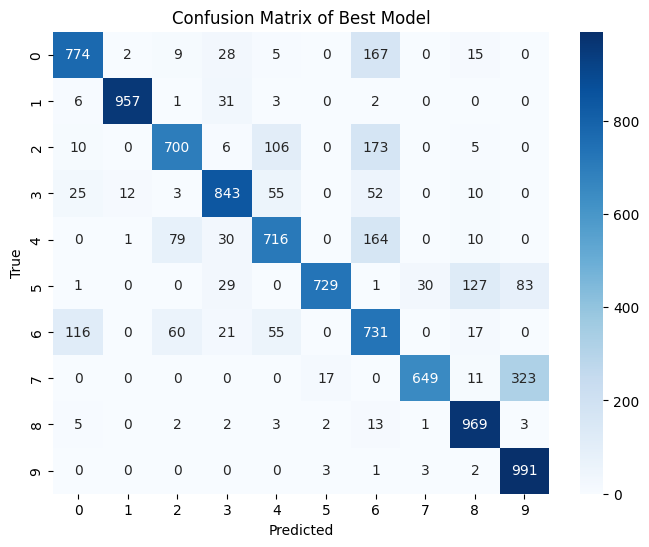

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
test_accuracy,▁
test_loss,▁
accuracy,0.87887
epoch,10
loss,0.08734
test_accuracy,0.8059
test_loss,0.14513


In [17]:
#best model for MSE

wandb.init(project="neural-network-hyperparam-tuning", name="best_model_evaluation")

best_config = {
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 10,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 4,
    "optimizer": "momentum",
    "weight_decay": 0.5,
    "weight_init": "xavier"
}

layers = [
    layer(784, best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"])
]
for _ in range(best_config["num_hidden_layers"] - 1):
    layers.append(layer(best_config["fc_layer_size"], best_config["fc_layer_size"], best_config["activation"], best_config["weight_init"]))
layers.append(layer(best_config["fc_layer_size"], 10, "softmax", best_config["weight_init"]))

num_samples = x_train.shape[0]

for epoch in range(best_config["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_train_shuffled = x_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    epoch_loss = 0
    epoch_acc = 0

    for start in range(0, num_samples, best_config["batch_size"]):
        end = min(start + best_config["batch_size"], num_samples)
        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = squared_error_loss(y_batch, a)
        acc = accuracy(y_batch, a)

        epoch_loss += loss
        epoch_acc += acc

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, best_config["lr"], best_config["optimizer"])

    num_batches = max(1, num_samples // best_config["batch_size"])
    avg_loss = epoch_loss / num_batches
    avg_acc = epoch_acc / num_batches

    print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_acc}")

    wandb.log({"epoch": epoch + 1, "loss": avg_loss, "accuracy": avg_acc})


a_test = x_test
for l in layers:
    a_test = l.forward(a_test)

test_loss = squared_error_loss(y_test, a_test)
test_acc = accuracy(y_test, a_test)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

wandb.log({"test_loss": test_loss, "test_accuracy": test_acc})

y_pred = np.argmax(a_test, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of Best Model")

wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

wandb.finish()

# Question 10

Based on our learnings from the experiments on the Fashion-MNIST dataset, we will take 3 of the best performing models and evaluate their performance on the MNIST dataset

In [18]:
from tensorflow.keras.datasets import mnist


In [19]:
(x_1_train, y_1_train), (x_1_test, y_1_test) = mnist.load_data()

x_1_train = x_1_train.reshape(x_1_train.shape[0], 28, 28, 1)
x_1_train = x_1_train.astype('float32') / 255.0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
y_1_train = one_hot_encode(y_1_train)
y_1_test = one_hot_encode(y_1_test)

In [21]:
x_train.shape

(54000, 784)

In [22]:
x_1_train.shape

(60000, 28, 28, 1)

In [23]:
rec_config_1 = {
    "activation": "relu",
    "batch_size": 64,
    "epochs": 5,
    "fc_layer_size": 128,
    "lr": 0.001,
    "num_hidden_layers": 3,
    "optimizer": "adam",
    "weight_decay": 0,
    "weight_init": "xavier"
}

layers = [layer(784, rec_config_1["fc_layer_size"], rec_config_1["activation"], rec_config_1["weight_init"])]
for _ in range(rec_config_1["num_hidden_layers"] - 1):
    layers.append(layer(rec_config_1["fc_layer_size"], rec_config_1["fc_layer_size"], rec_config_1["activation"], rec_config_1["weight_init"]))
layers.append(layer(rec_config_1["fc_layer_size"], 10, "softmax", rec_config_1["weight_init"]))

num_samples = x_1_train.shape[0]

x_1_train = x_1_train.reshape(x_1_train.shape[0], -1)
x_1_test = x_1_test.reshape(x_1_test.shape[0], -1)


for epoch in range(rec_config_1["epochs"]):
    shuffled_indices = np.random.permutation(num_samples)
    x_1_train_shuffled = x_1_train[shuffled_indices]
    y_1_train_shuffled = y_1_train[shuffled_indices]

    for start in range(0, num_samples, rec_config_1["batch_size"]):
        end = min(start + rec_config_1["batch_size"], num_samples)
        x_batch = x_1_train_shuffled[start:end]
        y_batch = y_1_train_shuffled[start:end]

        a = x_batch
        for l in layers:
            a = l.forward(a)

        loss = categorical_cross_entropy(y_batch, a, layers, rec_config_1["weight_decay"])

        a_d = a - y_batch
        for l in reversed(layers):
            a_d = l.backprop(a_d, rec_config_1["lr"], rec_config_1["optimizer"])

a_test = x_1_test
for l in layers:
    a_test = l.forward(a_test)

acc = accuracy(y_1_test, a_test)

print(f"Accuracy on x_1_test: {acc}")
print("Predictions on x_1_test:", y_pred)


Accuracy on x_1_test: 0.9115
Predictions on x_1_test: [9 2 1 ... 8 1 5]
